In [1]:

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")

In [2]:
exp_dir ="expo_1k_shots"

In [3]:
colors = {
    "vanilla": sns.color_palette()[0],
    "cc": sns.color_palette()[1],
    "sw": sns.color_palette()[2],
    "cc_sw": sns.color_palette()[3],
    
    "cc_all": sns.color_palette()[4],
    "sw_without": sns.color_palette()[2],
    "sw_after": sns.color_palette()[3],
}

legend = {
    "vanilla": "Naive",
    "cc": "Only Circuit Cutting",
    "sw": "Only Shot-Wise",
    "cc_sw": "Cut&Shoot",
    
    "cc_all": "Circuit Cutting",
    "sw_without": "Shot-Wise (Without Circuit Cutting)",
    "sw_after": "Shot-Wise (After Circuit Cutting)",
}

dir = "./experiments_results/"

path = dir + exp_dir + "/"

path

'./experiments_results/expo_1k_shots/'

In [4]:
plots_dir = path + "plots/"
os.makedirs(plots_dir, exist_ok=True)
plots_dir   

'./experiments_results/expo_1k_shots/plots/'

In [5]:
circuit_qubits = {}

for file in os.listdir(path+"perf_exp_vals/"):
    if file.endswith(".json"):
        circuit_id = "_".join(file.split("_")[:5])
        file_json = json.load(open(path+"perf_exp_vals/"+file))
        qubits = file_json["n_qubits"]
        circuit_qubits[circuit_id] = int(qubits)
    else:
        print(f"WARNING: {file} is not a json file")

In [6]:

exp_data = []

for file in os.listdir(path+"vanilla"):
    if file.endswith(".json"):
        circuit_id = "_".join(file.split("_")[3:8])
        qubits = circuit_qubits[circuit_id]
        file_json = json.load(open(path+"vanilla/"+file))   
        num_backends = len(file_json["params"]["backends"])
        time_total = file_json["times"]["time_total"]
        execution_time = file_json["times"]["time_execution"]
        
        for provider, backends in file_json["error"].items():
            for backend, res in backends.items():
                backend_name = provider + "/" + backend
                error = res[list(res.keys())[0]]
                
                shots = sum(x[1] for x in file_json["stats"]["dispatch"][provider][backend])
                cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
                shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
                shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
                
                exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": [backend_name], "num_backends": 1, "error": error, "time": time_total, "shots": shots, "circuit_cutting": False, "shot-wise": False, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "vanilla", "circuit_cutting_overhead": None, "shot_wise_overhead": None, "execution_time": execution_time, "time_total": time_total})
    else:
        print(f"WARNING: {file} is not a json file")
        
for file in os.listdir(path+"cc"):
    if file.endswith(".json"):
        circuit_id = "_".join(file.split("_")[3:8])
        qubits = circuit_qubits[circuit_id]
        file_json = json.load(open(path+"cc/"+file))   
        num_backends = len(file_json["params"]["backends"])
        time_total = file_json["times"]["time_total"]      
        execution_time = file_json["times"]["time_execution"]
        
        
        for provider, backends in file_json["error"].items():
            for backend, res in backends.items():
                backend_name = provider + "/" + backend
                error = res[list(res.keys())[0]]
                
                shots = sum(x[1] for x in file_json["stats"]["dispatch"][provider][backend])
                
                cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
                shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
                shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
                
                circuit_cutting_overhead = file_json["times"]["time_cutting"] + file_json["times"]["time_sew"][provider][backend] + file_json["times"]["time_allocation"]
                
                exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": [backend_name], "num_backends": 1, "error": error, "time": time_total, "shots": shots, "circuit_cutting": True, "shot-wise": False, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "cc", "circuit_cutting_overhead": circuit_cutting_overhead, "shot_wise_overhead": None, "execution_time": execution_time, "time_total": time_total})
    else:
        print(f"WARNING: {file} is not a json file")
        
for file in os.listdir(path+"sw"):
    if file.endswith(".json"):
        circuit_id = "_".join(file.split("_")[3:8])
        qubits = circuit_qubits[circuit_id]
        file_json = json.load(open(path+"sw/"+file))   
        num_backends = len(file_json["params"]["backends"])
        time_total = file_json["times"]["time_total"]
    
        shots = 0
        for provider, backends in file_json["stats"]["dispatch"].items():
            for backend, shots_list in backends.items():
                shots += sum(x[1] for x in shots_list)
                
        backends = []
        for provider, backend in file_json["params"]["backends"]:
            backends.append(provider + "/" + backend)
            
        error = file_json["error"]
        
        execution_time = file_json["times"]["time_execution"]
        shot_wise_overhead = file_json["times"]["time_dispatch"] + file_json["times"]["time_merge"]

        cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
        shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
        shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
        
        exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": backends, "num_backends": num_backends, "error": error, "time": time_total, "shots": shots, "circuit_cutting": False, "shot-wise": True, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "sw", "circuit_cutting_overhead": None, "shot_wise_overhead": shot_wise_overhead, "execution_time": execution_time, "time_total": time_total})
    else:
        print(f"WARNING: {file} is not a json file")
        
for file in os.listdir(path+"cc_sw"):
    if file.endswith(".json"):
        circuit_id = "_".join(file.split("_")[4:9])
        qubits = circuit_qubits[circuit_id]
        file_json = json.load(open(path+"cc_sw/"+file))   
        num_backends = len(file_json["params"]["backends"])
        time_total = file_json["times"]["time_total"]
    
        shots = 0
        for provider, backends in file_json["stats"]["dispatch"].items():
            for backend, shots_list in backends.items():
                shots += sum(x[1] for x in shots_list)
                
        backends = []
        for provider, backend in file_json["params"]["backends"]:
            backends.append(provider + "/" + backend)
            
        error = file_json["error"]
        
        execution_time = file_json["times"]["time_execution"]
        shot_wise_overhead = file_json["times"]["time_dispatch"] + file_json["times"]["time_merge"]
        circuit_cutting_overhead = file_json["times"]["time_cutting"] + file_json["times"]["time_sew"] + file_json["times"]["time_allocation"]

        cut_strategy = file_json["params"]["cut_strategy"] if "cut_strategy" in file_json["params"] else None
        shots_allocation = file_json["params"]["shots_allocation"] if "shots_allocation" in file_json["params"] else None
        shot_wise_policy = file_json["params"]["shot_wise_policy"] if "shot_wise_policy" in file_json["params"] else None
        
        exp_data.append({"circuit_id": circuit_id, "qubits": qubits, "backends": backends, "num_backends": num_backends, "error": error, "time": time_total, "shots": shots, "circuit_cutting": True, "shot-wise": True, "cut_strategy": cut_strategy, "shots_allocation": shots_allocation, "shot_wise_policy": shot_wise_policy, "strategy": "cc_sw", "circuit_cutting_overhead": circuit_cutting_overhead, "shot_wise_overhead": shot_wise_overhead, "execution_time": execution_time, "time_total": time_total})    
    else:
        print(f"WARNING: {file} is not a json file")


exp_data_df = pd.DataFrame(exp_data)
exp_data_df["error"] = exp_data_df["error"].apply(lambda x: abs(x))
exp_data_df

,circuit_id,qubits,backends,num_backends,error,time,shots,circuit_cutting,shot-wise,cut_strategy,shots_allocation,shot_wise_policy,strategy,circuit_cutting_overhead,shot_wise_overhead,execution_time,time_total
0,n4_r2_k2_p1_s18,10,[ibm_aer/aer.fake_brisbane],1,0.067876,4.817814,1000,False,False,None,None,None,vanilla,NaN,NaN,0.006558,4.817814
1,n4_r2_k2_p1_s27,10,[ibm_aer/aer.fake_sherbrooke],1,0.038010,5.184485,1000,False,False,None,None,None,vanilla,NaN,NaN,0.006374,5.184485
2,n4_r2_k2_p1_s15,10,[ibm_aer/aer.fake_kawasaki],1,0.019995,4.555653,1000,False,False,None,None,None,vanilla,NaN,NaN,0.006358,4.555653
3,n4_r3_k1_p1_s2,14,[ibm_aer/aer.fake_brisbane],1,0.000002,4.896133,1000,False,False,None,None,None,vanilla,NaN,NaN,0.006387,4.896133
4,n4_r3_k1_p1_s11,14,[ibm_aer/aer.fake_osaka],1,0.006000,4.952271,1000,False,False,None,None,None,vanilla,NaN,NaN,0.006450,4.952271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25021,n4_r2_k2_p1_s27,10,"[ibm_aer/aer.fake_osaka, ibm_aer/aer.fake_cusc...",4,0.028365,17.737849,996,True,True,cutshot.src.pennylane_tool,cutshot.src.policies.qubit_exp,cutshot.src.policies.sw_fair_policies,cc_sw,1.131811,0.001329,0.017732,17.737849
25022,n4_r2_k2_p1_s18,10,"[ibm_aer/aer.fake_kyoto, ibm_aer/aer.fake_osak...",4,0.000056,17.454729,8000,True,True,cutshot.src.pennylane_tool,cutshot.src.policies.multiplier,cutshot.src.policies.sw_fair_policies,cc_sw,1.183985,0.001993,0.017731,17.454729
25023,n4_r2_k2_p1_s15,10,"[ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_o...",4,0.003653,17.739268,1000,True,True,cutshot.src.pennylane_tool,cutshot.src.policies.divider,cutshot.src.policies.sw_fair_policies,cc_sw,0.994615,0.000521,0.017835,17.739268
25024,n2_r2_k1_p1_s149,5,"[ibm_aer/aer.fake_brisbane, ibm_aer/aer.fake_o...",4,0.013120,13.922888,1000,True,True,cutshot.src.pennylane_tool,cutshot.src.policies.2qgates_exp,cutshot.src.policies.sw_fair_policies,cc_sw,0.500701,0.000534,0.017431,13.922888


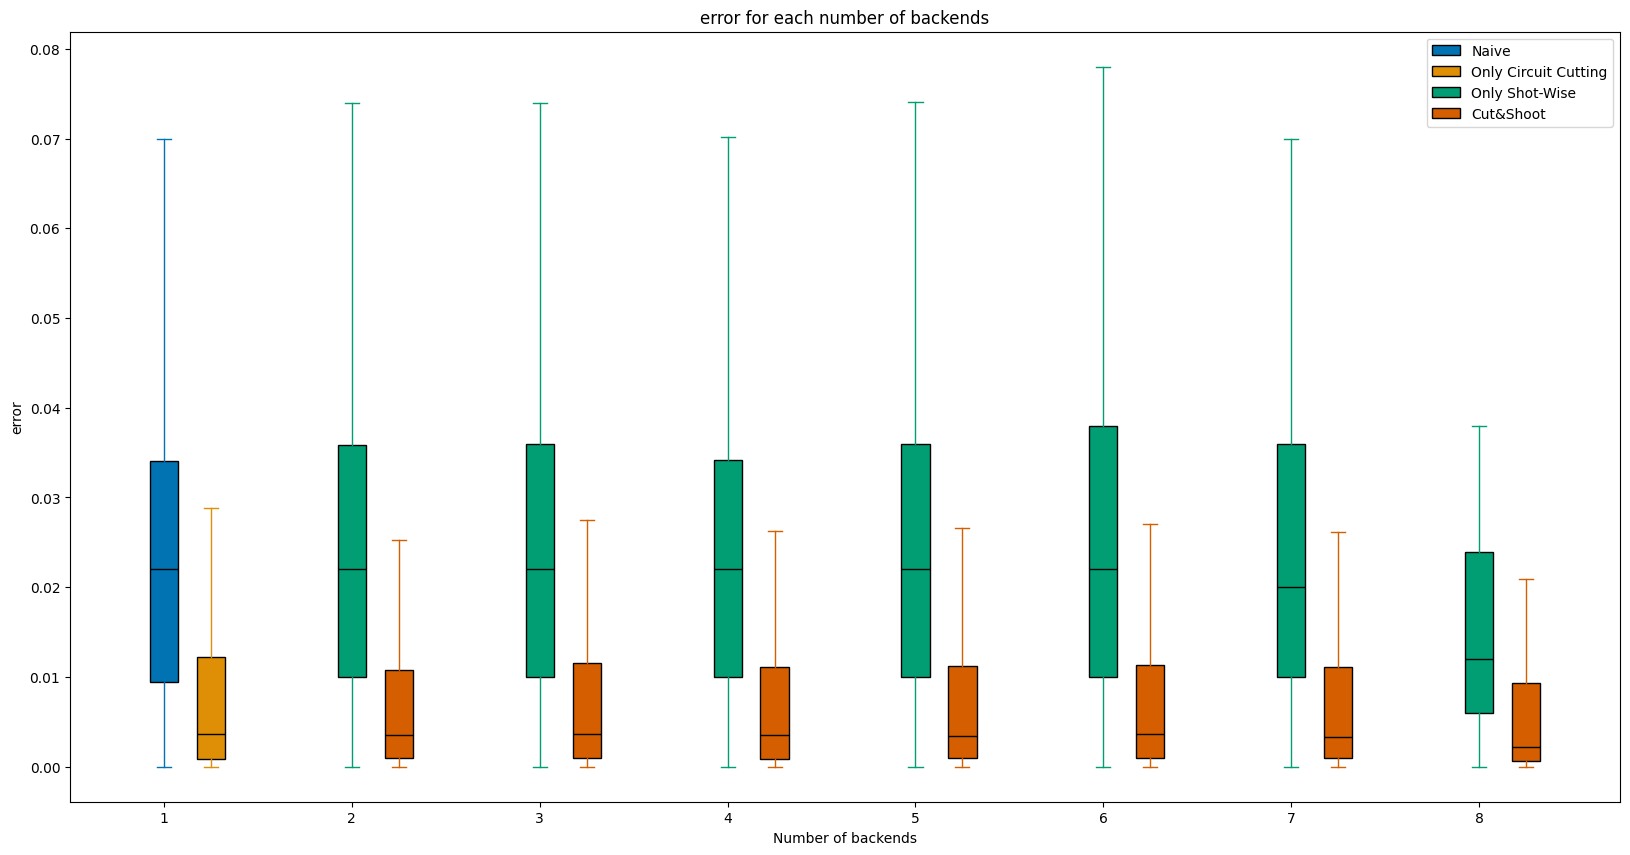

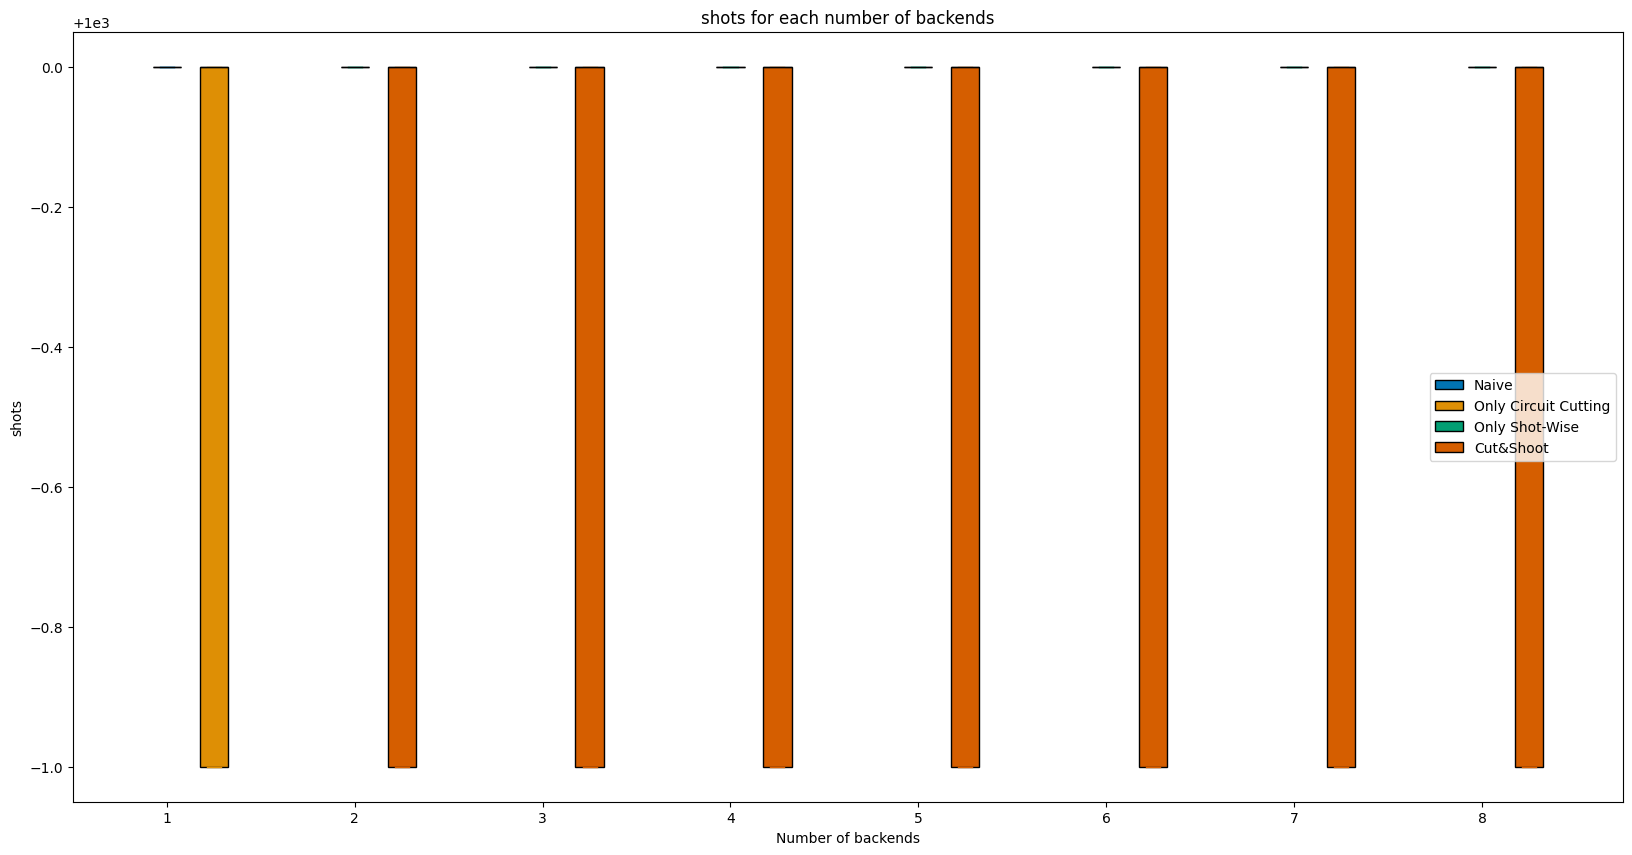

In [7]:
# for each number of backends, plot the error as cadlesticks, one for each strategy

for attr in ["error", "shots"]:

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for num_backends in exp_data_df["num_backends"].unique():
        data = exp_data_df[exp_data_df["num_backends"] == num_backends]
        offset = -0.25
        for strategy in data["strategy"].unique():
            data_strat = data[data["strategy"] == strategy]
            offset += 0.25
            color = colors[strategy]
            ax.boxplot(data_strat[attr], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            
    ax.set_xlabel("Number of backends")
    ax.set_ylabel(attr)
    ax.set_title(f"{attr} for each number of backends")
    ax.set_xticks(exp_data_df["num_backends"].unique())
    ax.set_xticklabels(exp_data_df["num_backends"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])

    plt.savefig(plots_dir + f"{attr}_num_backends.png")
    plt.show()




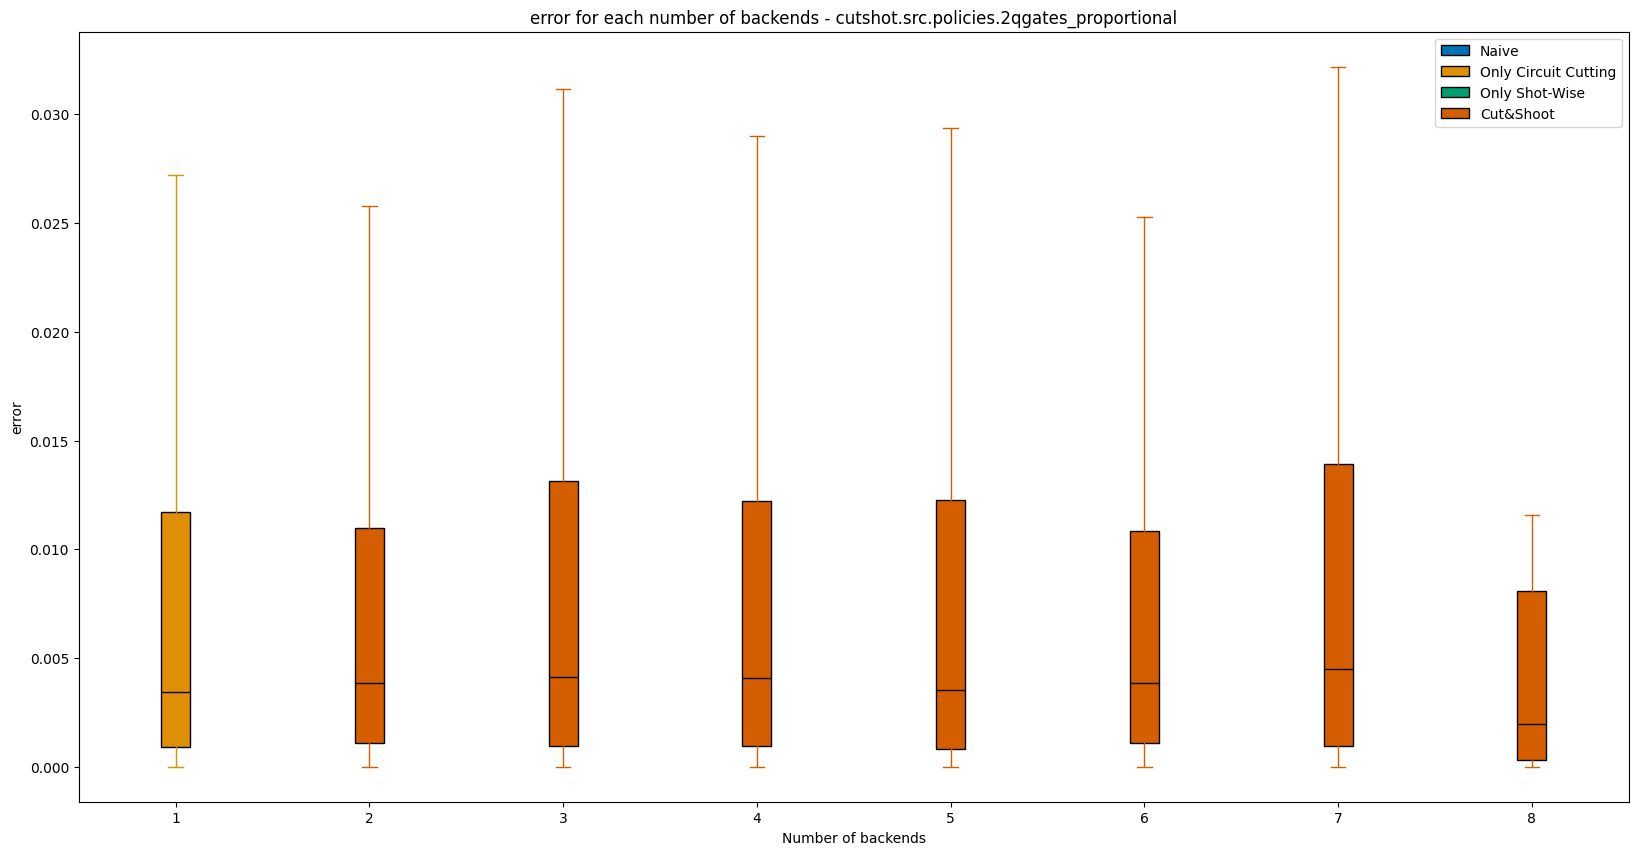

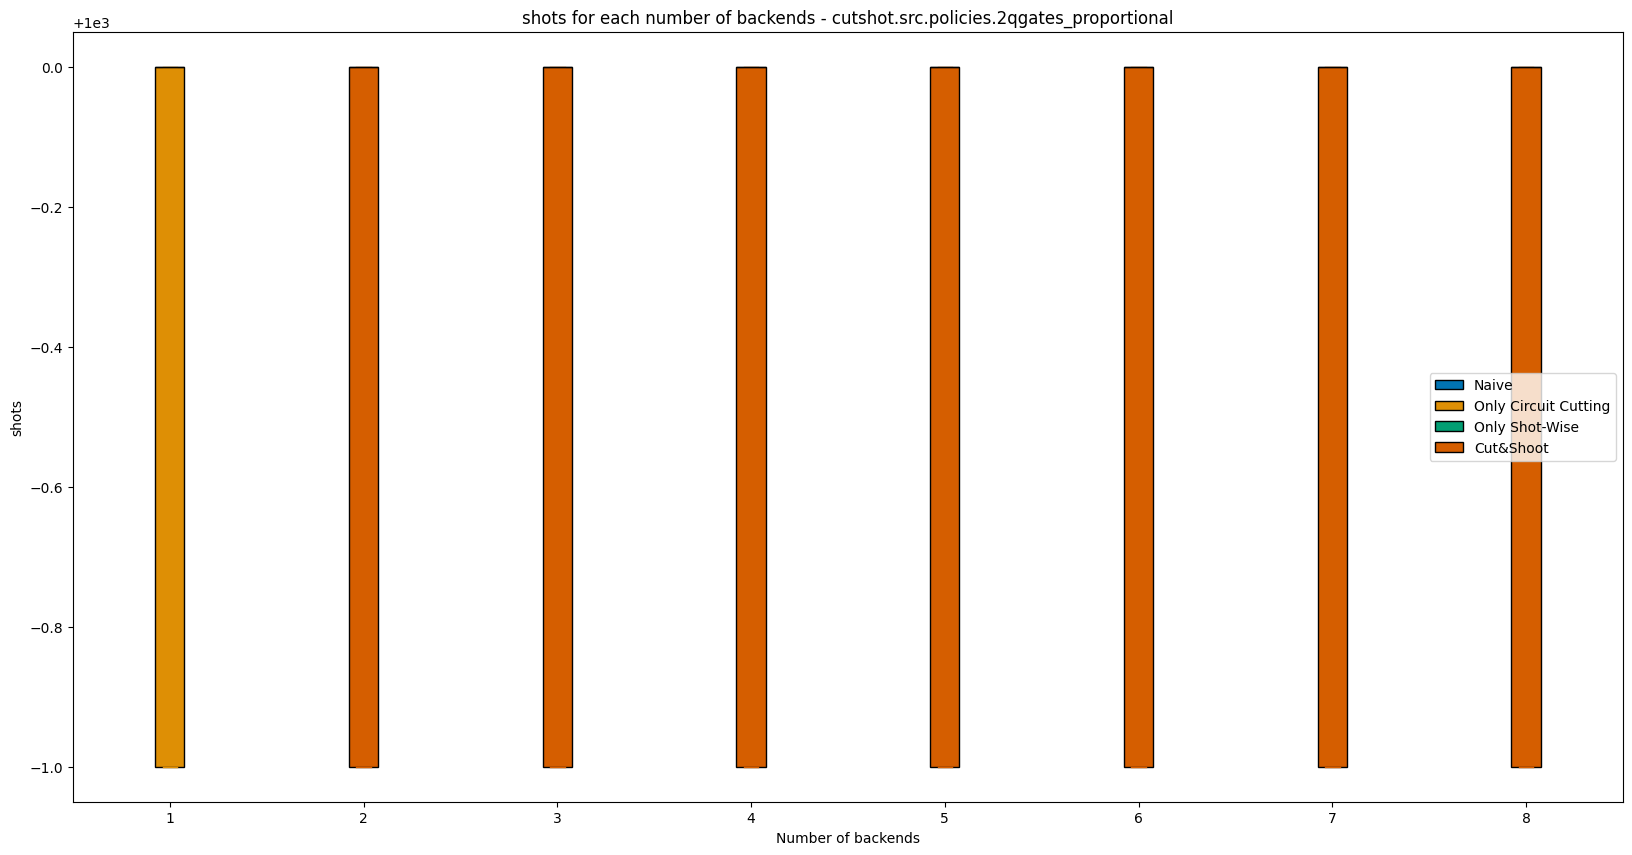

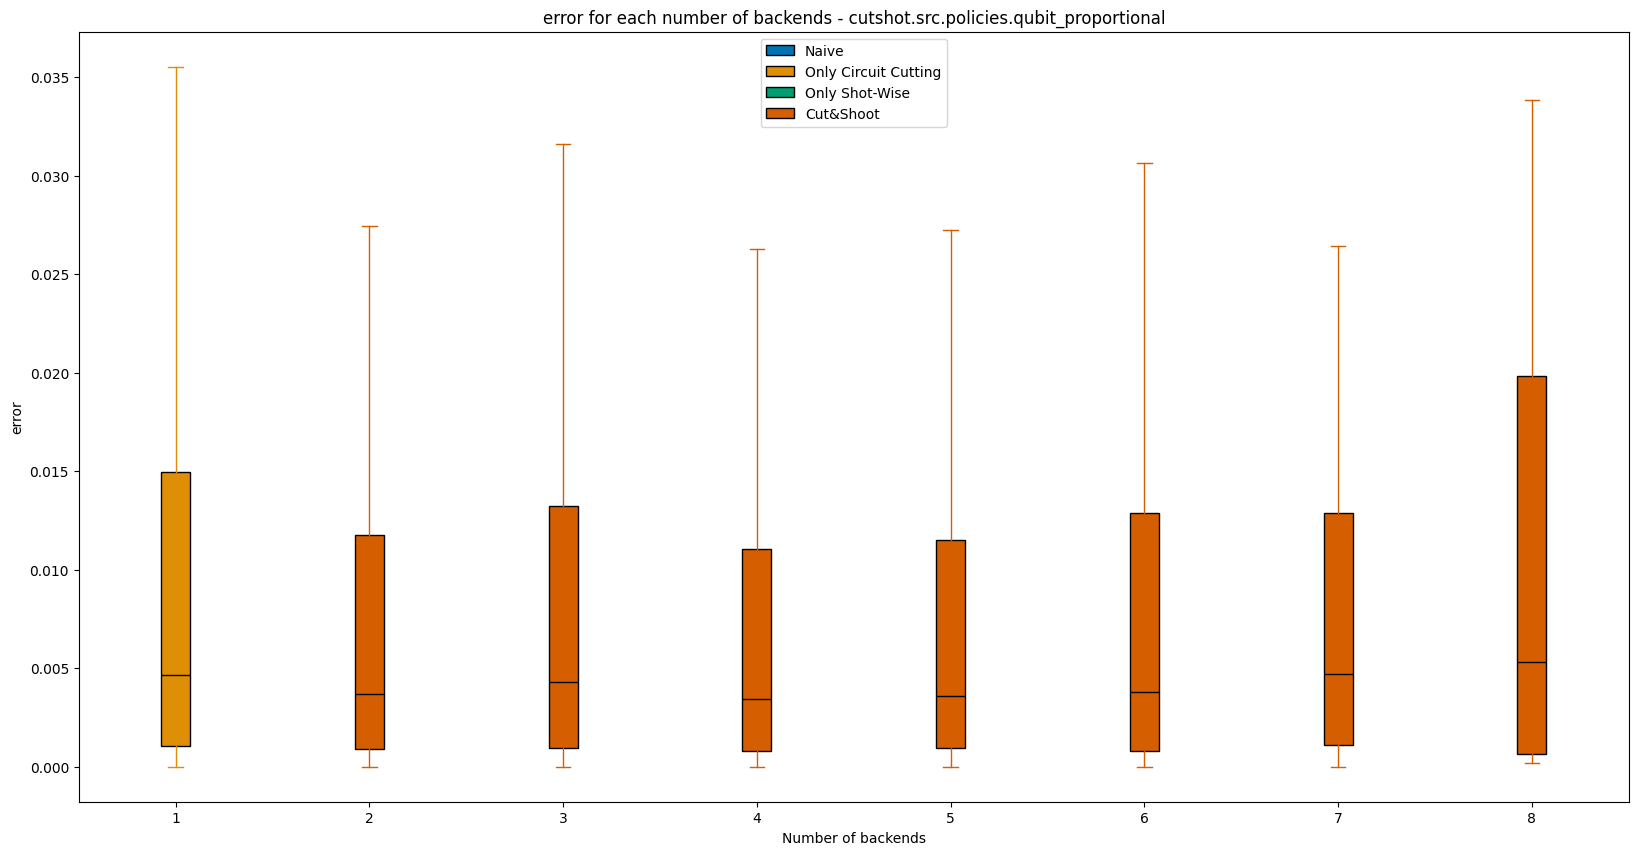

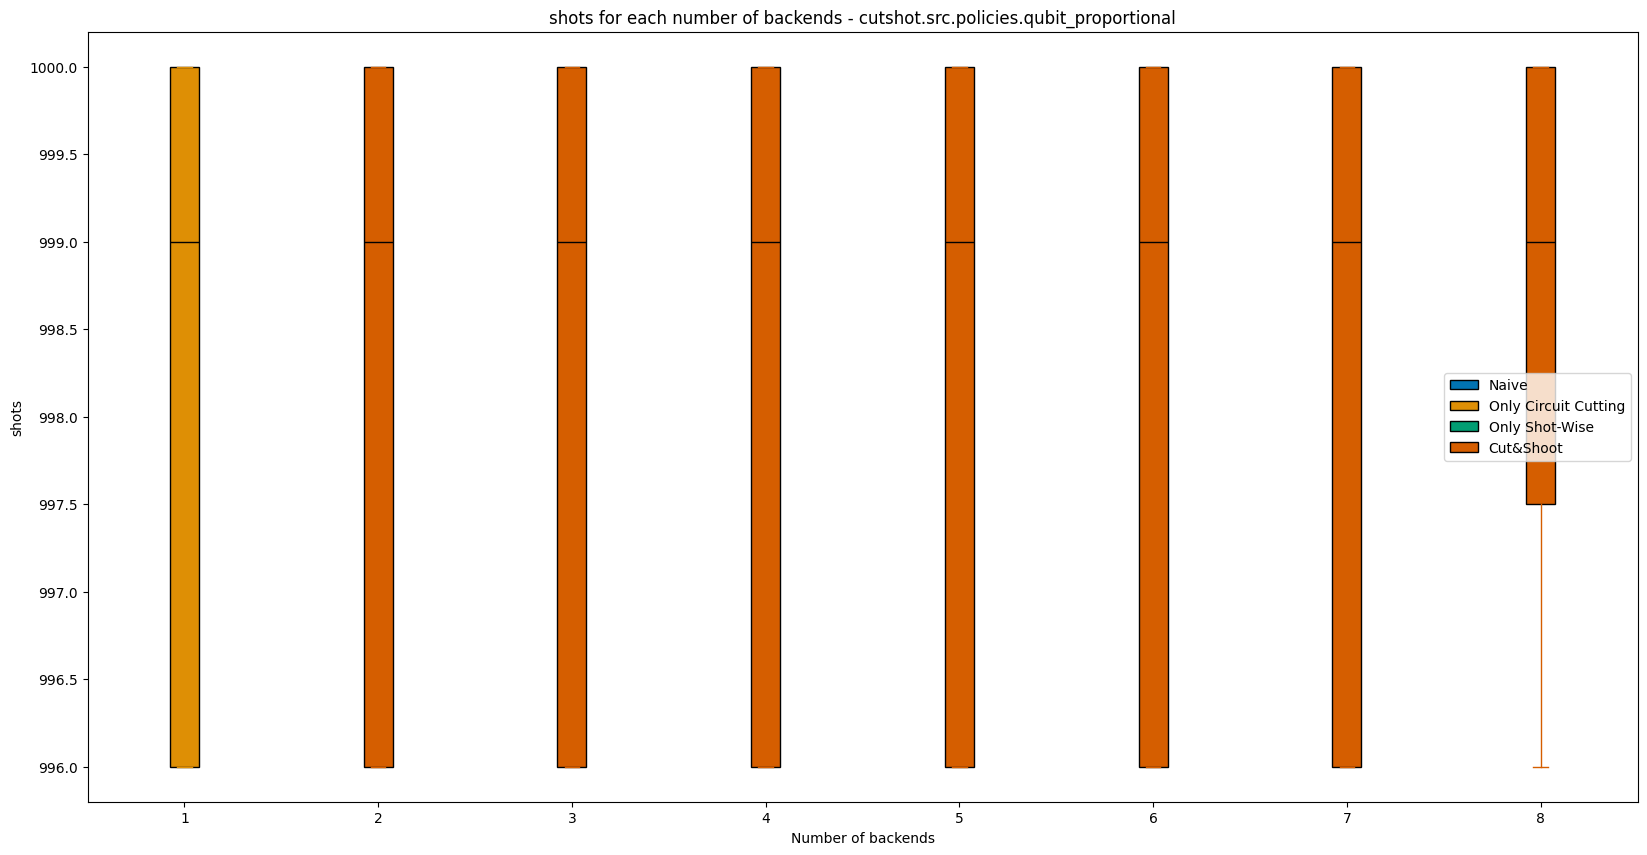

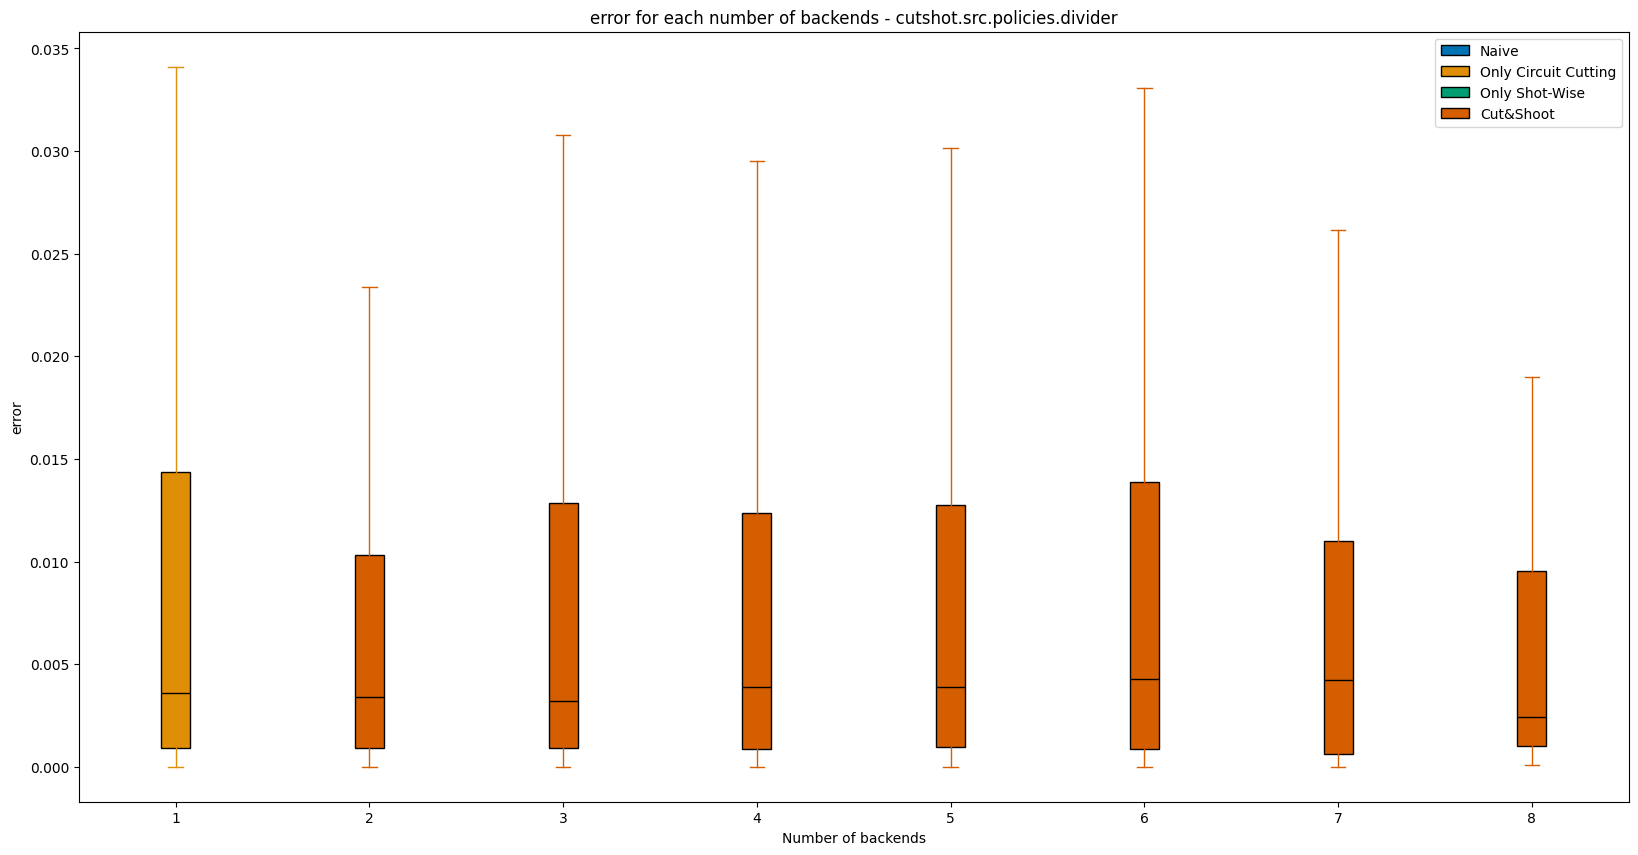

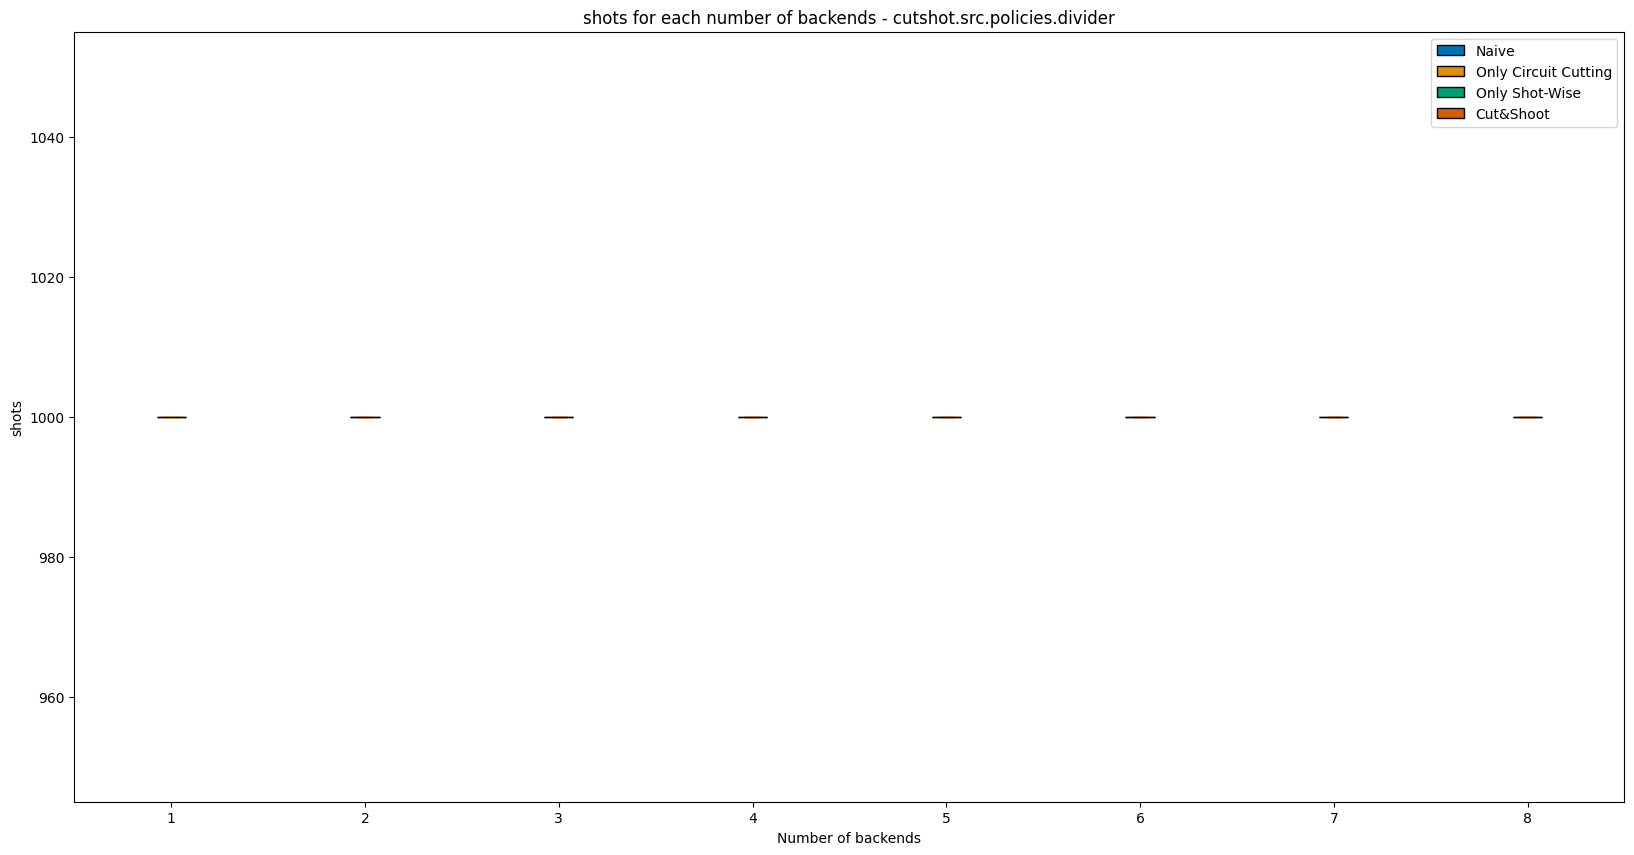

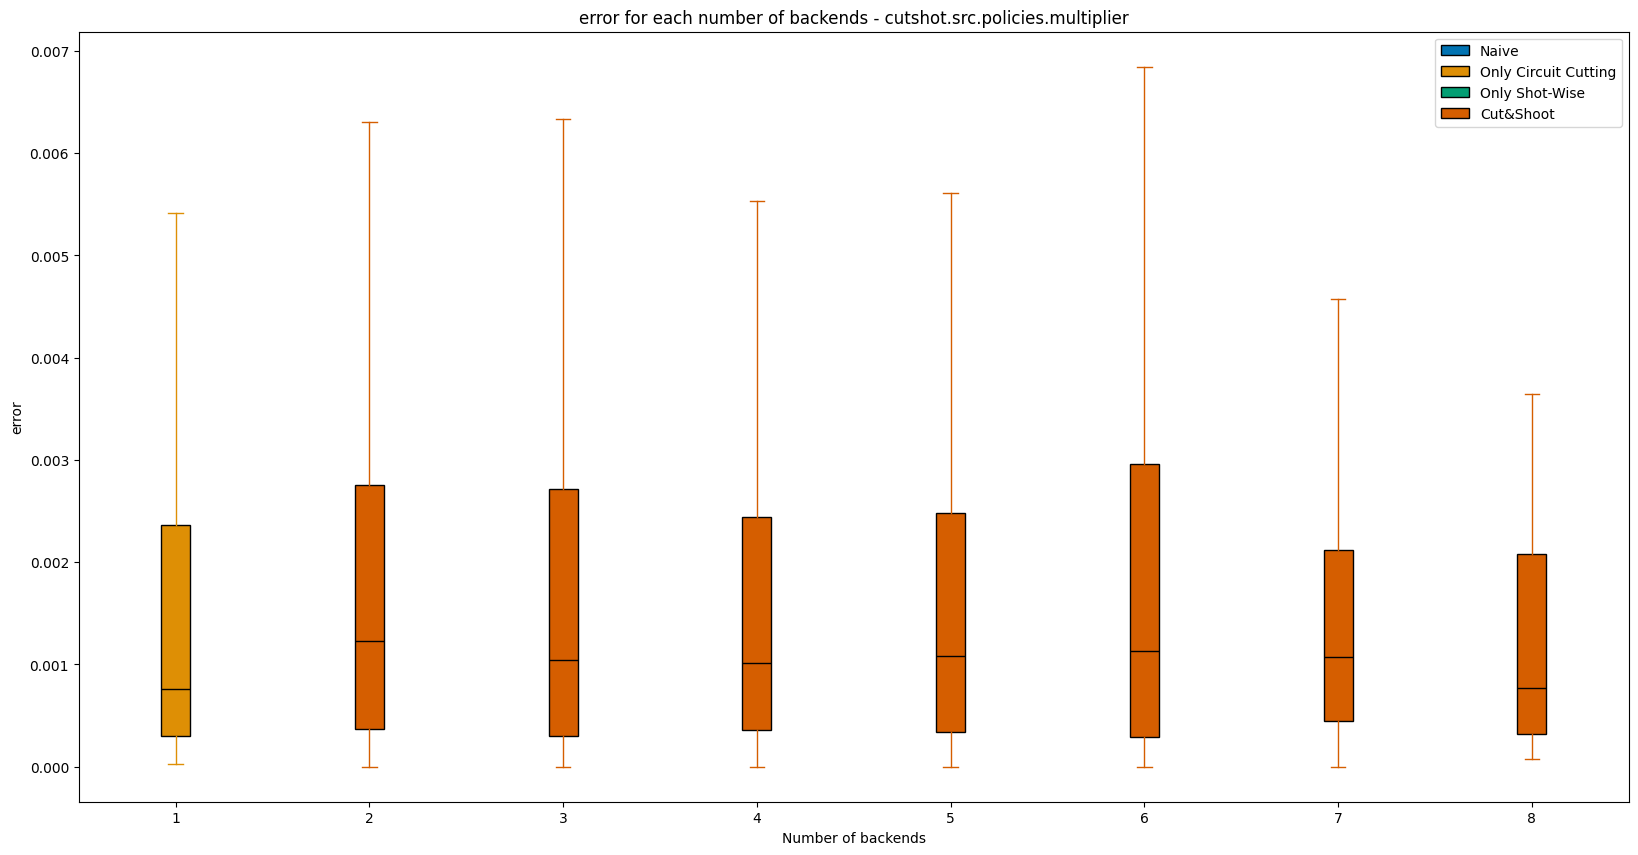

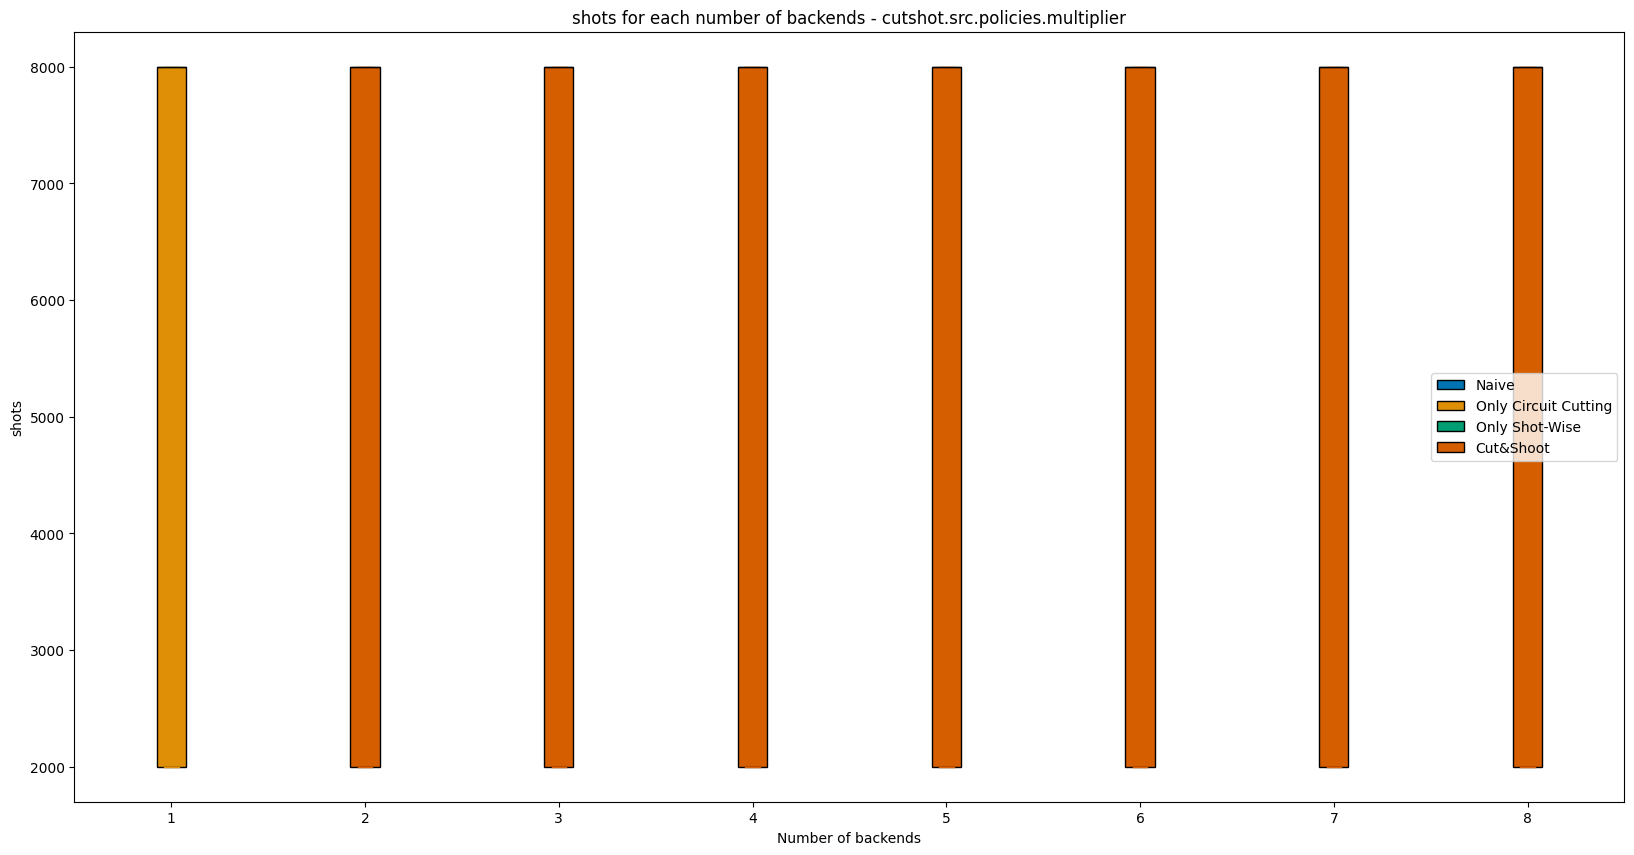

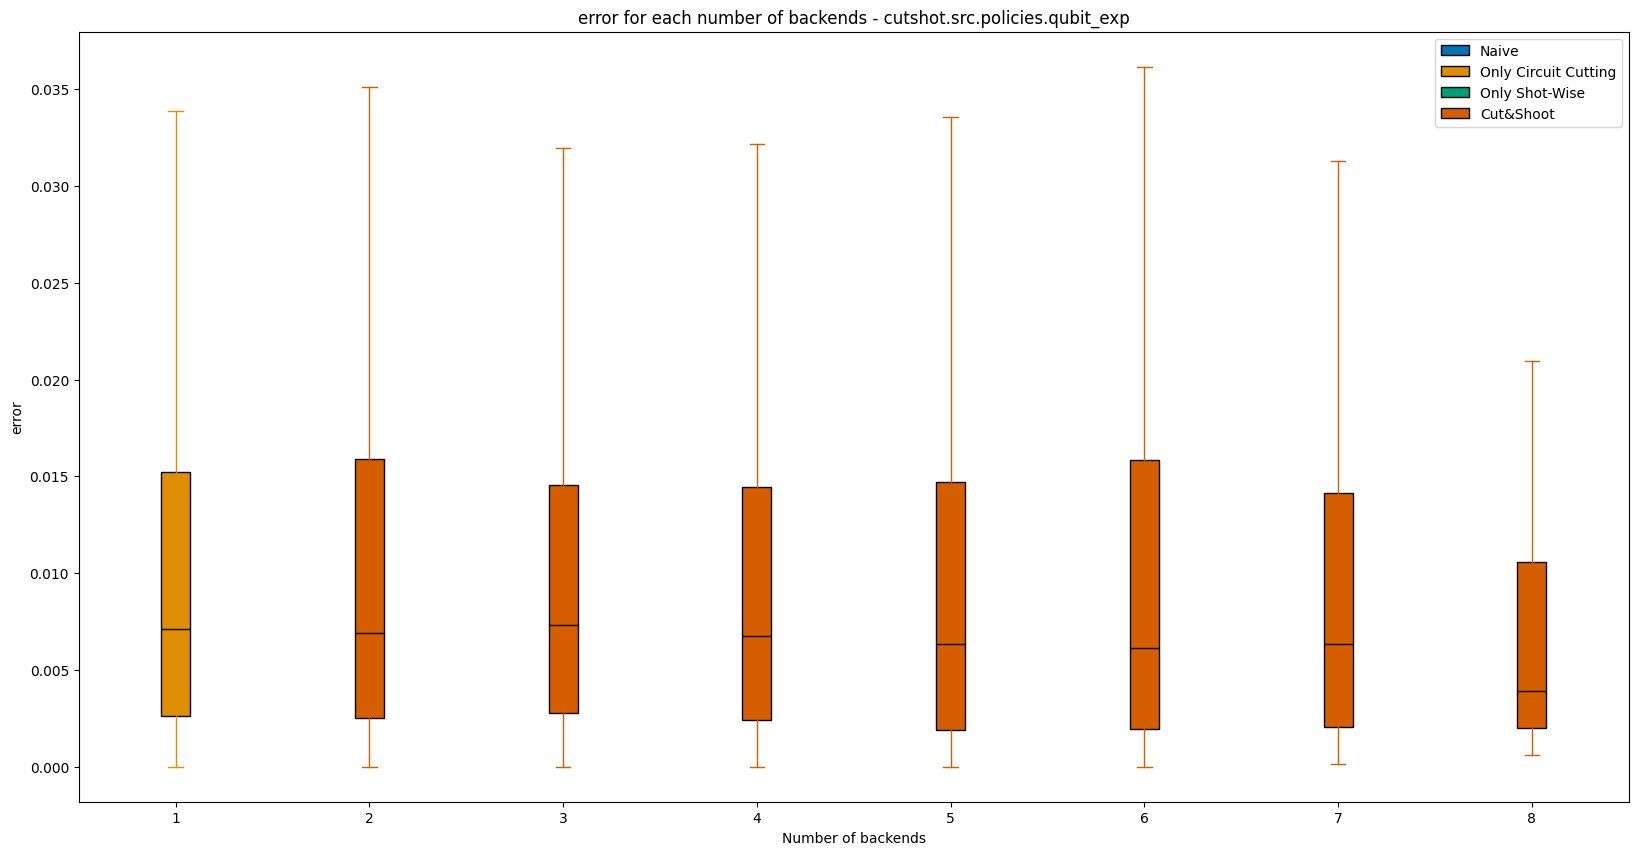

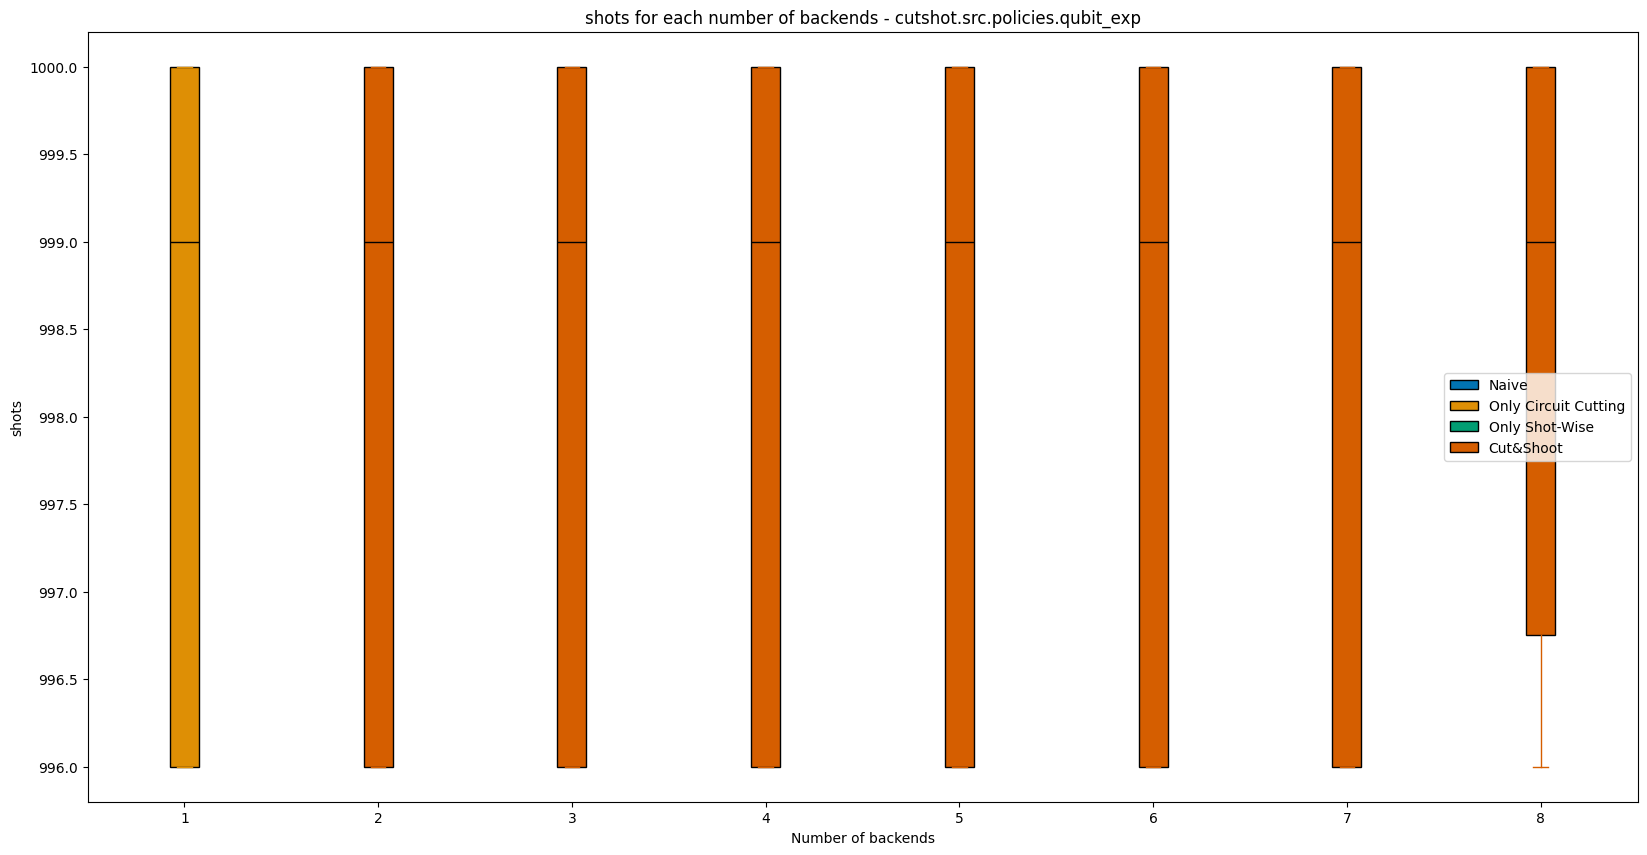

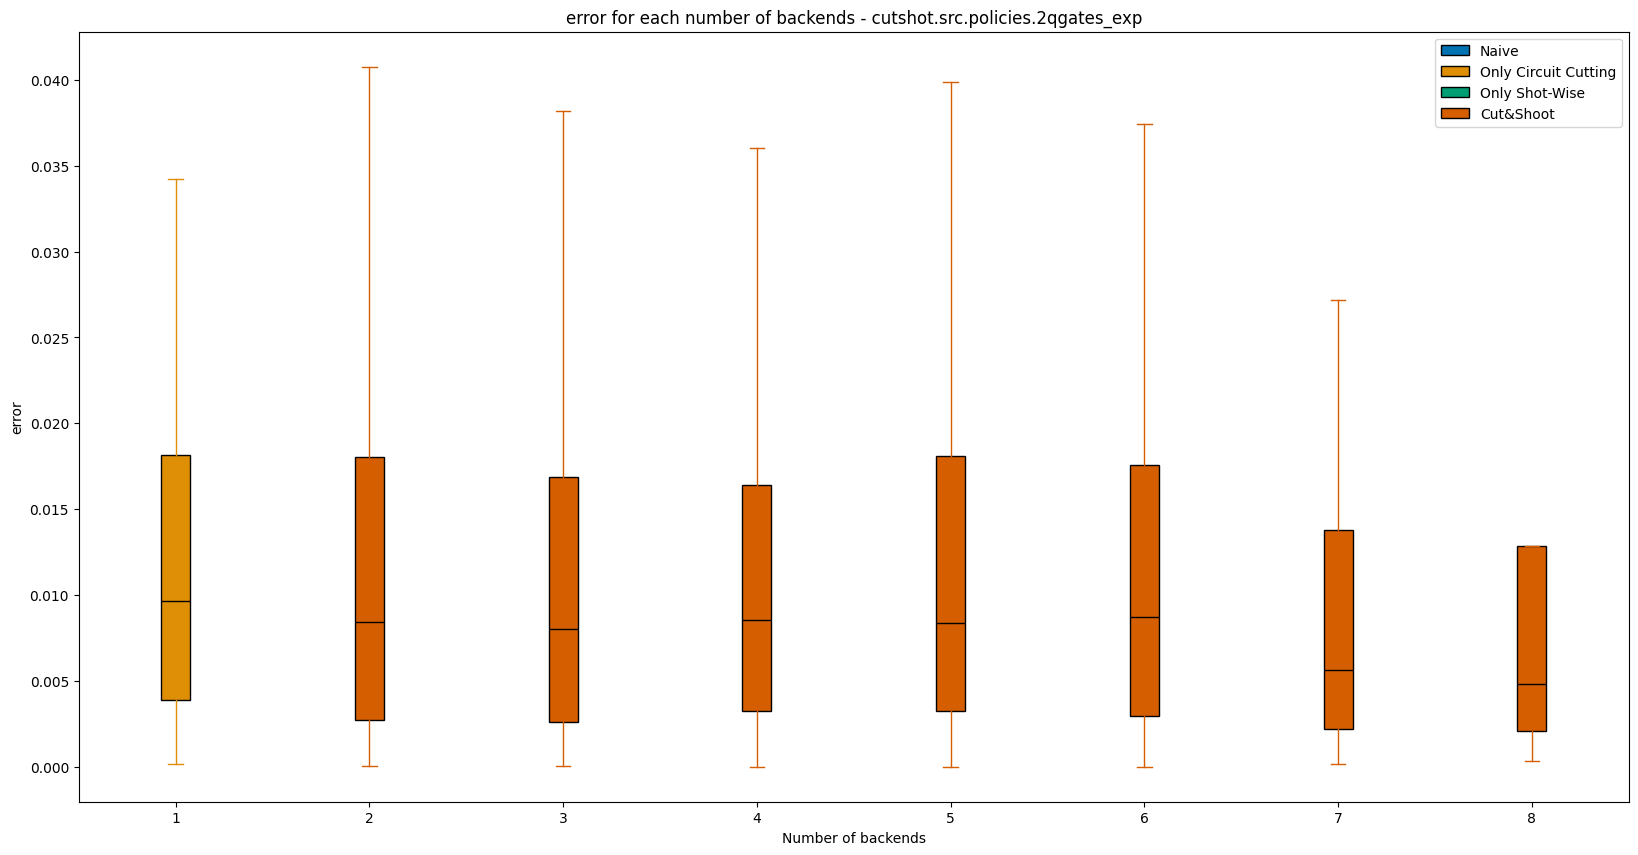

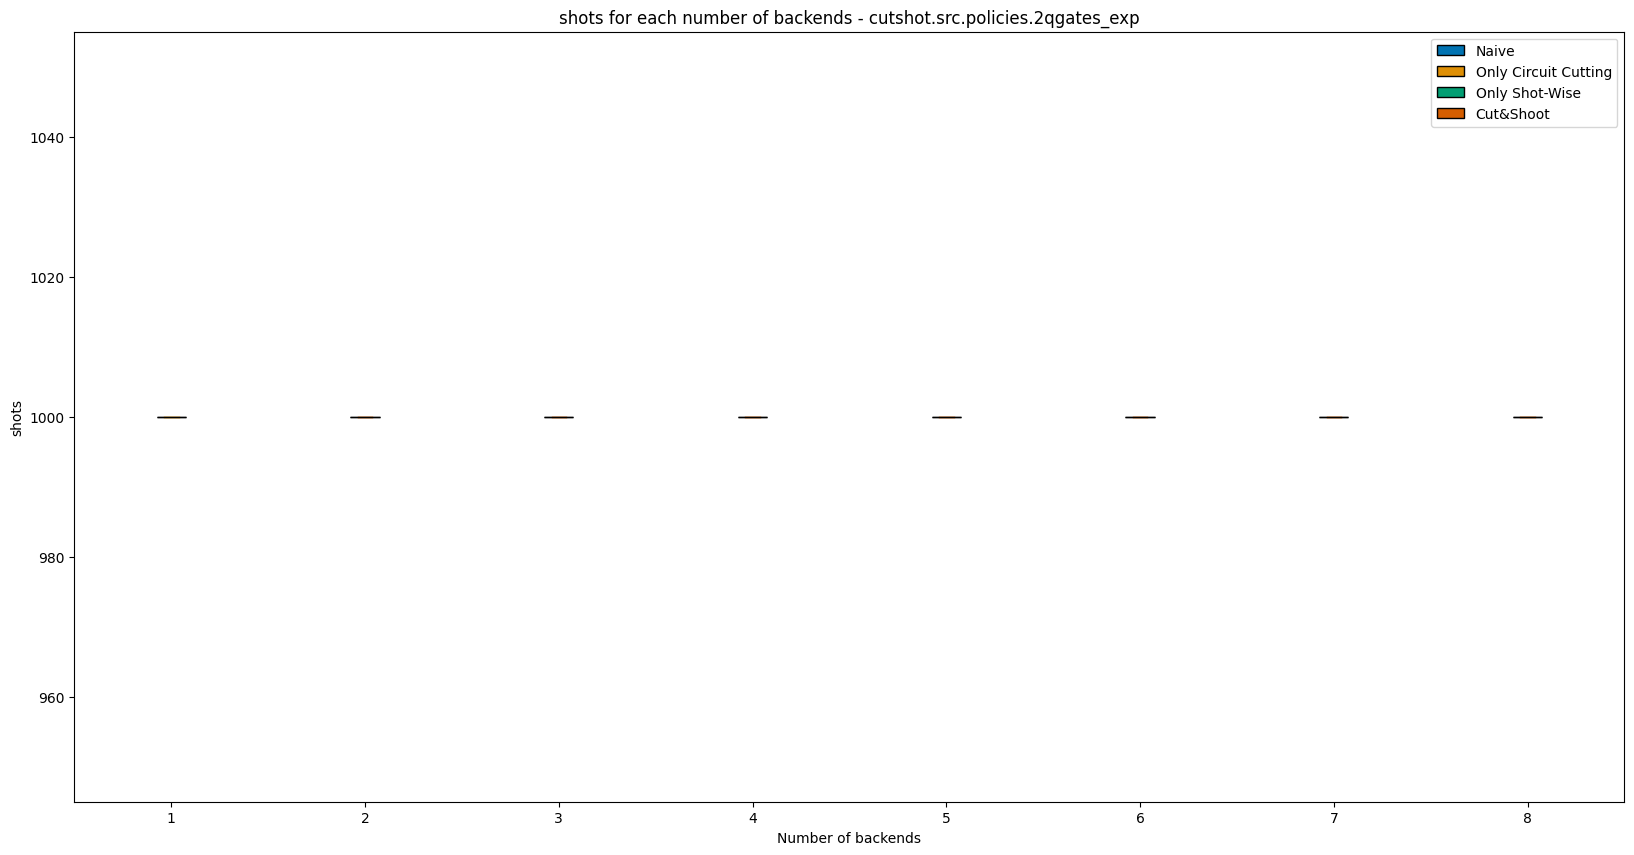

In [8]:
# for each number of backends, plot the error as cadlesticks, one for each strategy


for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    for attr in ["error", "shots"]:

        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)

        for num_backends in exp_data_df["num_backends"].unique():
            data = exp_data_df[(exp_data_df["num_backends"] == num_backends) & (exp_data_df["shots_allocation"] == sa)]
            offset = -0.25
            for strategy in data["strategy"].unique():
                data_strat = data[data["strategy"] == strategy]
                offset += 0.25
                color = colors[strategy]
                ax.boxplot(data_strat[attr], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
        
        from matplotlib.ticker import FormatStrFormatter

        ax.set_xlabel("Number of backends")
        ax.set_ylabel(attr)
        ax.set_title(f"{attr} for each number of backends - {sa}")
        ax.set_xticks(exp_data_df["num_backends"].unique())
        ax.set_xticklabels(exp_data_df["num_backends"].unique())
        ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
        # ax.yaxis.set_major_formatter(FormatStrFormatter('%.00000f'))
    
        plt.savefig(plots_dir + f"{attr}_num_backends_{sa}.png")
        plt.show()





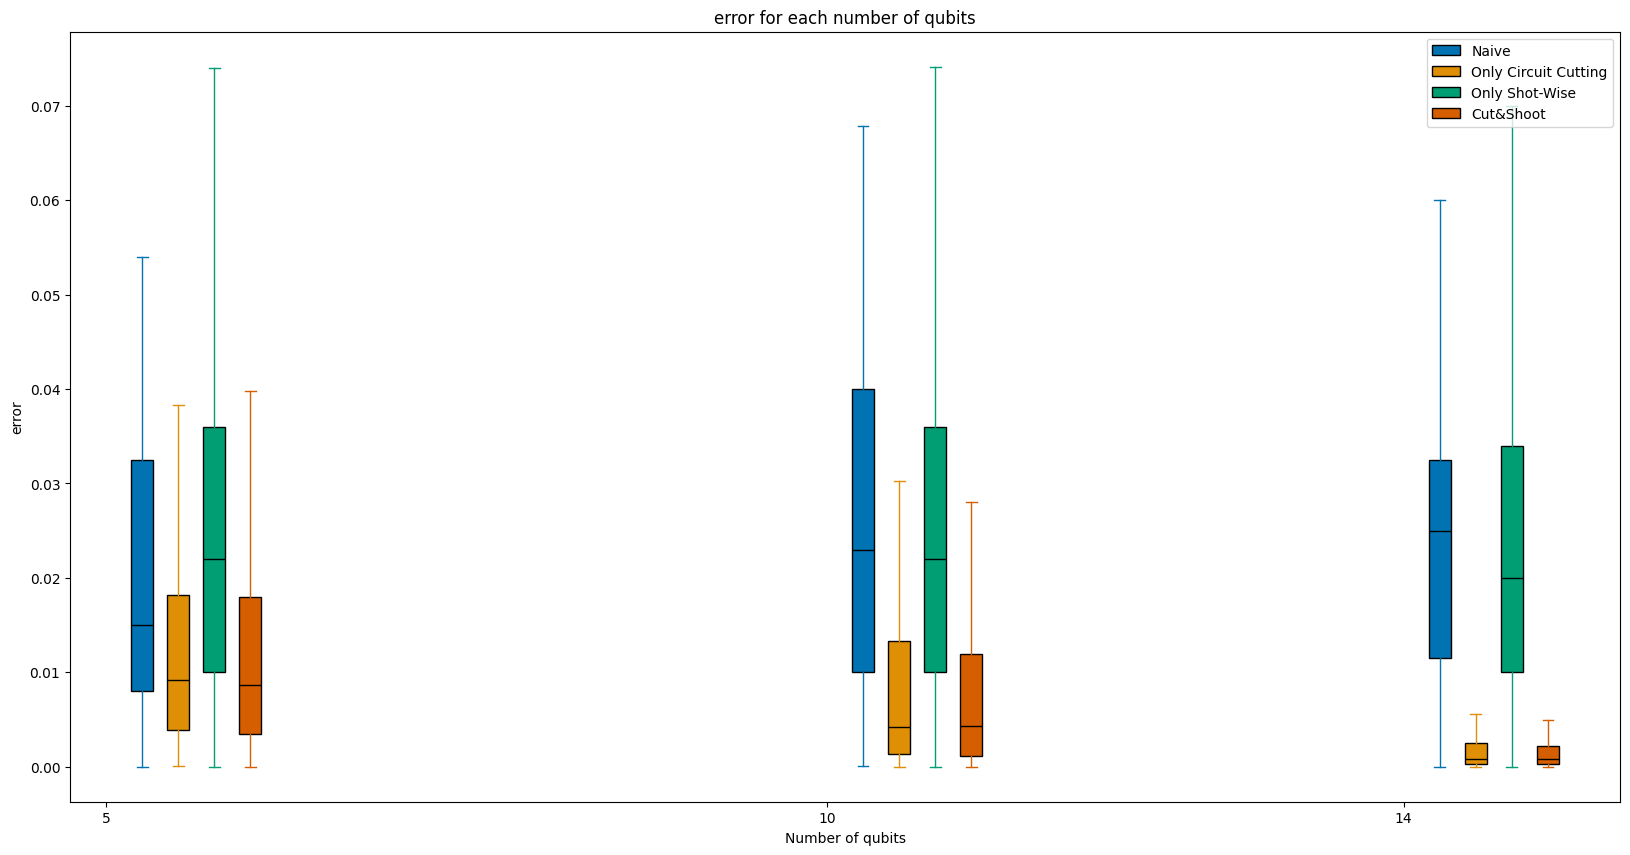

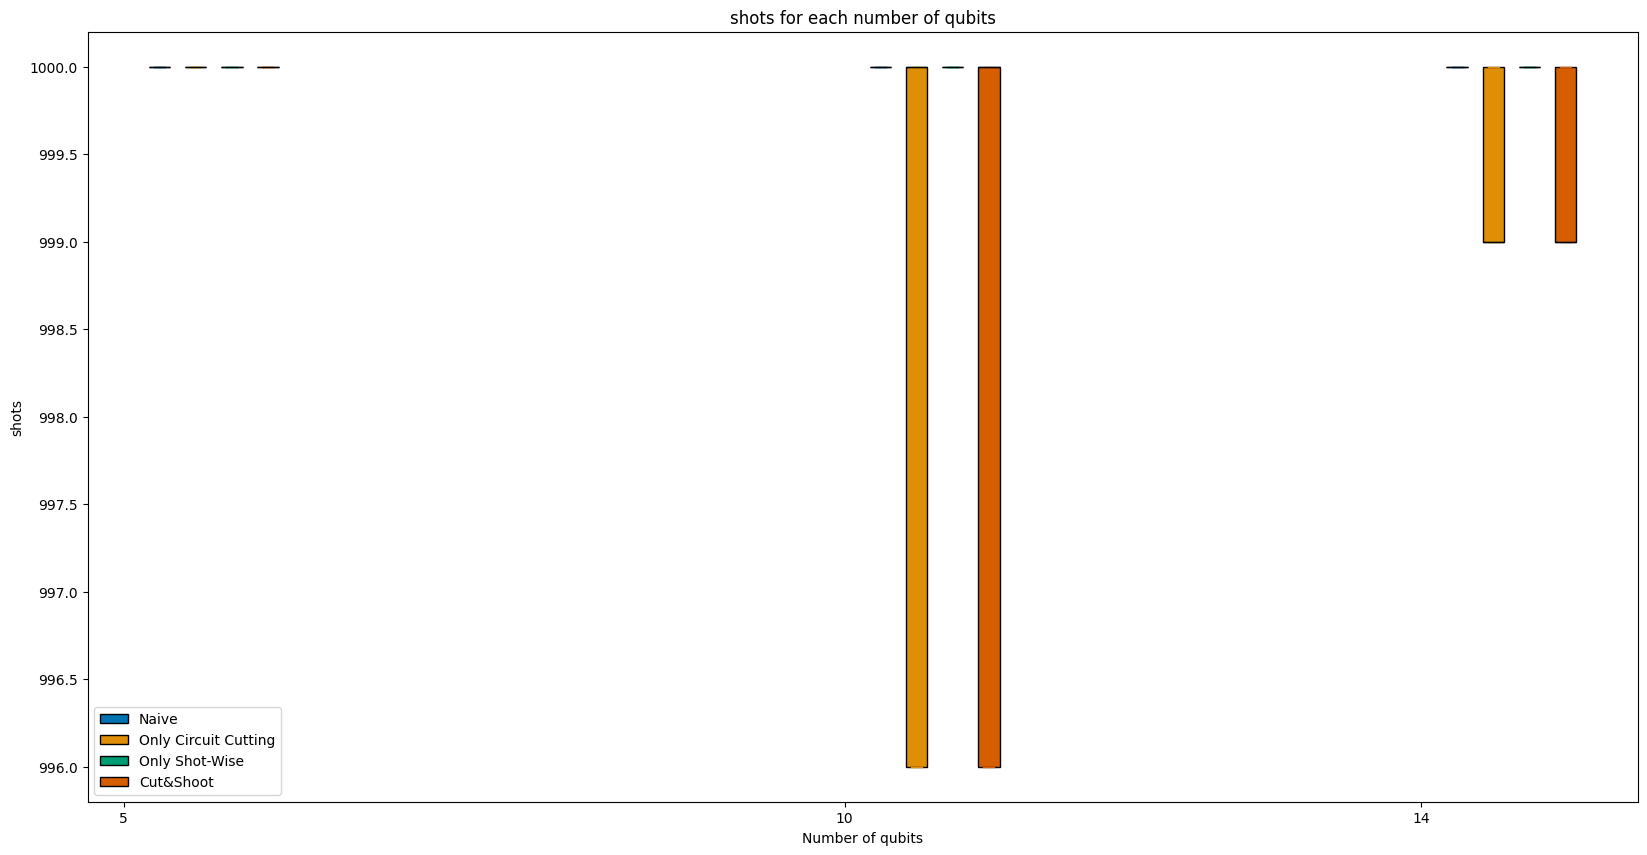

In [9]:

for attr in ["error", "shots"]:

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for qubits in exp_data_df["qubits"].unique():
        data = exp_data_df[exp_data_df["qubits"] == qubits]
        offset = 0
        for strategy in data["strategy"].unique():
            data_strat = data[data["strategy"] == strategy]
            offset += 0.25
            color = colors[strategy]
            ax.boxplot(data_strat[attr], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            
    ax.set_xlabel("Number of qubits")
    ax.set_ylabel(attr)
    ax.set_title(f"{attr} for each number of qubits")
    ax.set_xticks(exp_data_df["qubits"].unique())
    ax.set_xticklabels(exp_data_df["qubits"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
    plt.savefig(plots_dir + f"{attr}_num_qubits.png")
    plt.show()




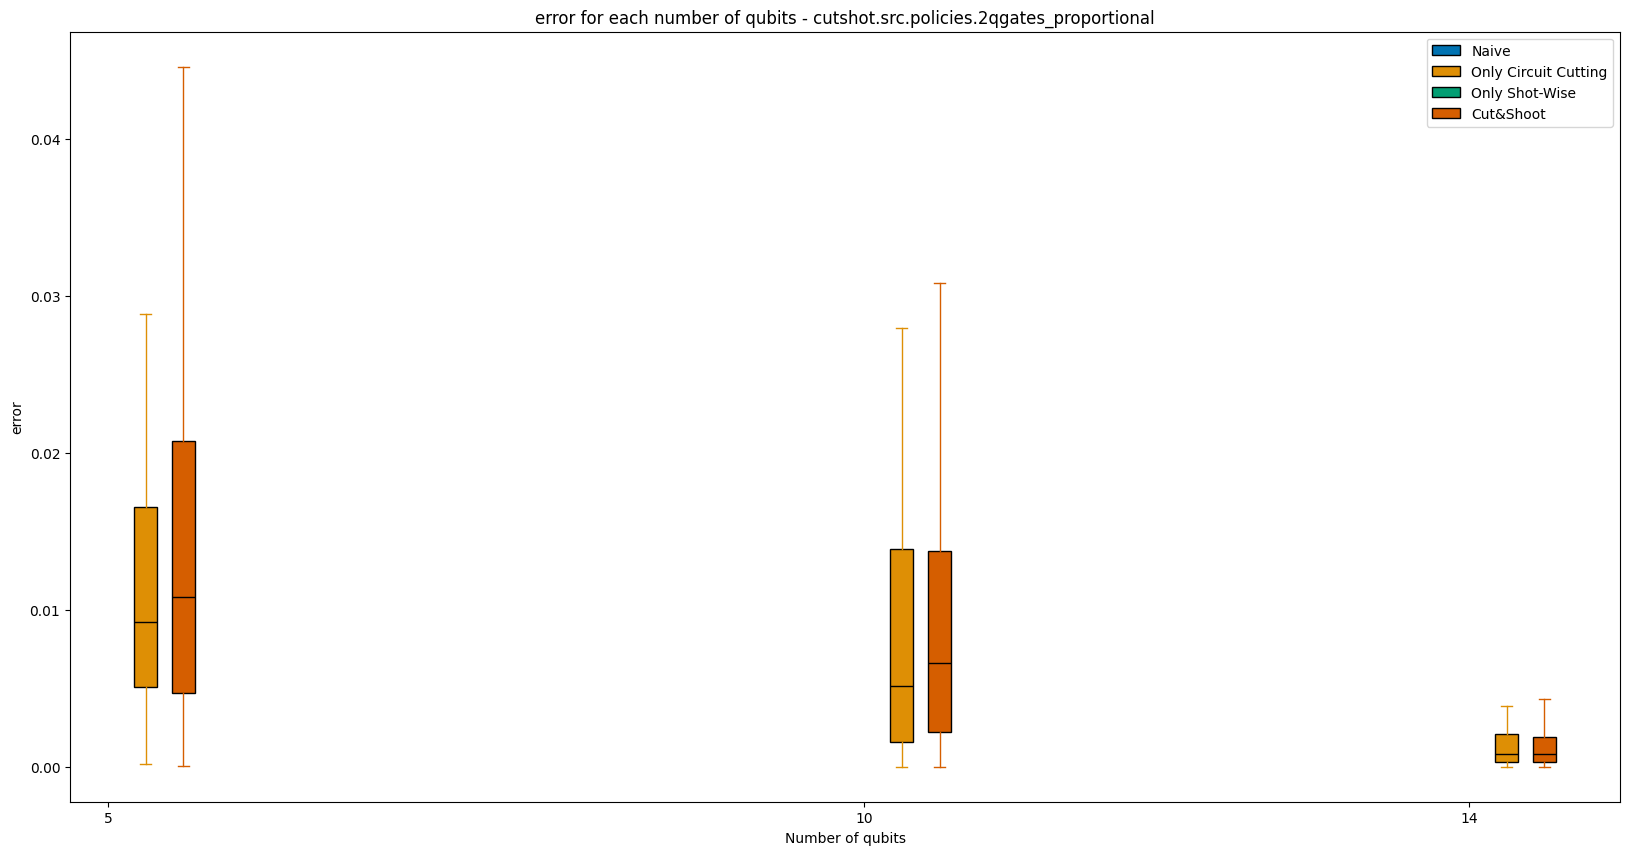

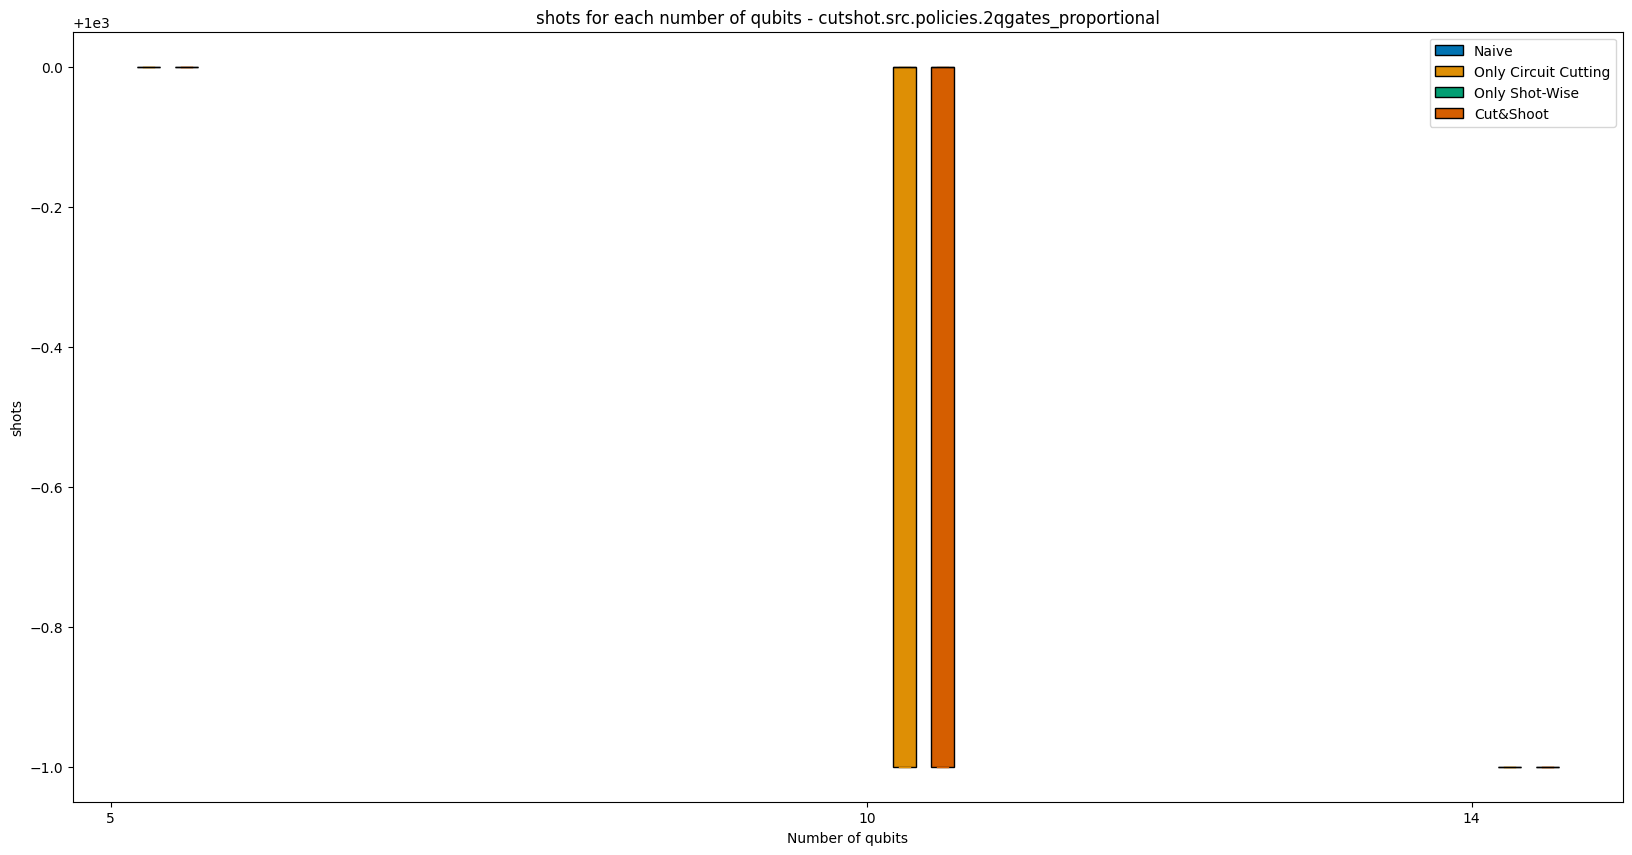

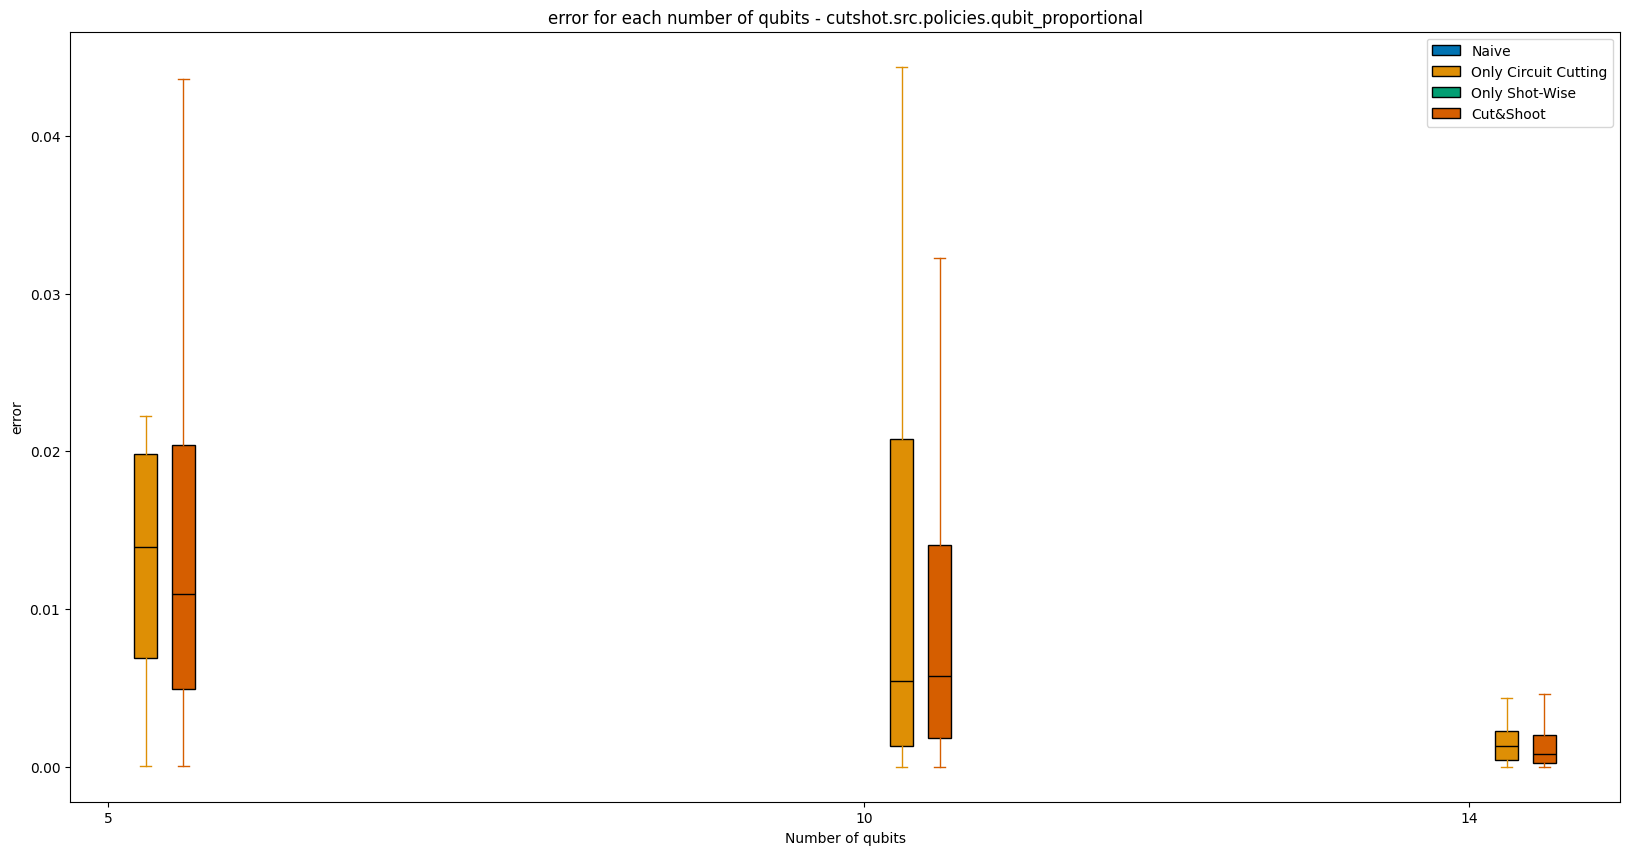

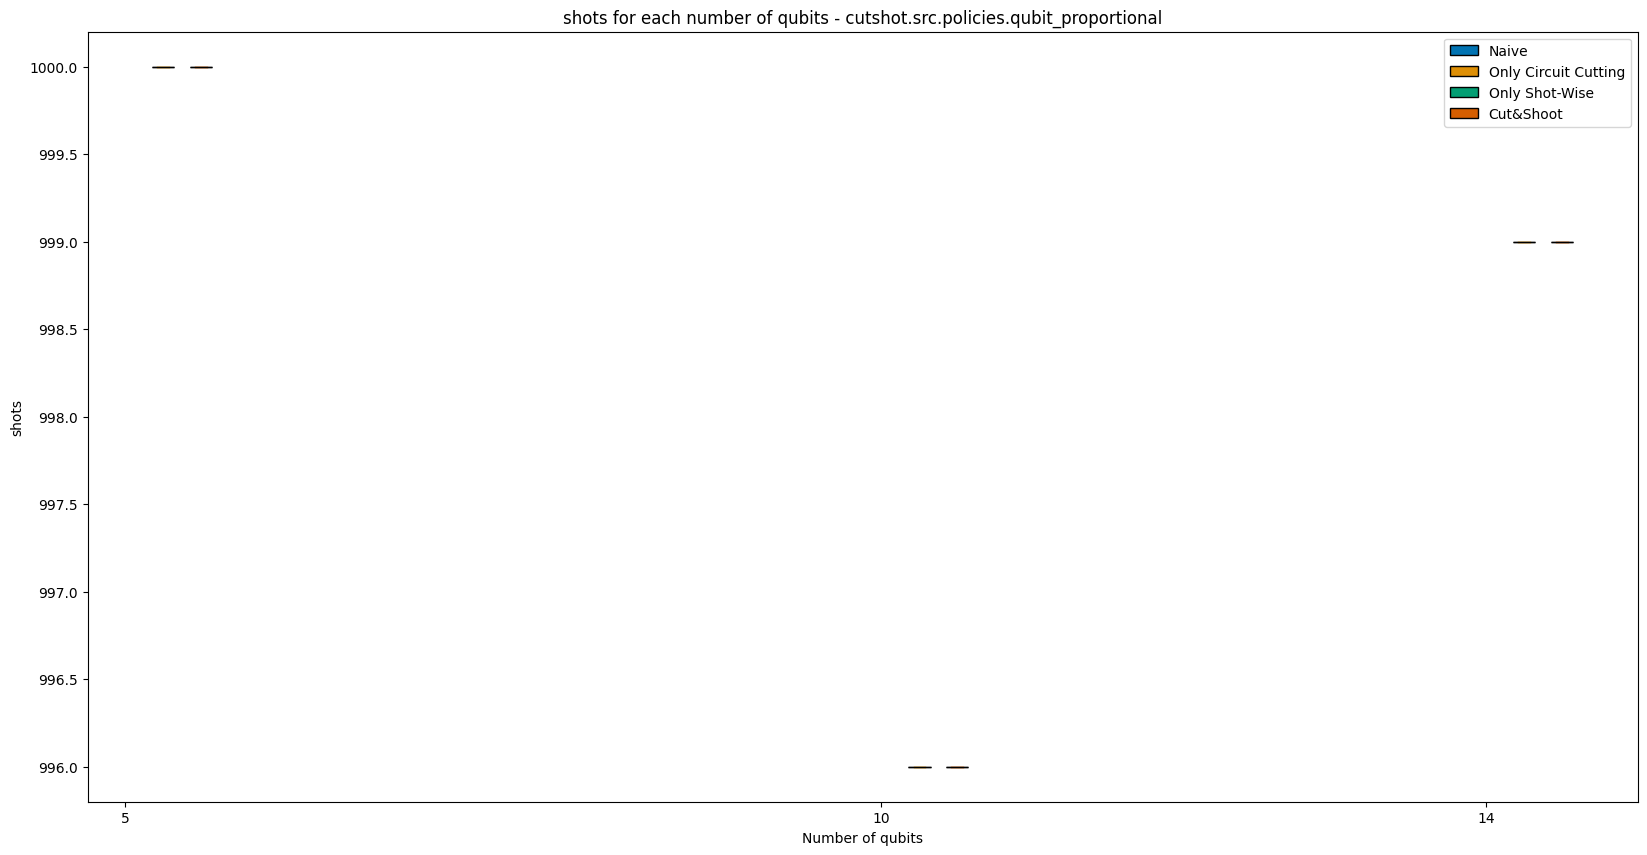

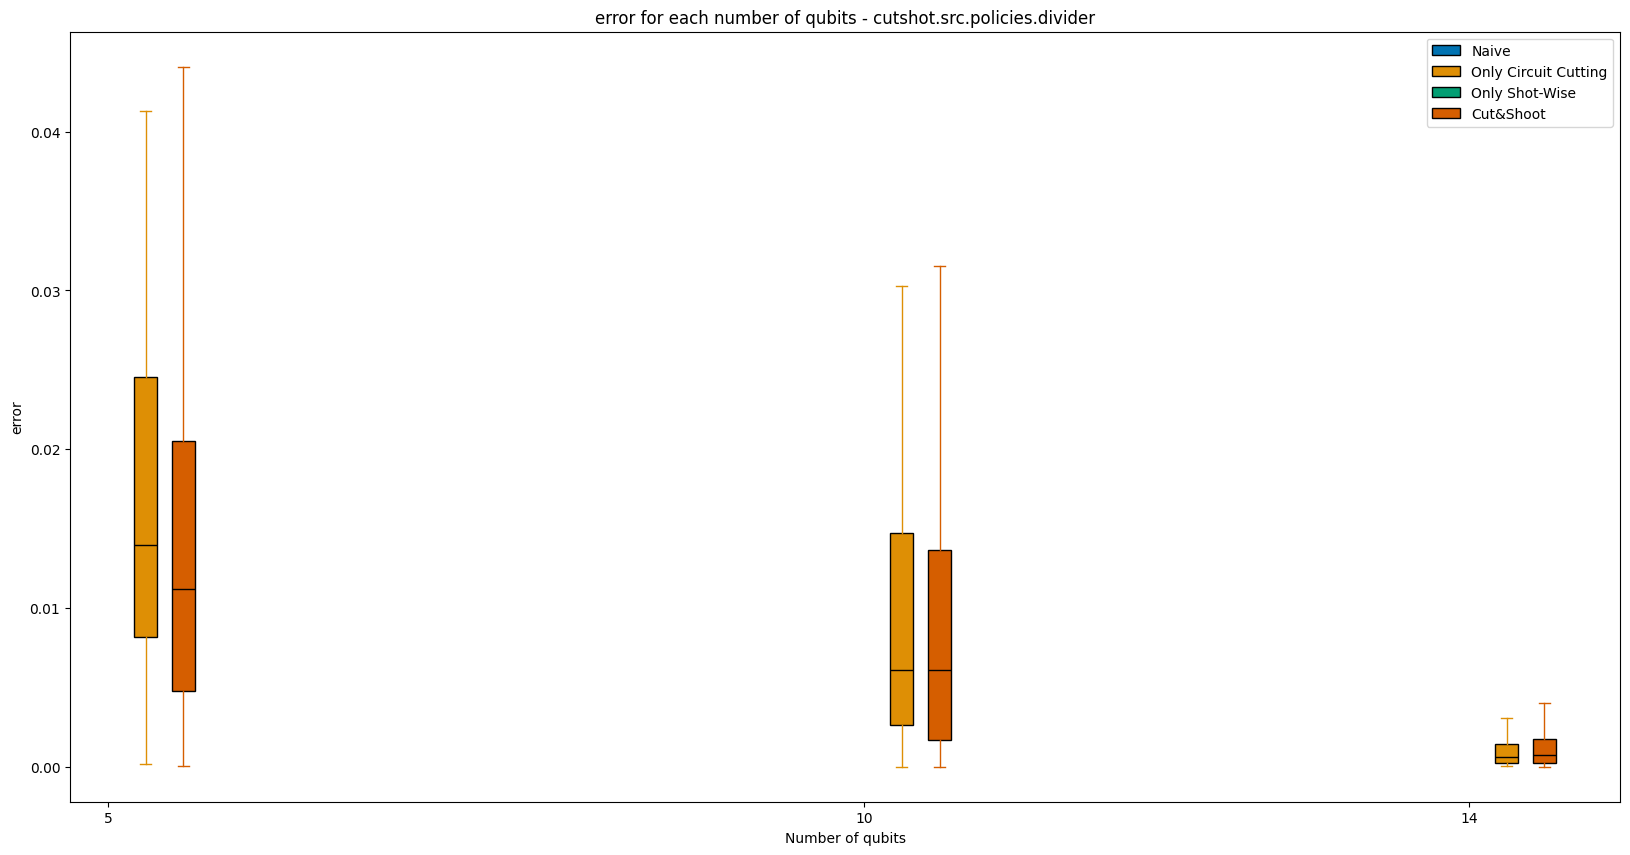

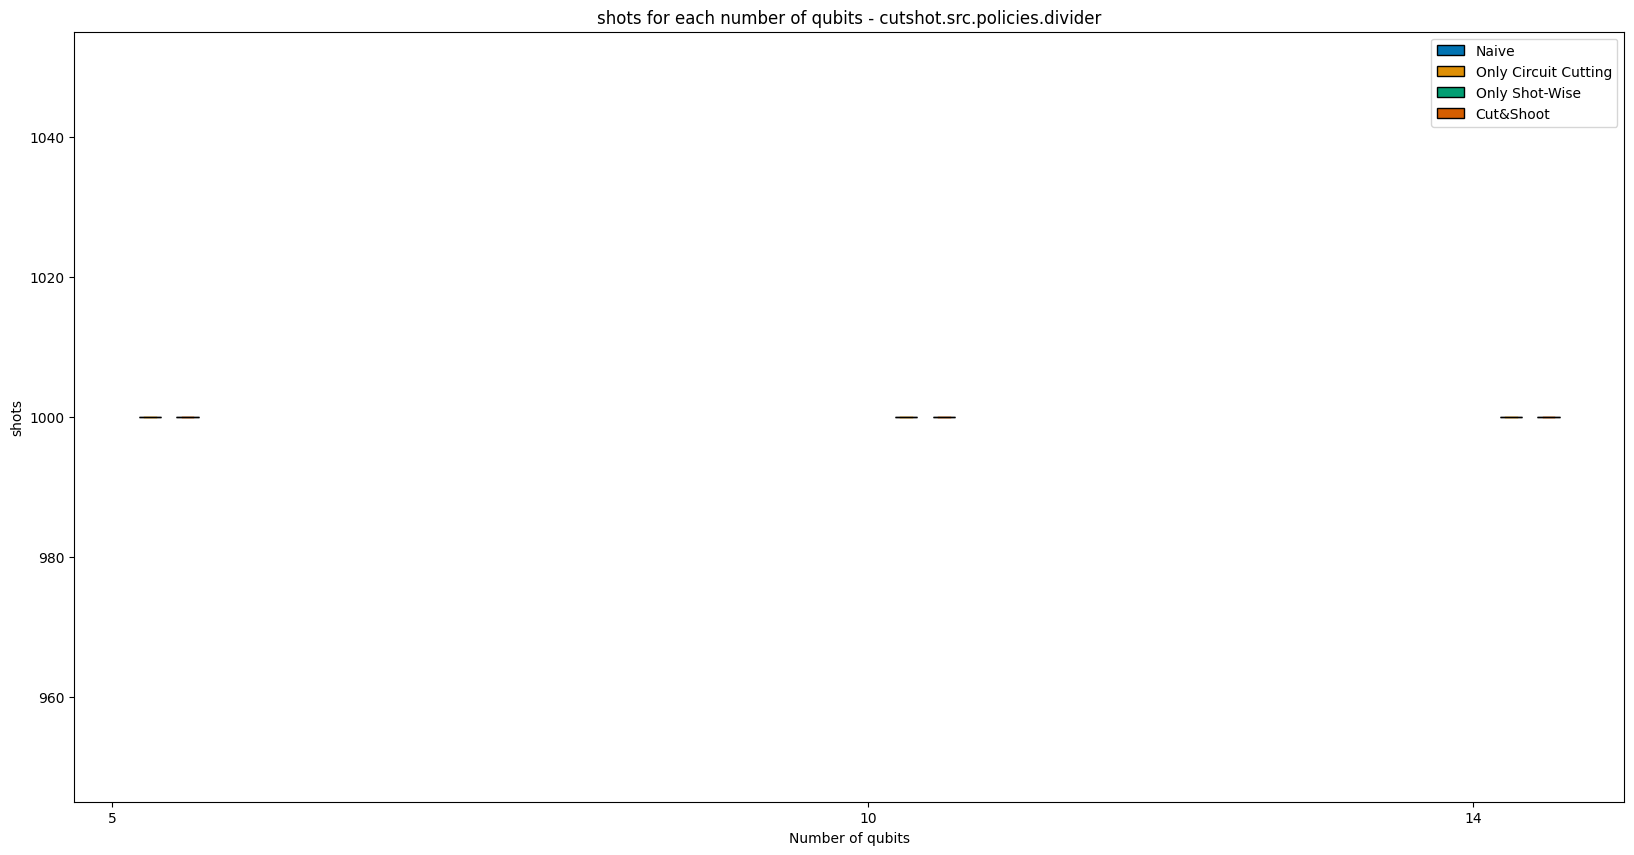

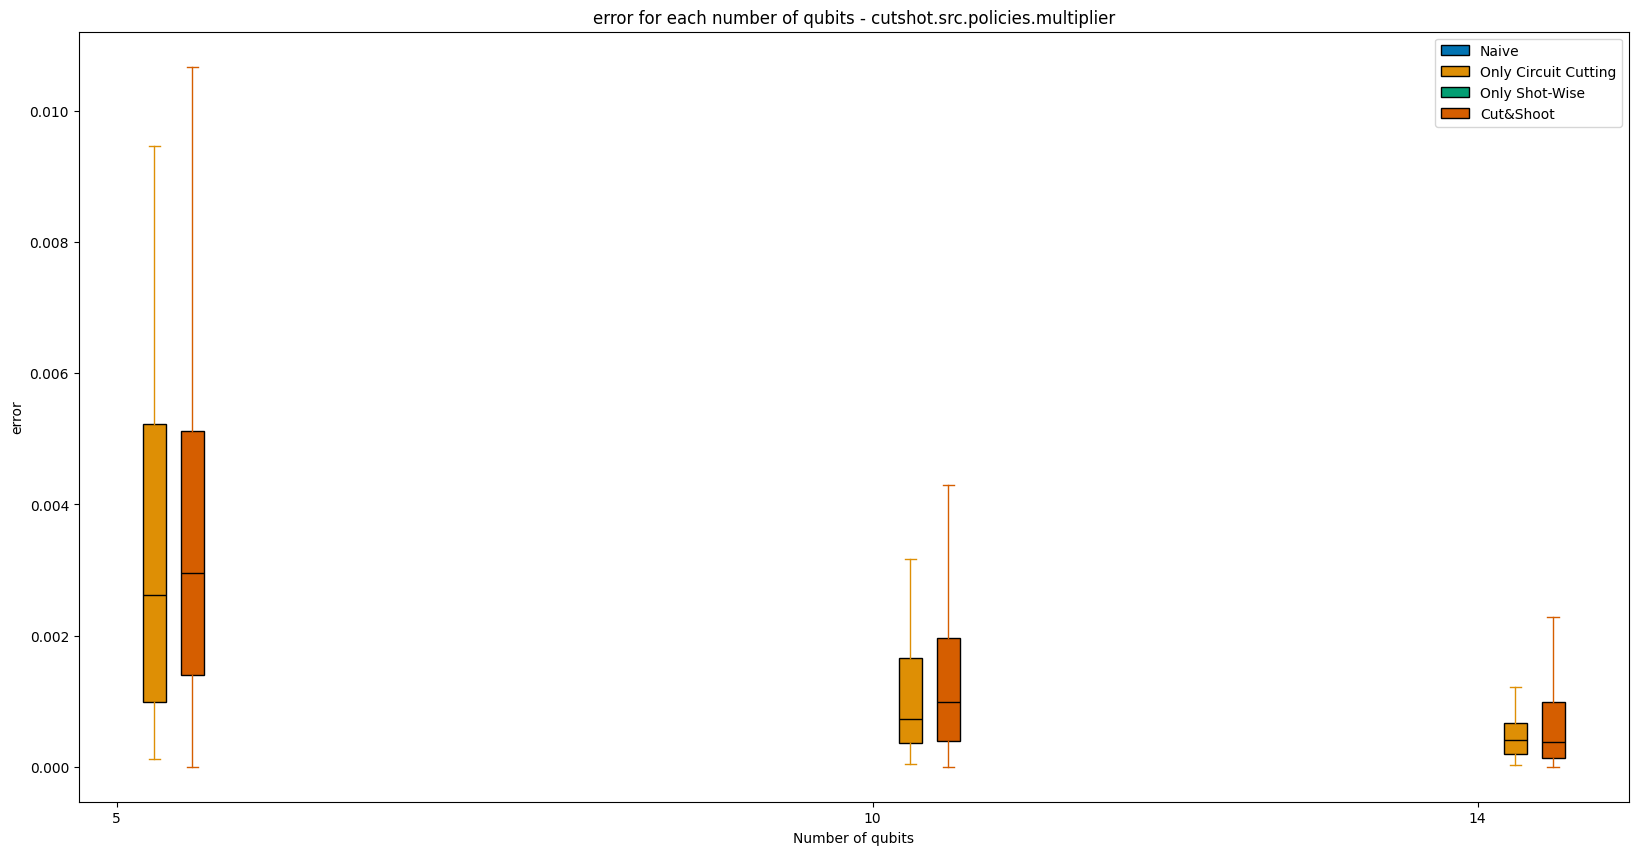

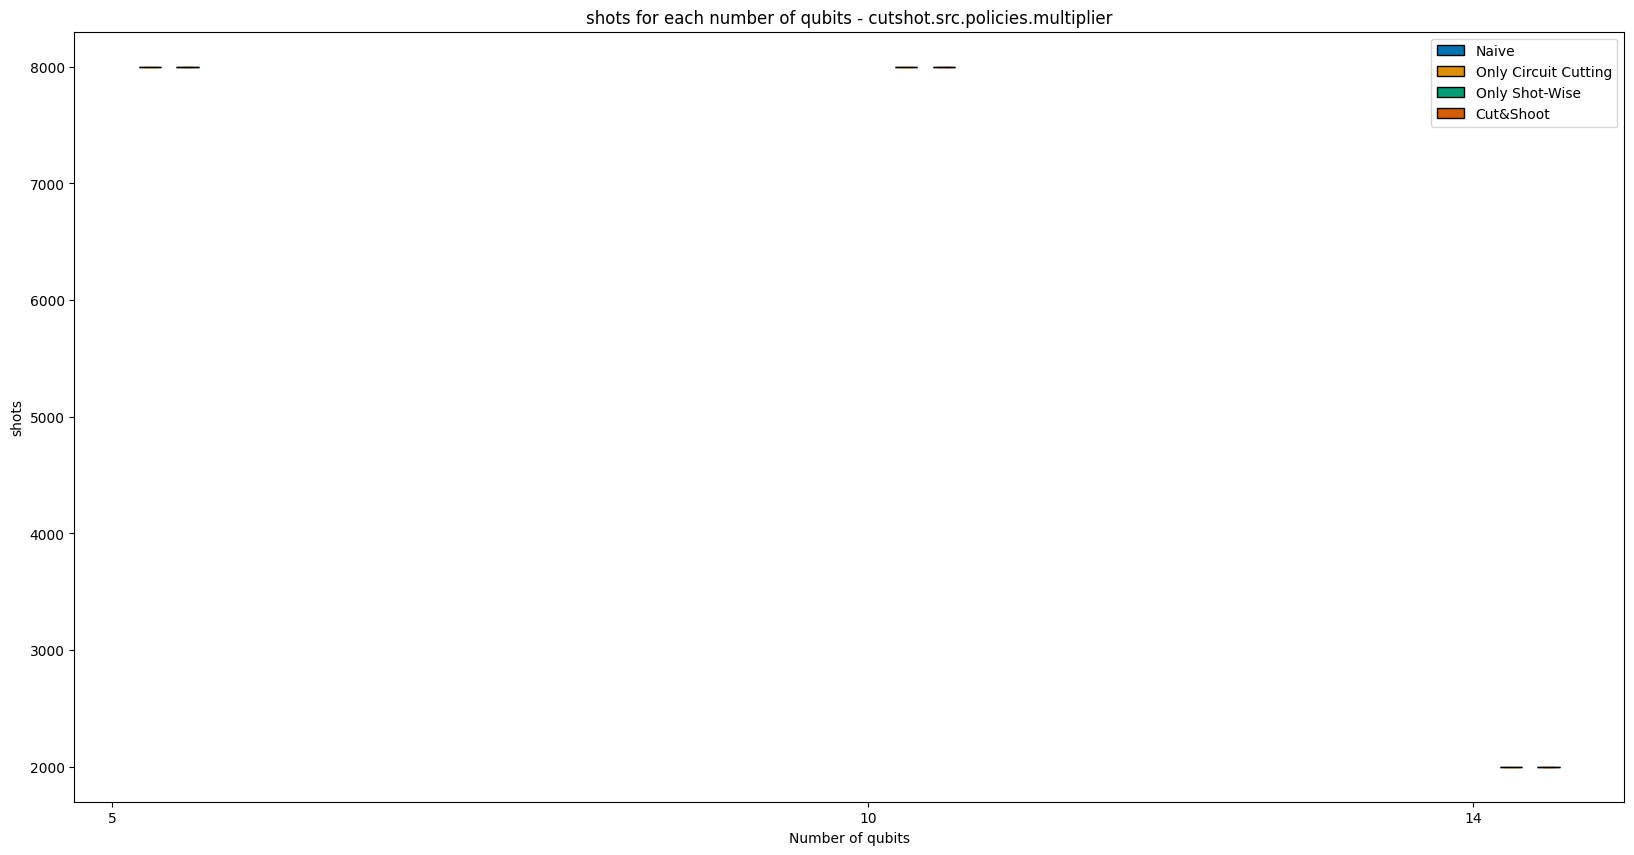

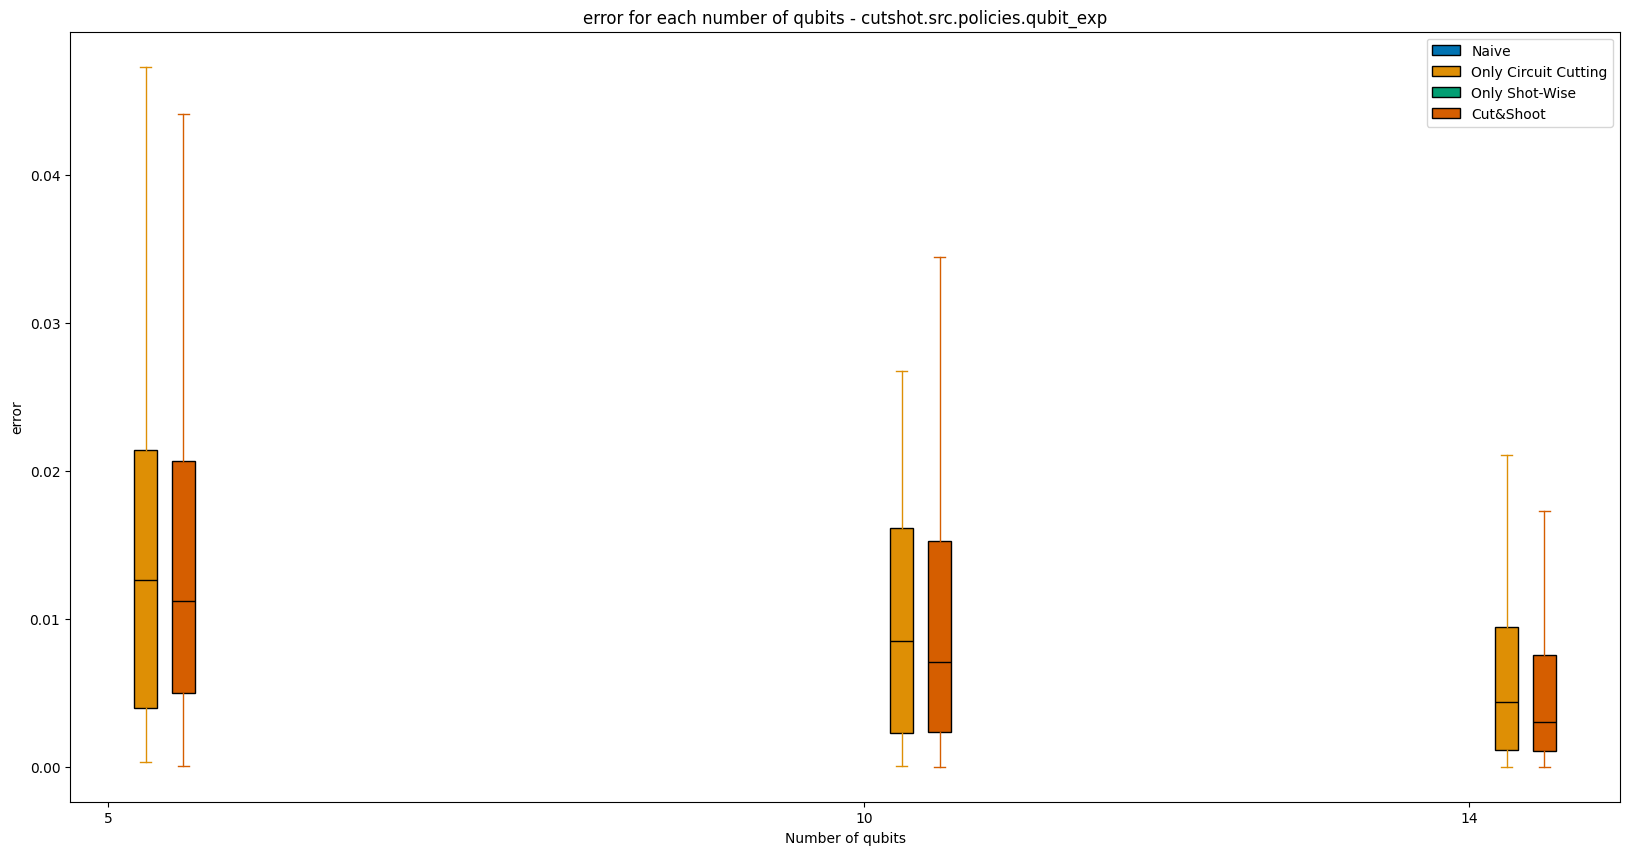

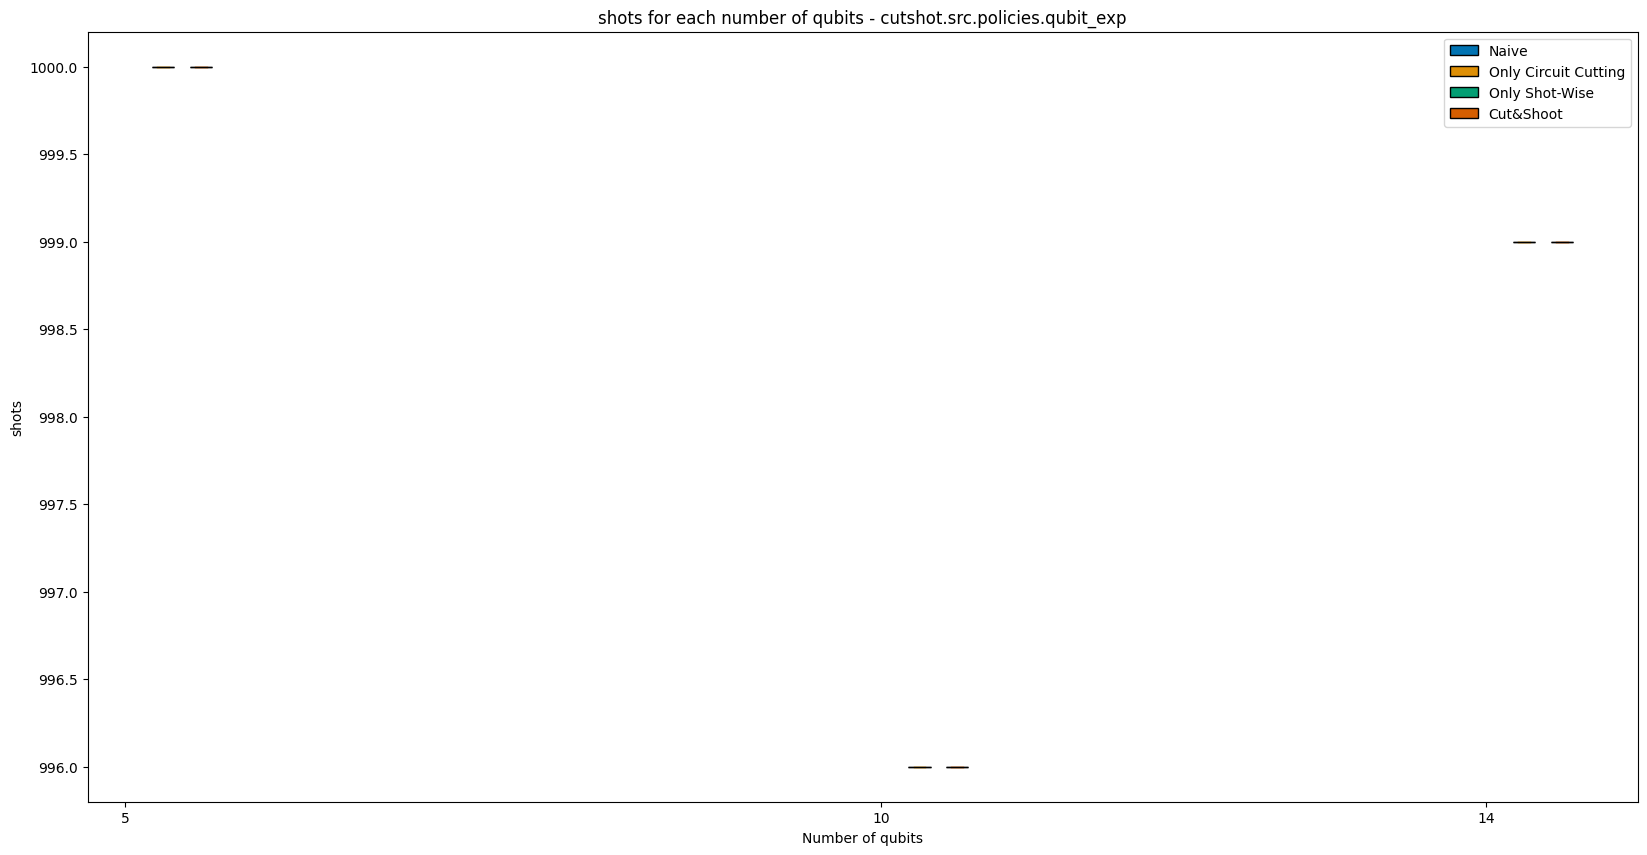

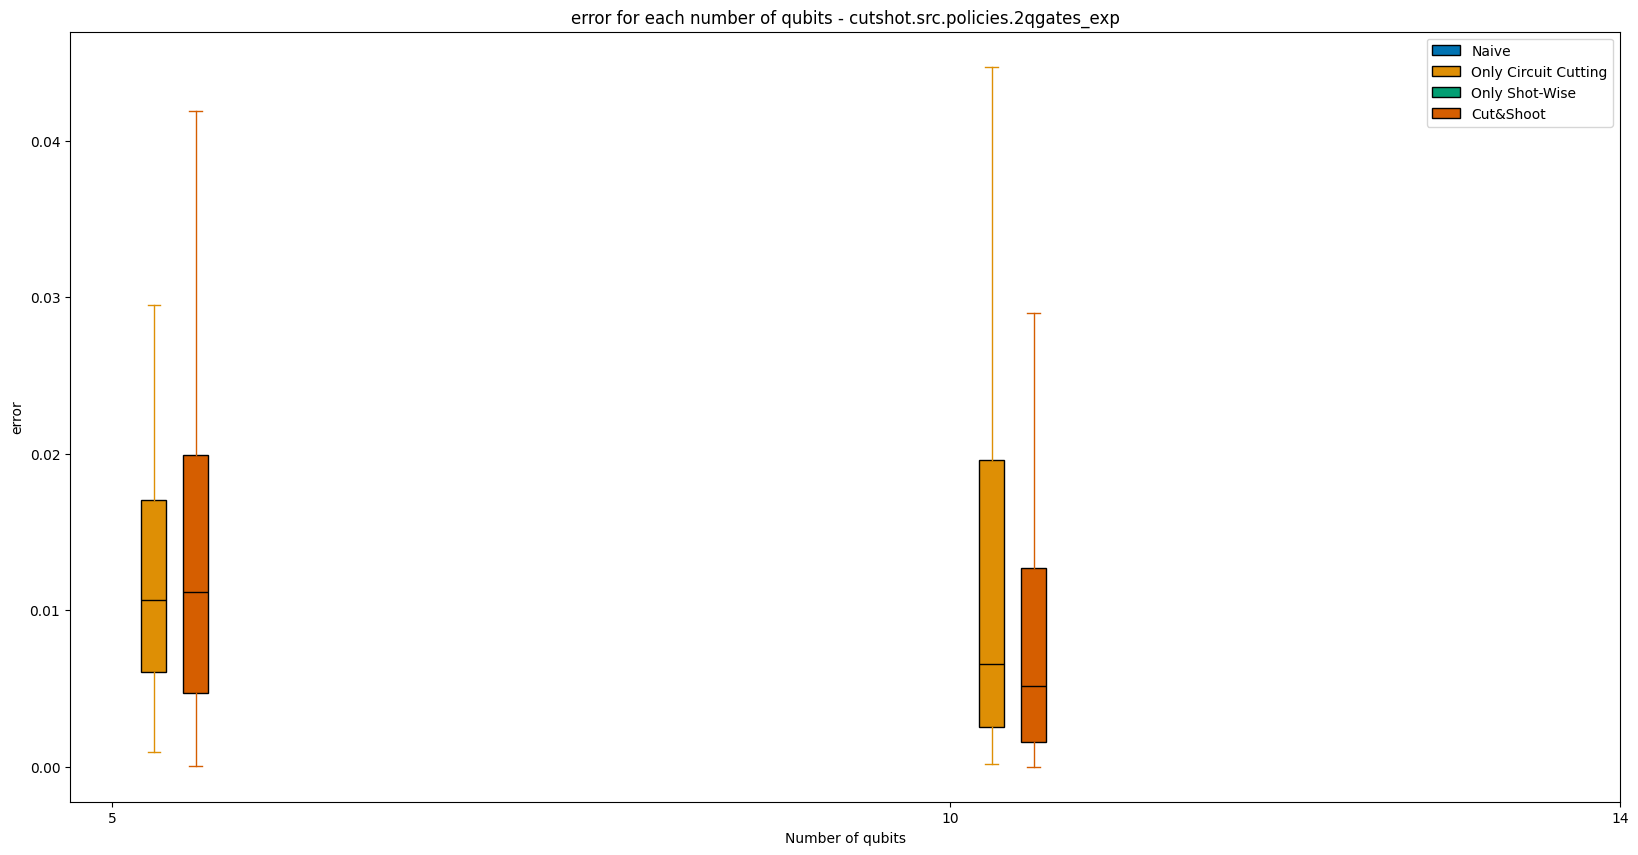

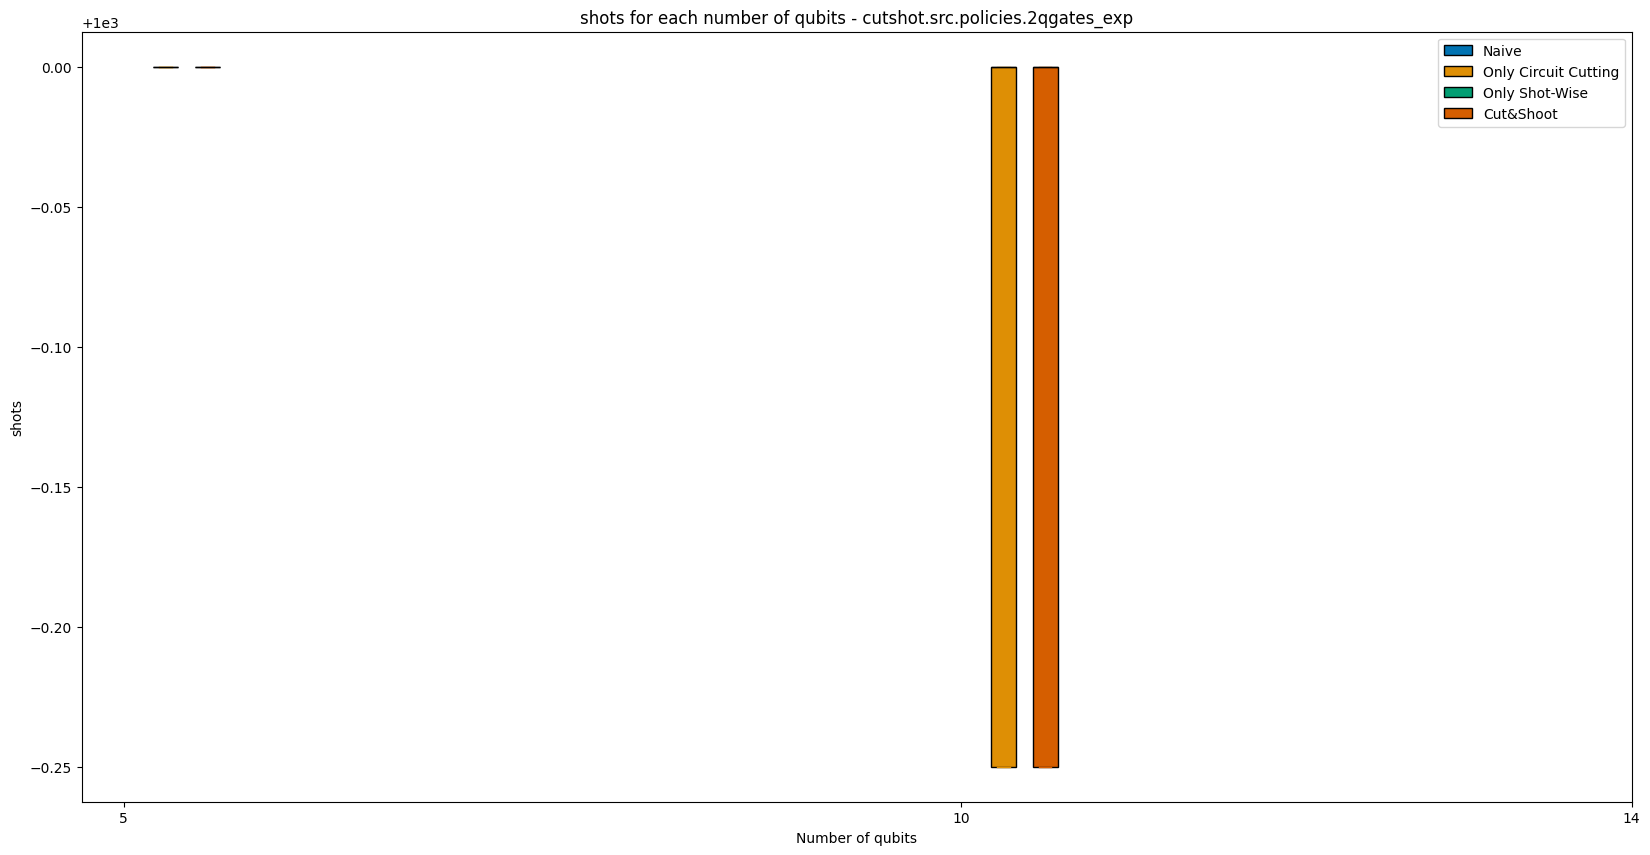

In [10]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    for attr in ["error", "shots"]:

        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)

        for qubits in exp_data_df["qubits"].unique():
            data = exp_data_df[(exp_data_df["qubits"] == qubits) & (exp_data_df["shots_allocation"] == sa)]
            offset = 0
            for strategy in data["strategy"].unique():
                data_strat = data[data["strategy"] == strategy]
                offset += 0.25
                color = colors[strategy]
                ax.boxplot(data_strat[attr], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
                
        ax.set_xlabel("Number of qubits")
        ax.set_ylabel(attr)
        ax.set_title(f"{attr} for each number of qubits - {sa}")
        ax.set_xticks(exp_data_df["qubits"].unique())
        ax.set_xticklabels(exp_data_df["qubits"].unique())
        ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
        
        plt.savefig(plots_dir + f"{attr}_num_qubits_{sa}.png")
        plt.show()




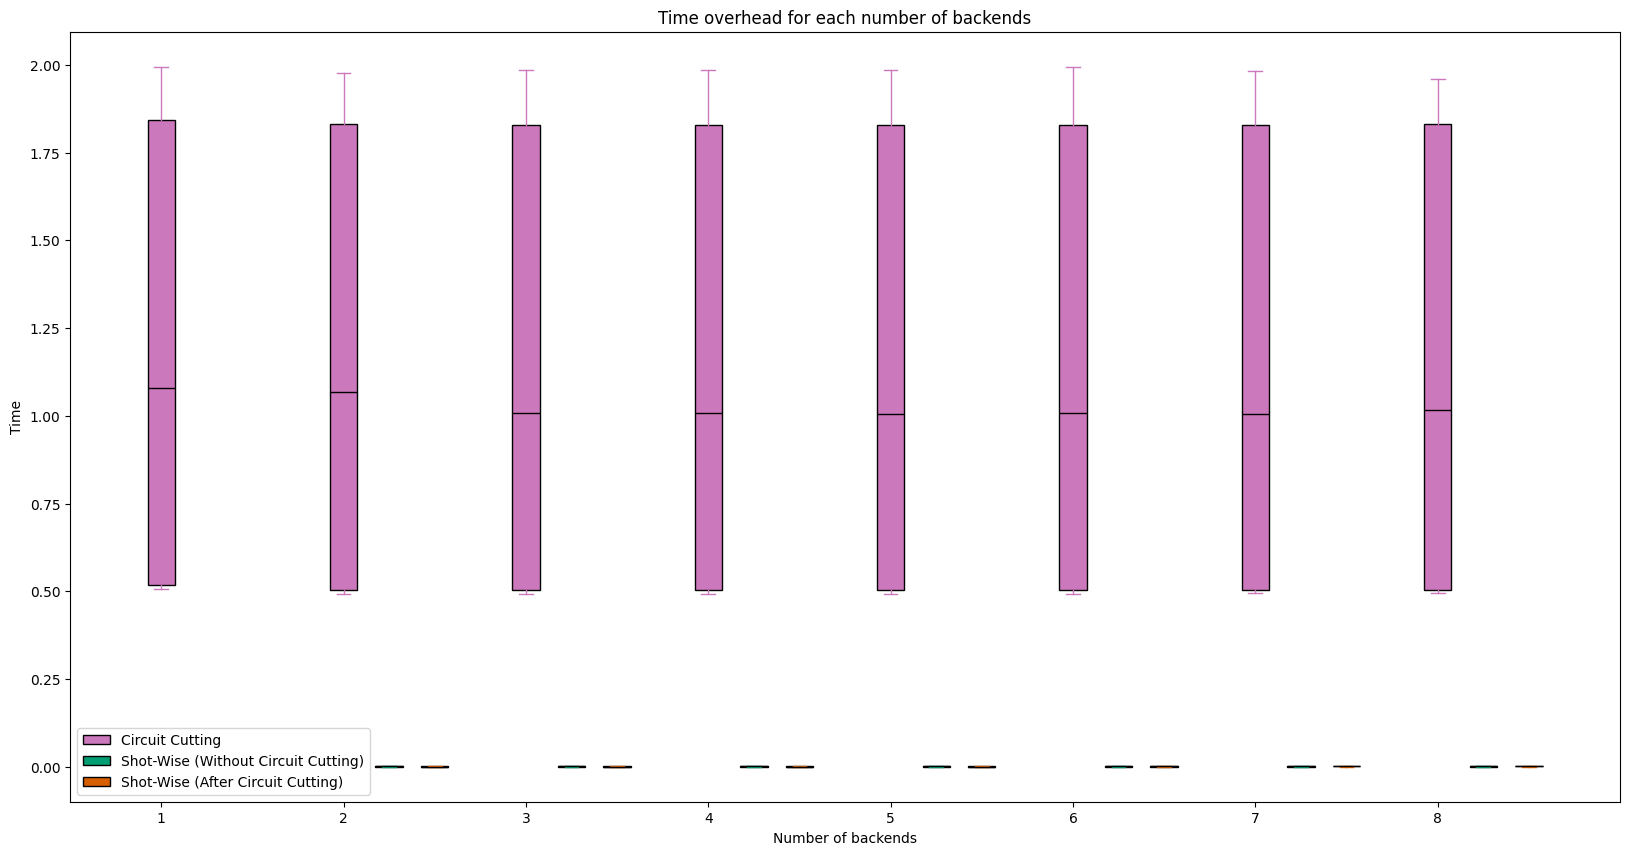

In [11]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

strategies = ["cc_all", "sw_without", "sw_after"]

for num_backends in exp_data_df["num_backends"].unique():
    data = exp_data_df[exp_data_df["num_backends"] == num_backends]
    # circuit cutting overhead is not nan
    circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
    
    shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
    shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    
    offset = 0
    color = colors["cc_all"]
    ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    offset += 0.25
        
    if not shot_wise_overhead_without_cc.empty:
        color = colors["sw_without"]
        ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
    if not shot_wise_overhead_with_cc.empty:
        color = colors["sw_after"]
        ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
    
ax.set_xlabel("Number of backends")
ax.set_ylabel("Time")
ax.set_title("Time overhead for each number of backends")
ax.set_xticks(exp_data_df["num_backends"].unique())
ax.set_xticklabels(exp_data_df["num_backends"].unique())

ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in strategies], [legend[strategy] for strategy in strategies])


plt.savefig(plots_dir + f"time_overhead_num_backends.png")
plt.show()

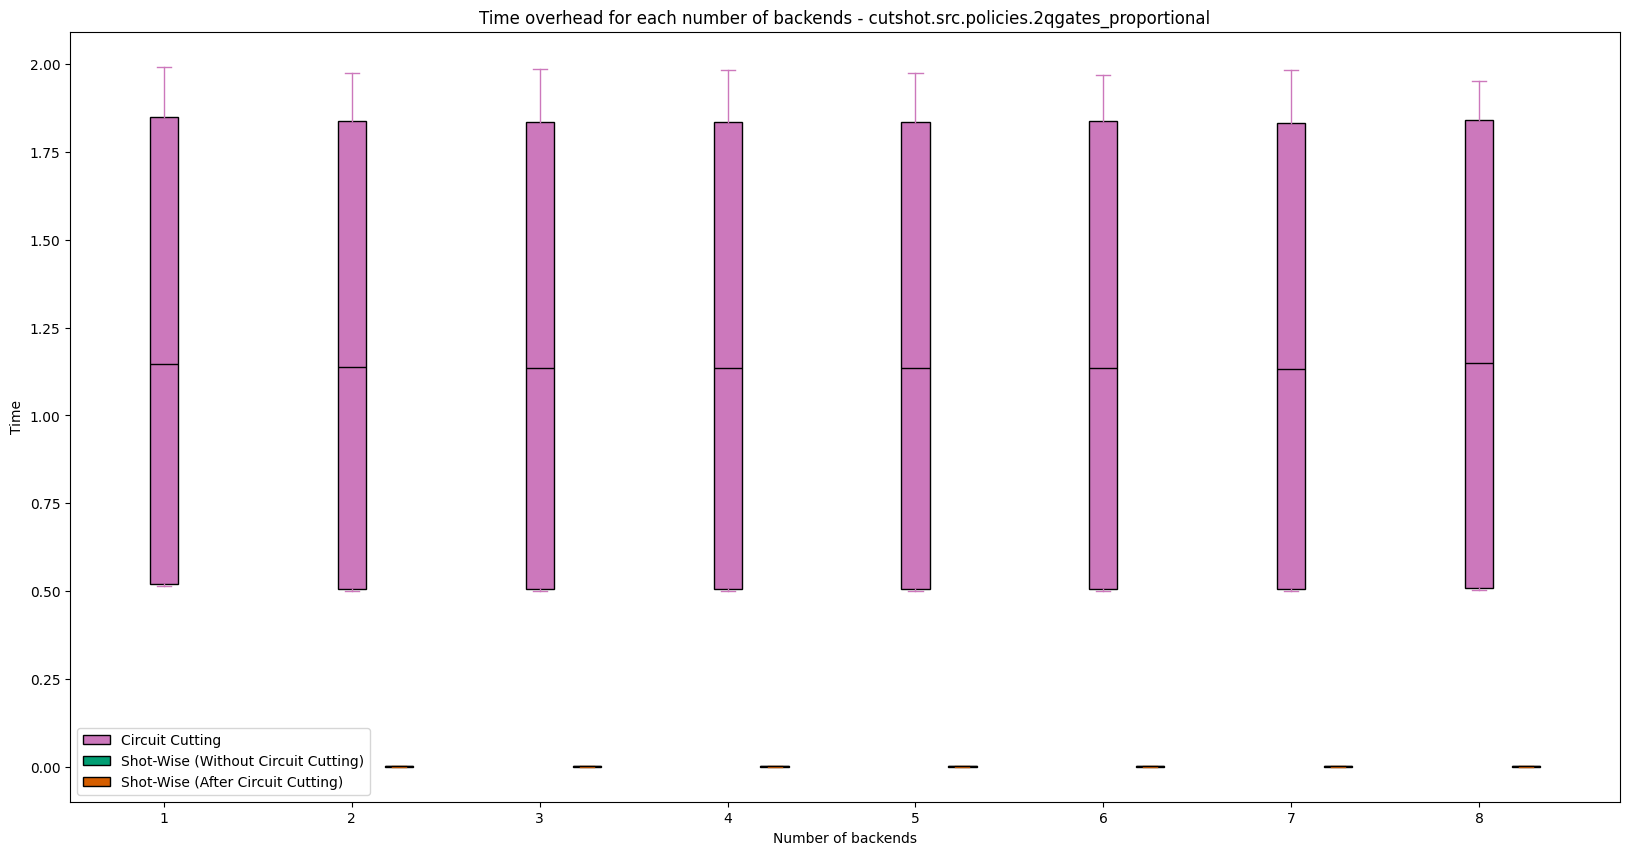

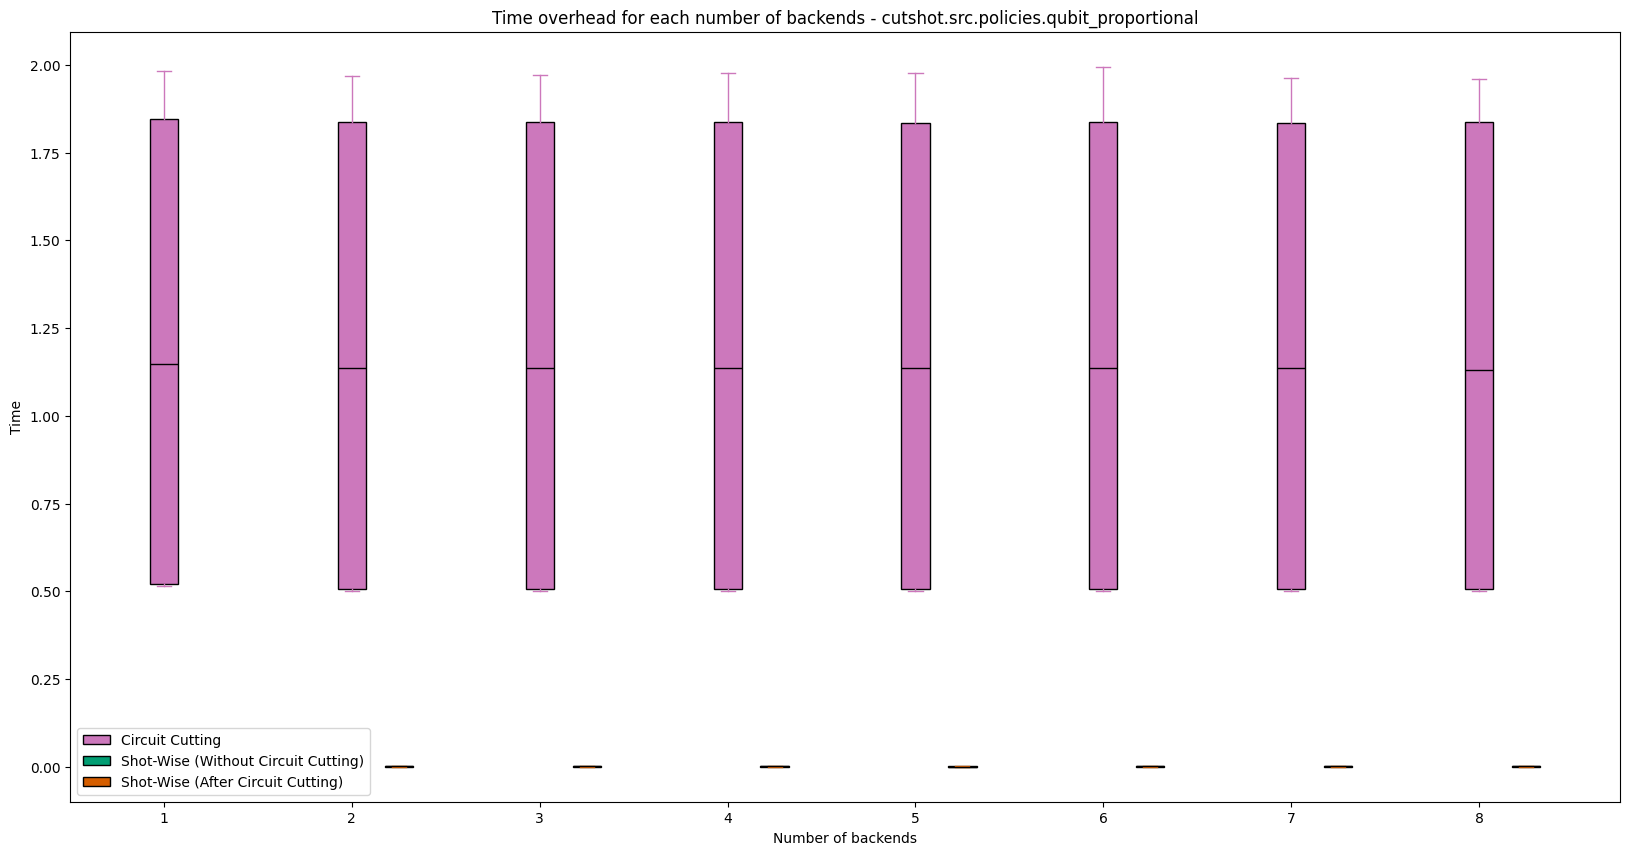

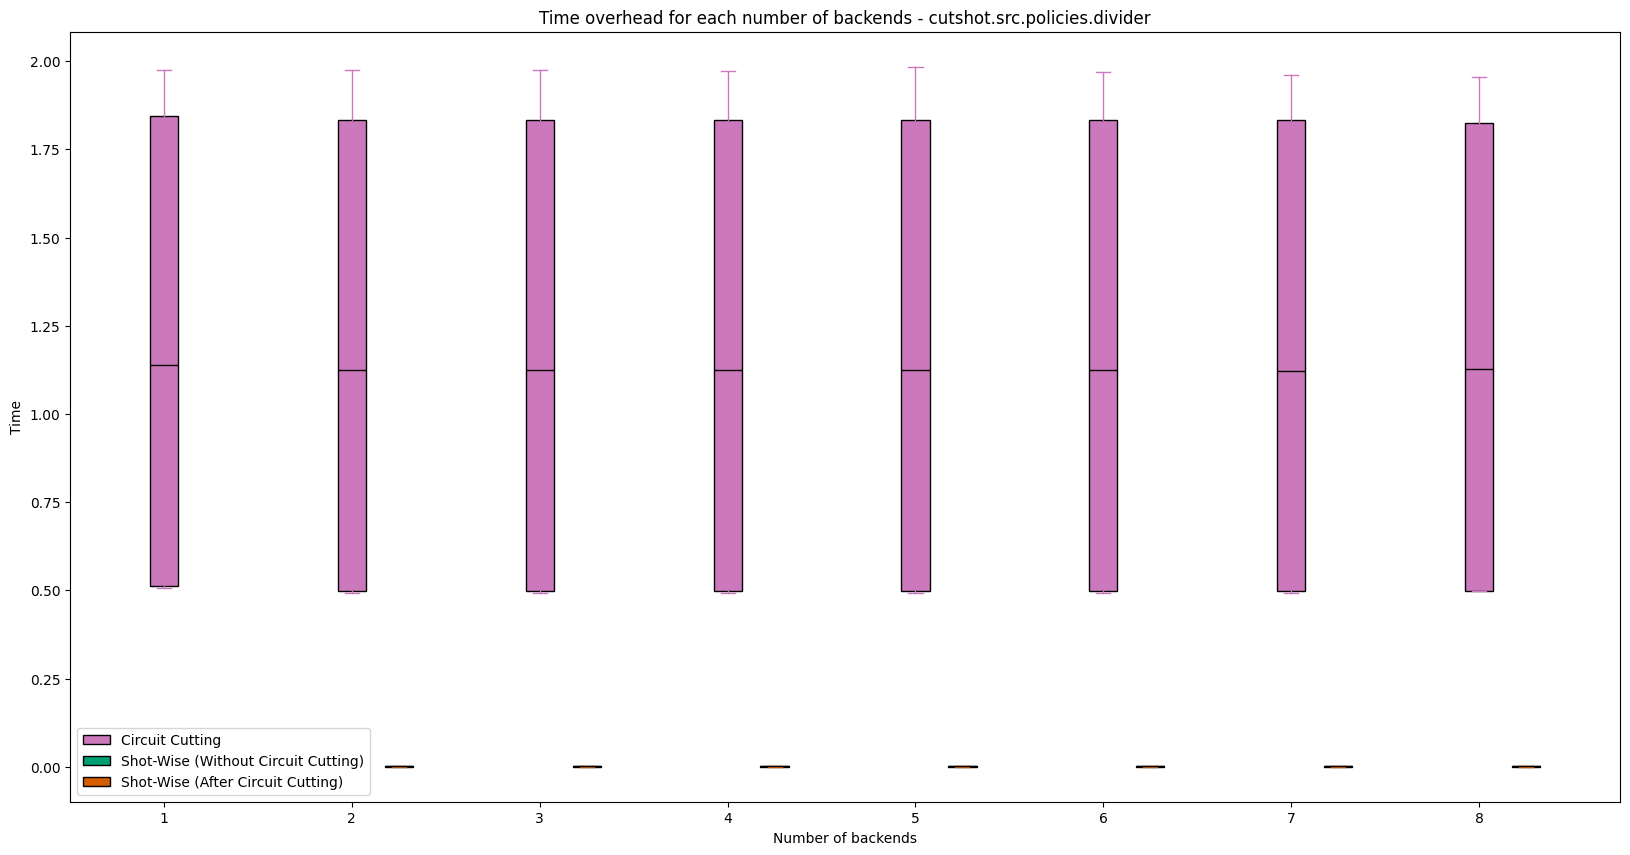

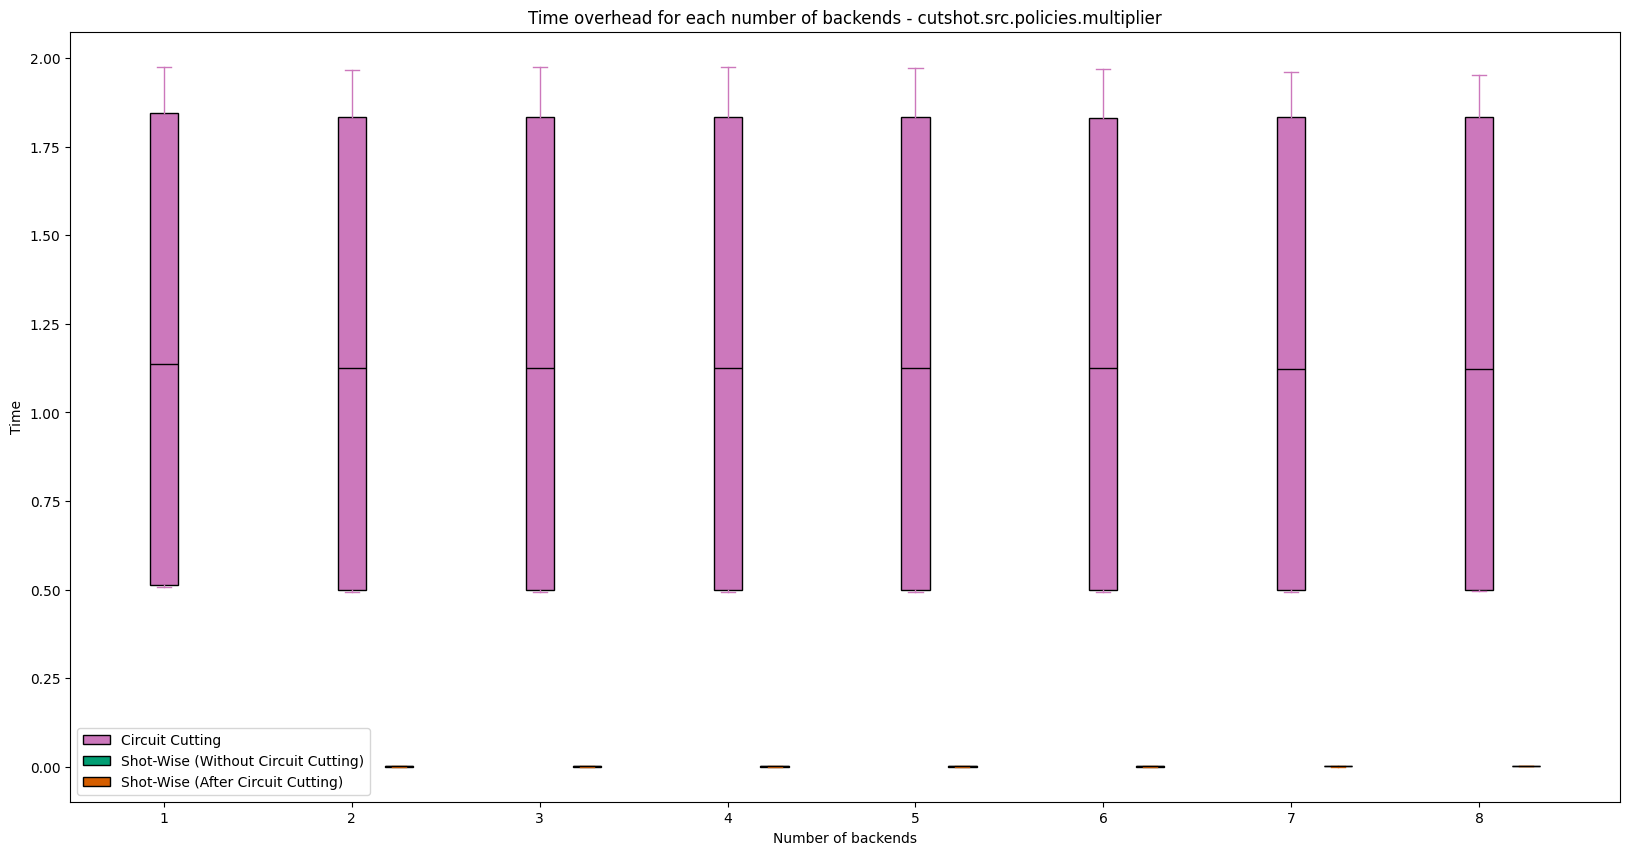

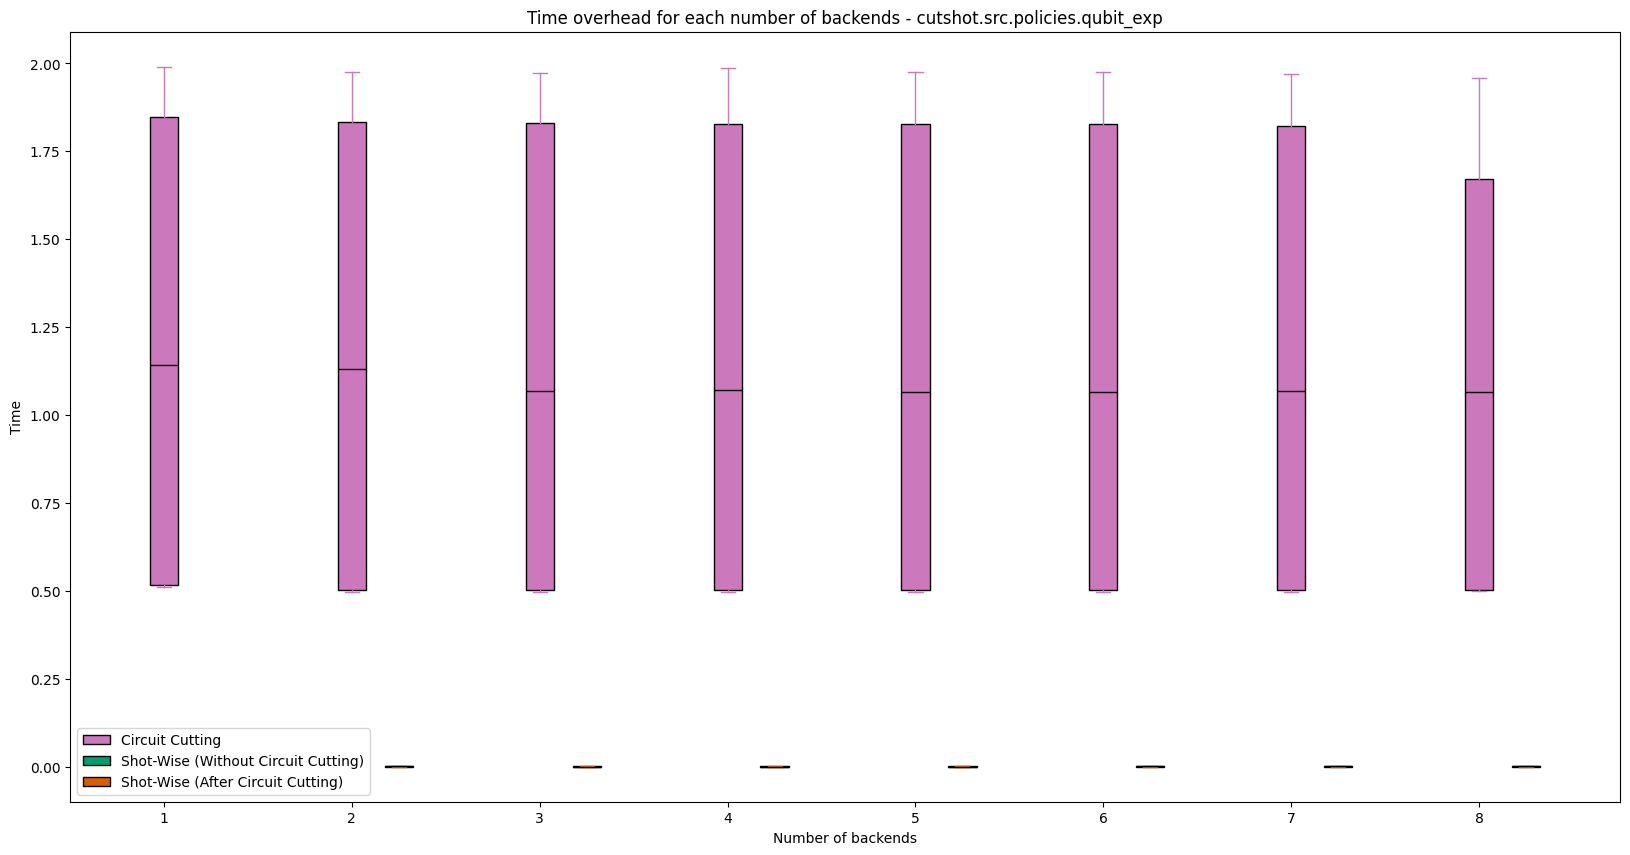

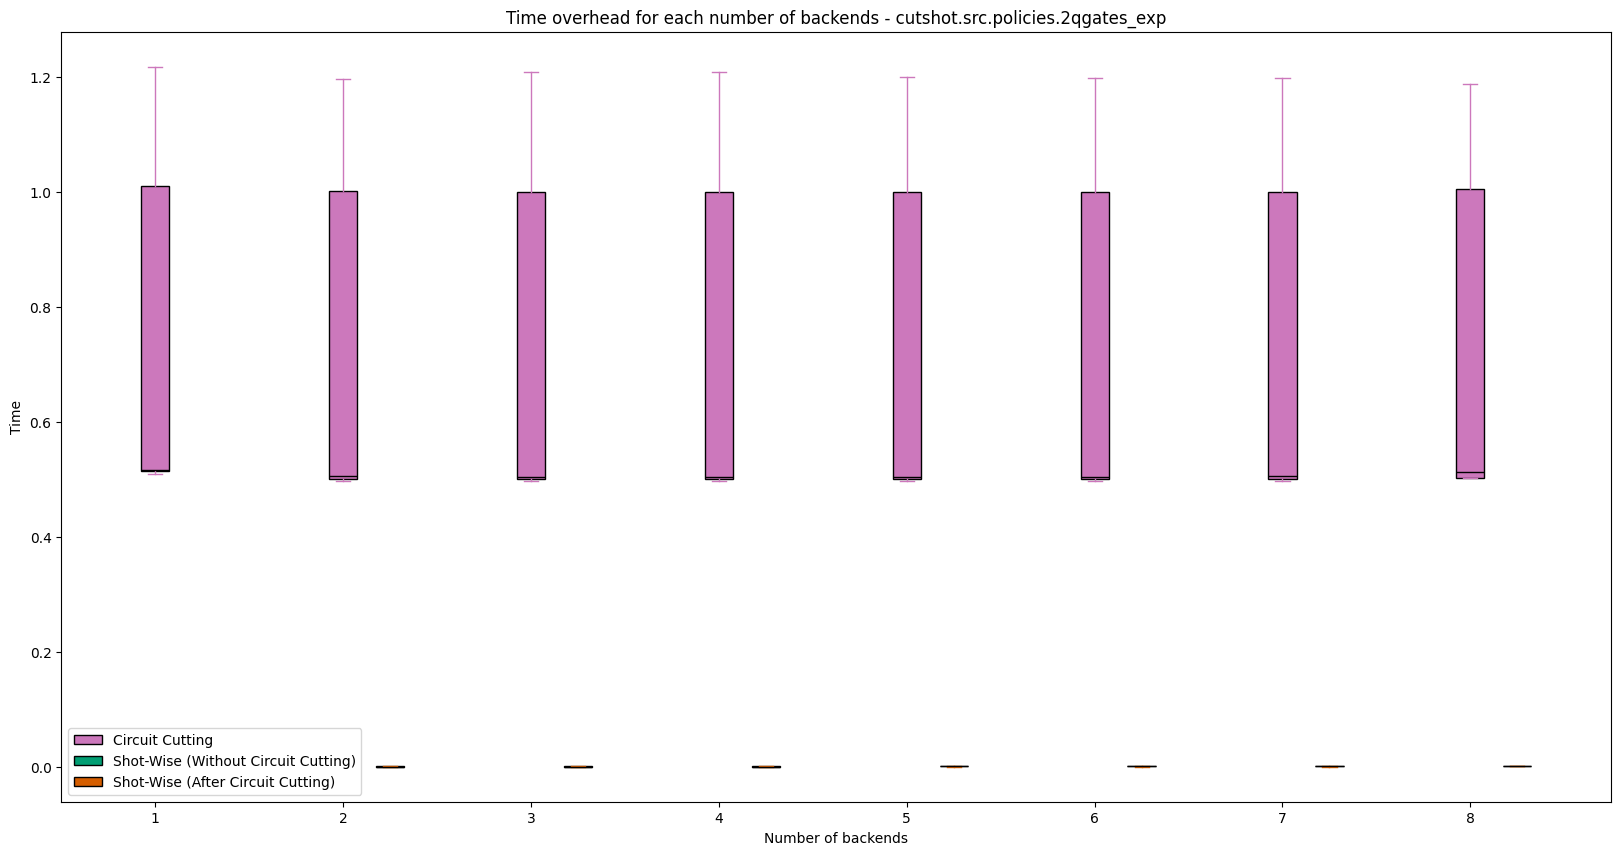

In [12]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    strategies = ["cc_all", "sw_without", "sw_after"]

    for num_backends in exp_data_df["num_backends"].unique():
        data = exp_data_df[(exp_data_df["num_backends"] == num_backends) & (exp_data_df["shots_allocation"] == sa)]
        # circuit cutting overhead is not nan
        circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
        
        shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
        shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        
        offset = 0
        color = colors["cc_all"]
        ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
            
        if not shot_wise_overhead_without_cc.empty:
            color = colors["sw_without"]
            ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            offset += 0.25
            
        if not shot_wise_overhead_with_cc.empty:
            color = colors["sw_after"]
            ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
            offset += 0.25
            
        
    ax.set_xlabel("Number of backends")
    ax.set_ylabel("Time")
    ax.set_title("Time overhead for each number of backends - " + sa)
    ax.set_xticks(exp_data_df["num_backends"].unique())
    ax.set_xticklabels(exp_data_df["num_backends"].unique())

    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in strategies], [legend[strategy] for strategy in strategies])

    
    plt.savefig(plots_dir + f"time_overhead_num_backends_{sa}.png")
    plt.show()

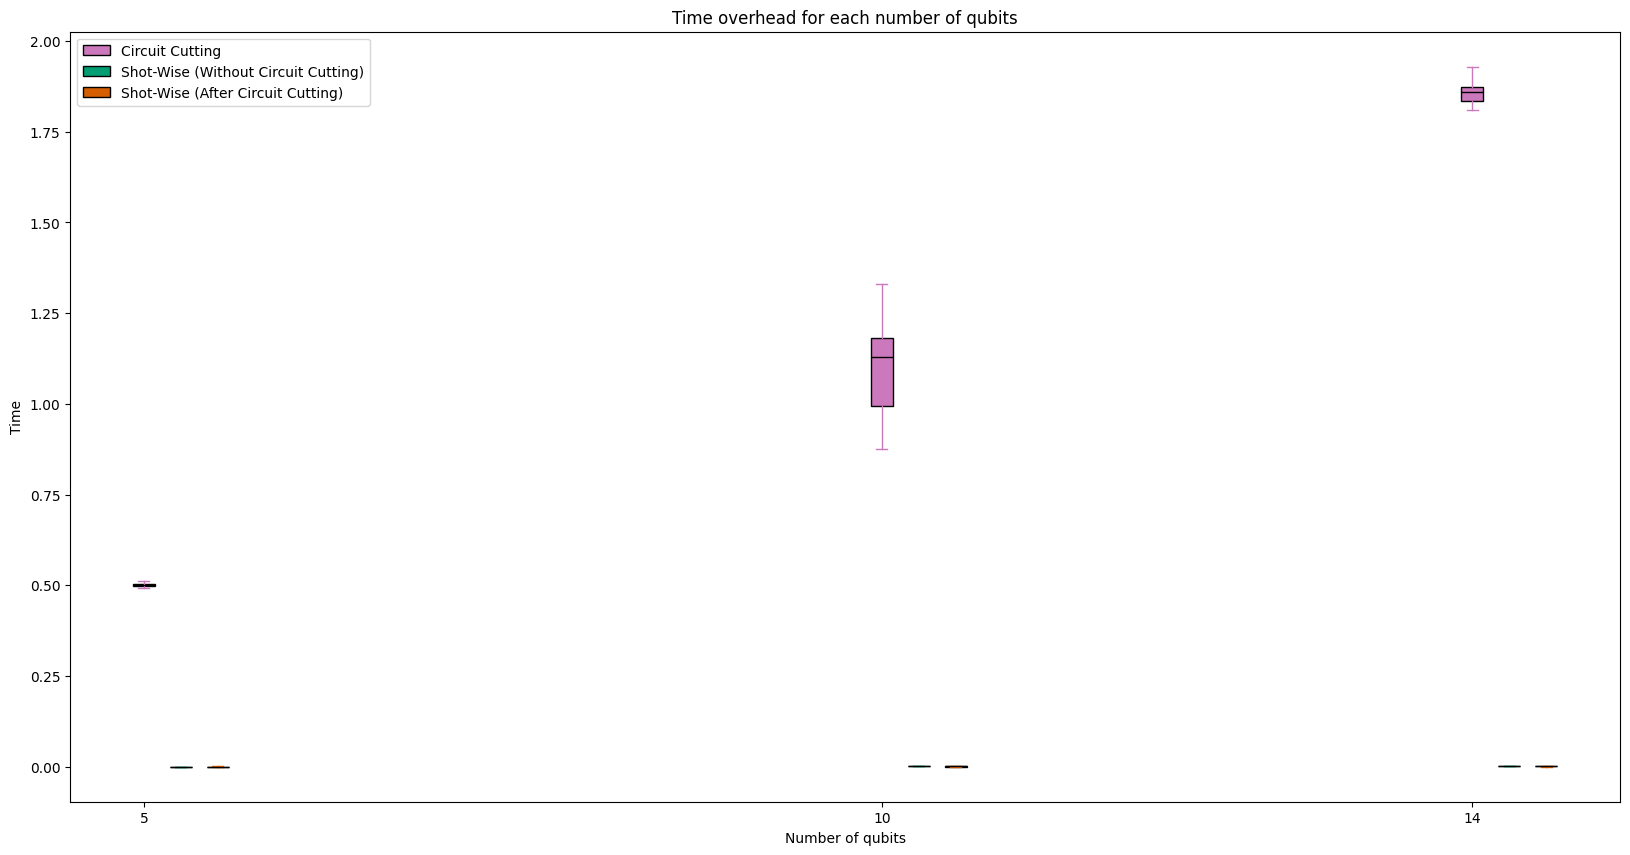

In [13]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

strategies = ["cc_all", "sw_without", "sw_after"]

for qubits in exp_data_df["qubits"].unique():
    data = exp_data_df[exp_data_df["qubits"] == qubits]
    # circuit cutting overhead is not nan
    circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
    
    shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
    shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
    
    offset = 0
    color = colors["cc_all"]
    ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    offset += 0.25
    
    color = colors["sw_without"]
    ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    offset += 0.25
    
    color = colors["sw_after"]
    ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    offset += 0.25

    
ax.set_xlabel("Number of qubits")
ax.set_ylabel("Time")
ax.set_title("Time overhead for each number of qubits")
ax.set_xticks(exp_data_df["qubits"].unique())
ax.set_xticklabels(exp_data_df["qubits"].unique())
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["cc_all", "sw_without", "sw_after"]], [legend[strategy] for strategy in ["cc_all", "sw_without", "sw_after"]])

plt.savefig(plots_dir + f"time_overhead_num_qubits.png")
plt.show()

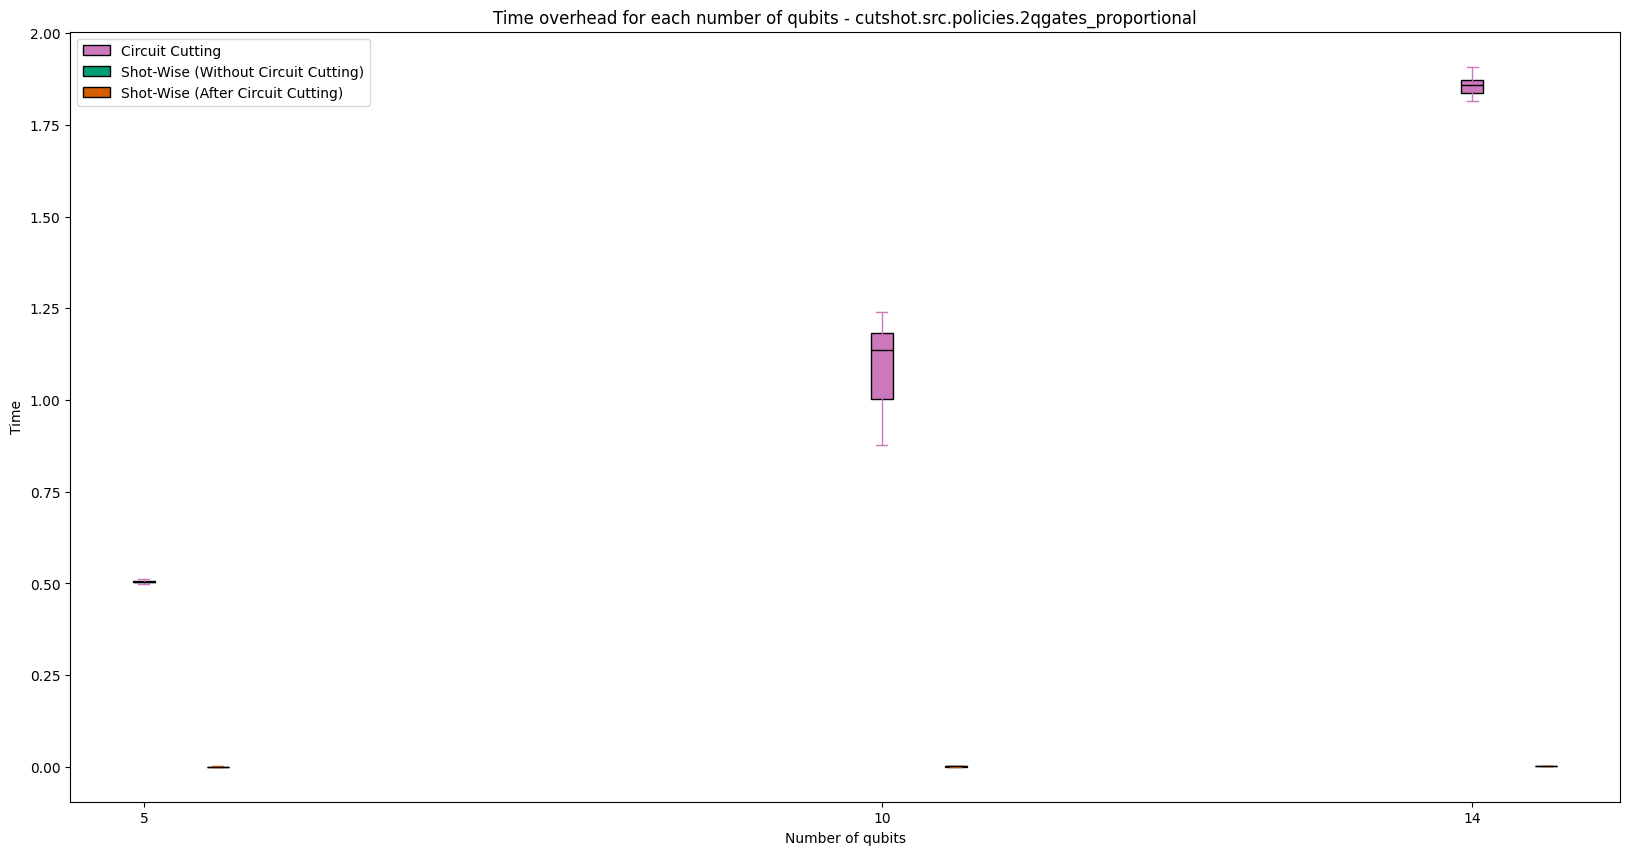

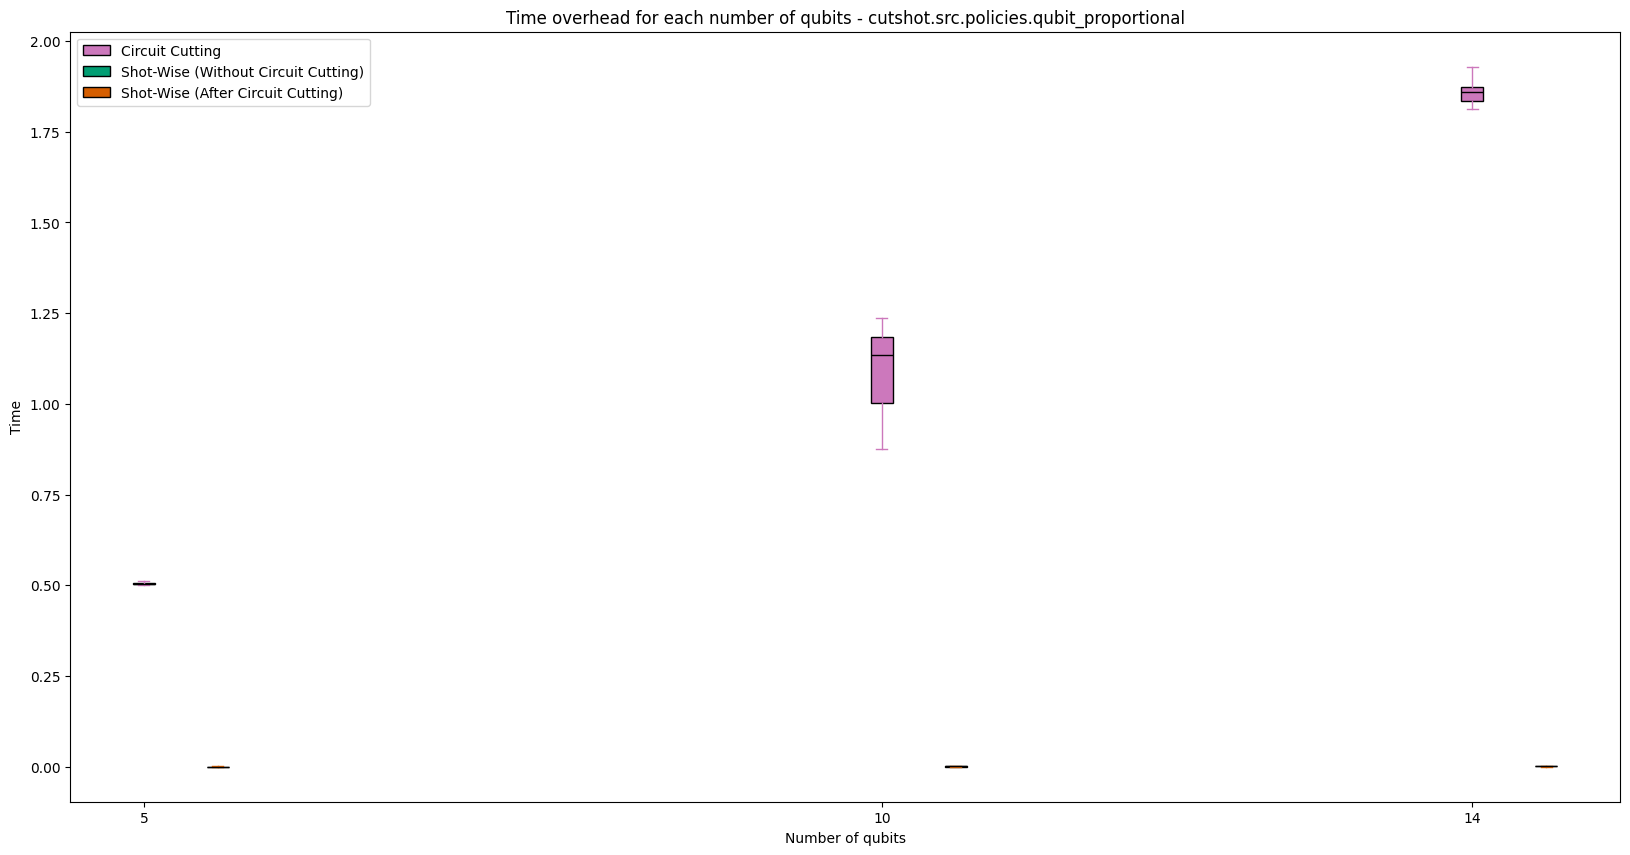

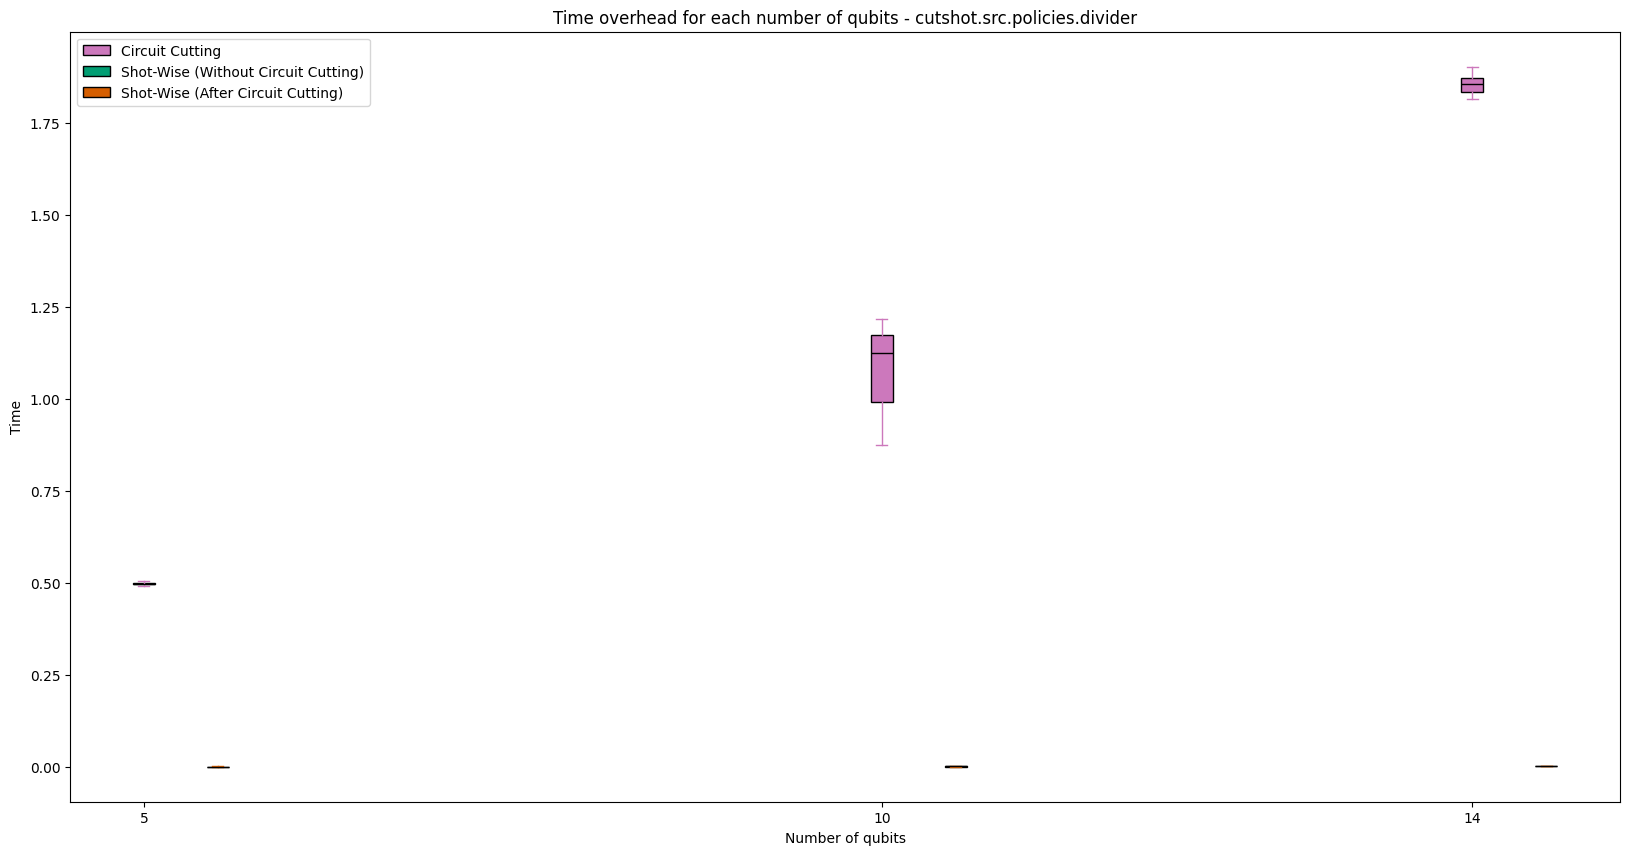

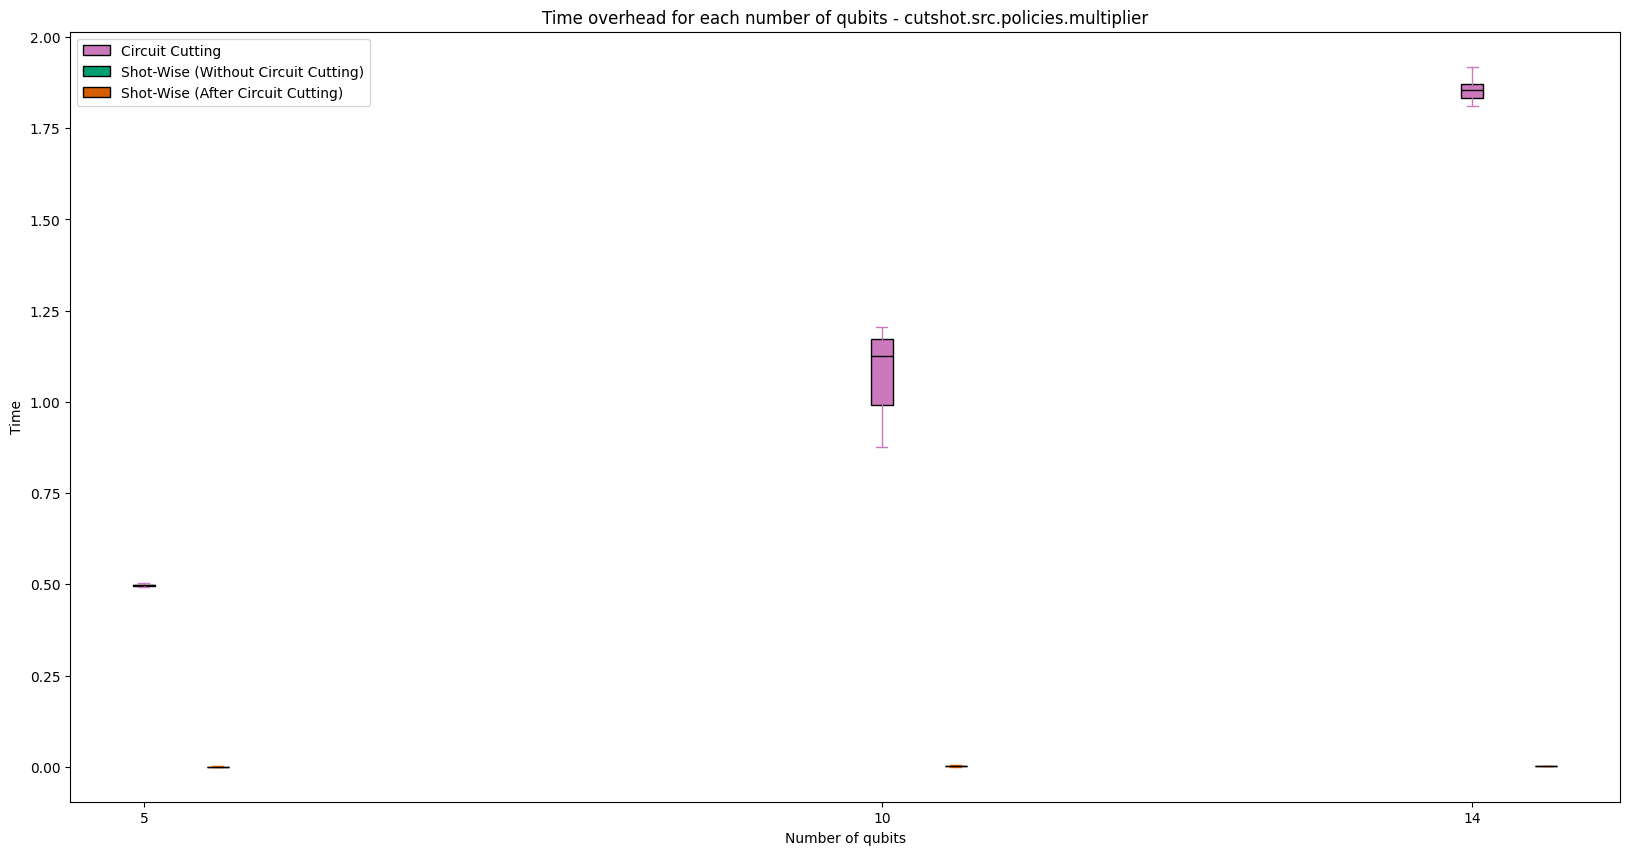

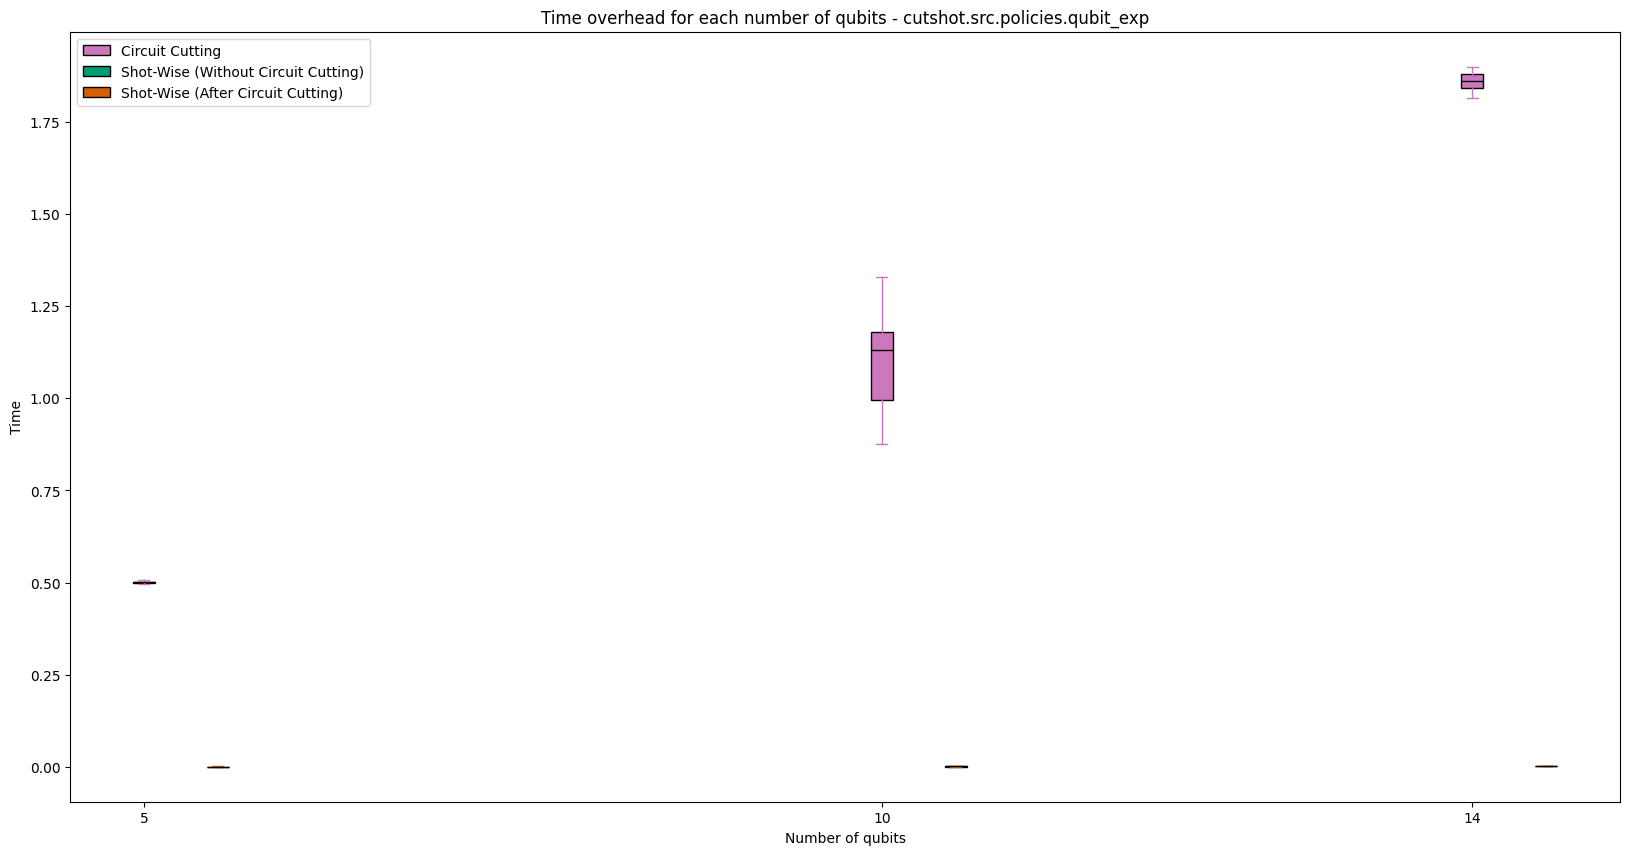

KeyError: 'circuit_cutting_overhead'

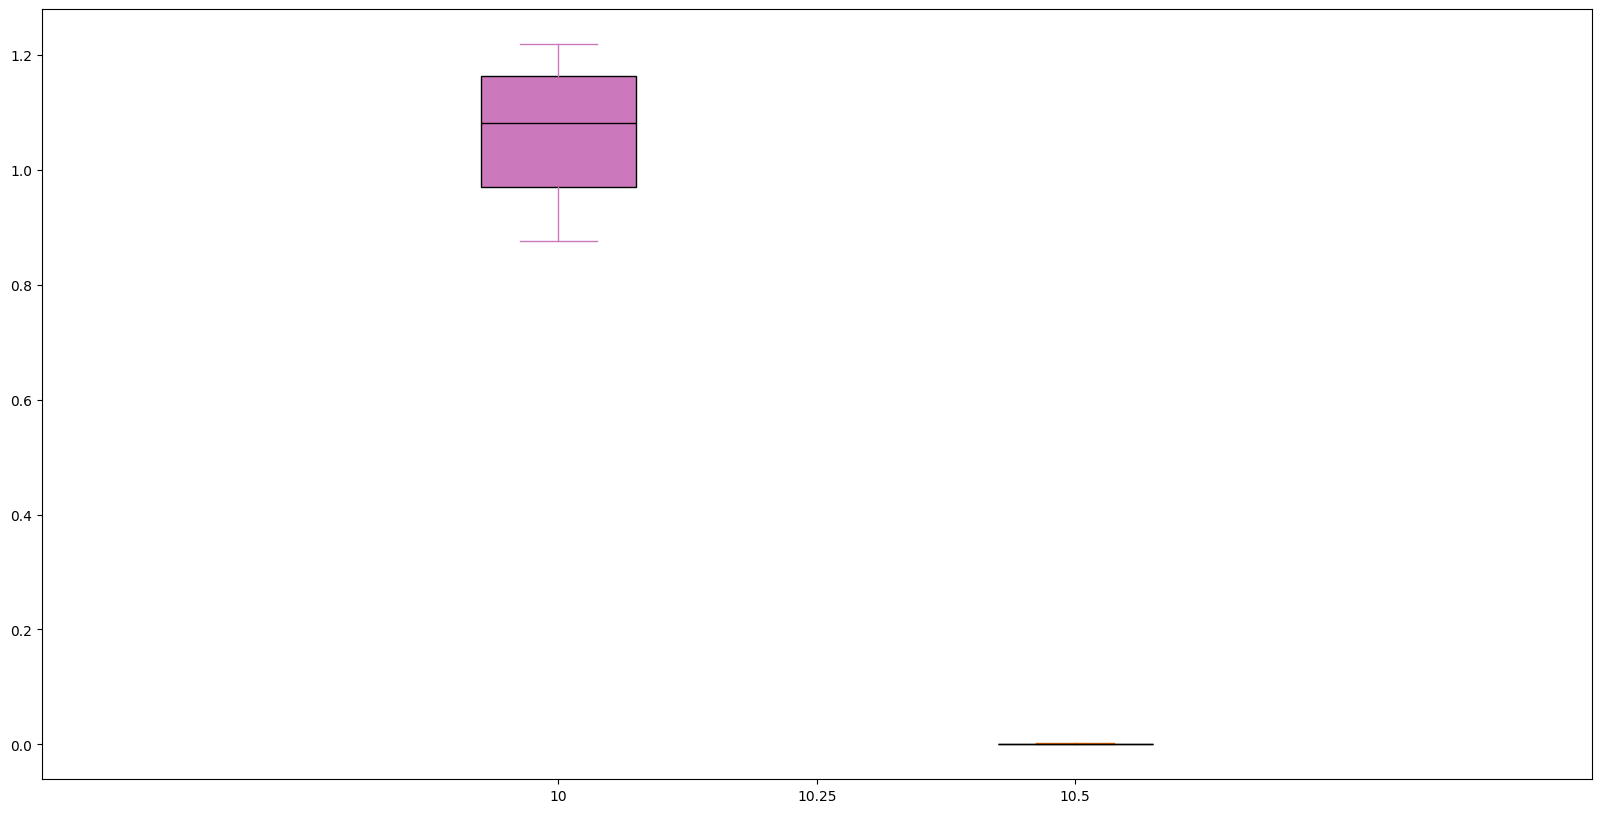

In [14]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    strategies = ["cc_all", "sw_without", "sw_after"]

    for qubits in exp_data_df["qubits"].unique():
        data = exp_data_df[(exp_data_df["qubits"] == qubits) & (exp_data_df["shots_allocation"] == sa)]
        # circuit cutting overhead is not nan
        circuit_cutting_overhead = data[[not np.isnan(x) for x in data["circuit_cutting_overhead"]]]
        
        shot_wise_overhead = data[[not np.isnan(x) for x in data["shot_wise_overhead"]]]
        shot_wise_overhead_with_cc = shot_wise_overhead[[not np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        shot_wise_overhead_without_cc = shot_wise_overhead[[np.isnan(x) for x in shot_wise_overhead["circuit_cutting_overhead"]]]
        
        offset = 0
        color = colors["cc_all"]
        ax.boxplot(circuit_cutting_overhead["circuit_cutting_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
        color = colors["sw_without"]
        ax.boxplot(shot_wise_overhead_without_cc["shot_wise_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25
        
        color = colors["sw_after"]
        ax.boxplot(shot_wise_overhead_with_cc["shot_wise_overhead"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        offset += 0.25

        
    ax.set_xlabel("Number of qubits")
    ax.set_ylabel("Time")
    ax.set_title("Time overhead for each number of qubits - " + sa)
    ax.set_xticks(exp_data_df["qubits"].unique())
    ax.set_xticklabels(exp_data_df["qubits"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in ["cc_all", "sw_without", "sw_after"]], [legend[strategy] for strategy in ["cc_all", "sw_without", "sw_after"]])
    
    plt.savefig(plots_dir + f"time_overhead_num_qubits_{sa}.png")
    plt.show()
    

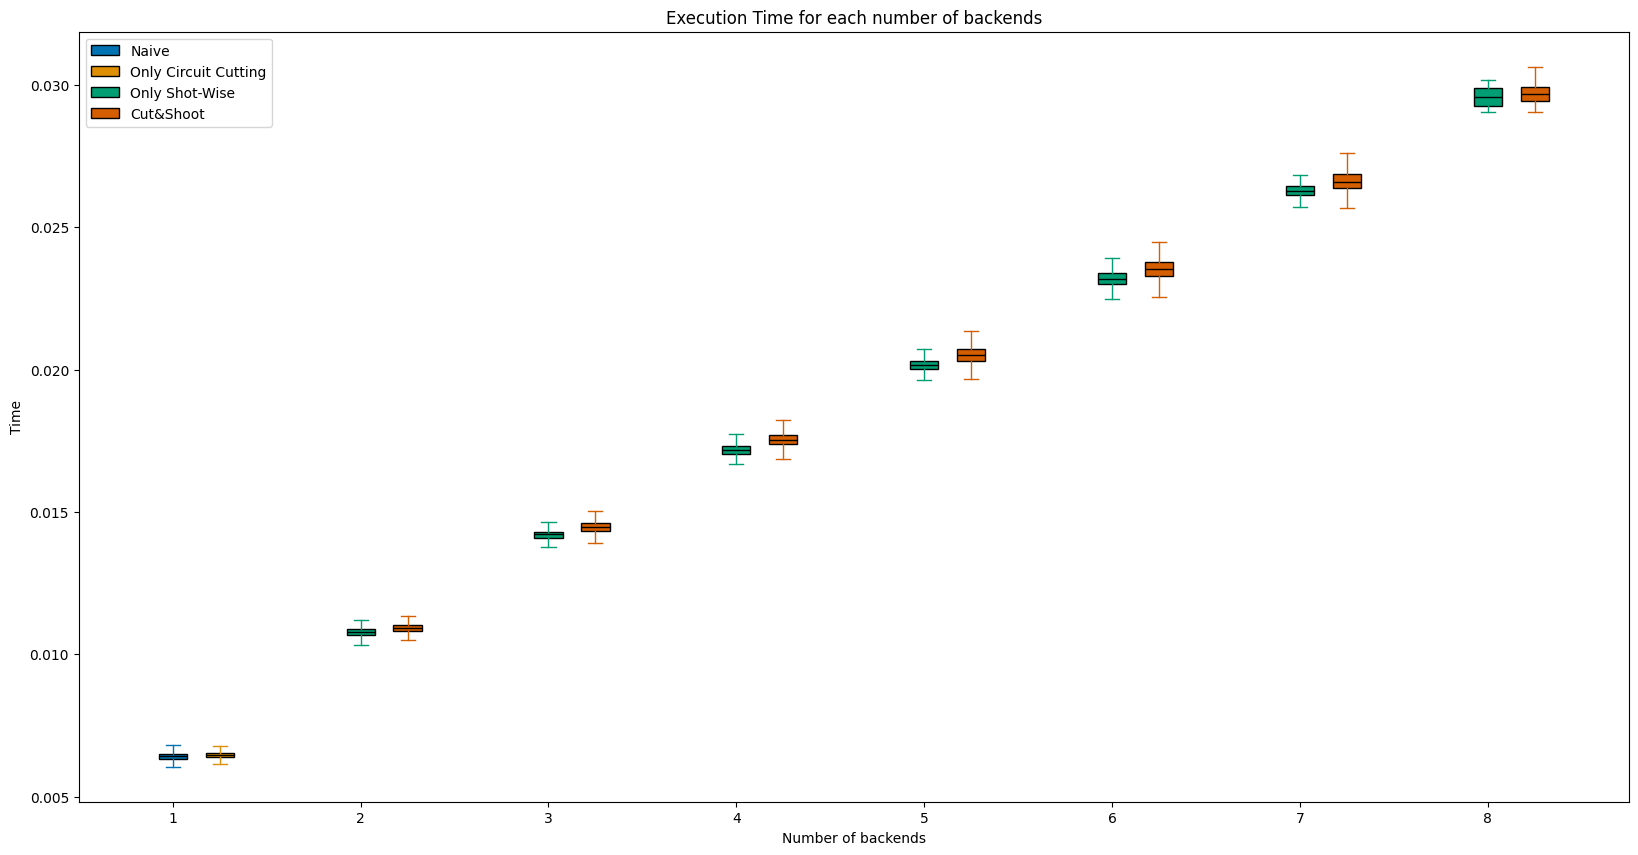

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for num_backends in exp_data_df["num_backends"].unique():
    data = exp_data_df[exp_data_df["num_backends"] == num_backends]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    cc_sw = data[data["strategy"] == "cc_sw"]
    
    offset = 0
    color = colors["vanilla"]
    ax.boxplot(vanilla["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    
ax.set_xlabel("Number of backends")
ax.set_ylabel("Time")
ax.set_title("Execution Time for each number of backends")
ax.set_xticks(exp_data_df["num_backends"].unique())
ax.set_xticklabels(exp_data_df["num_backends"].unique())
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])

plt.savefig(plots_dir + f"execution_time_num_backends.png")
plt.show()
    

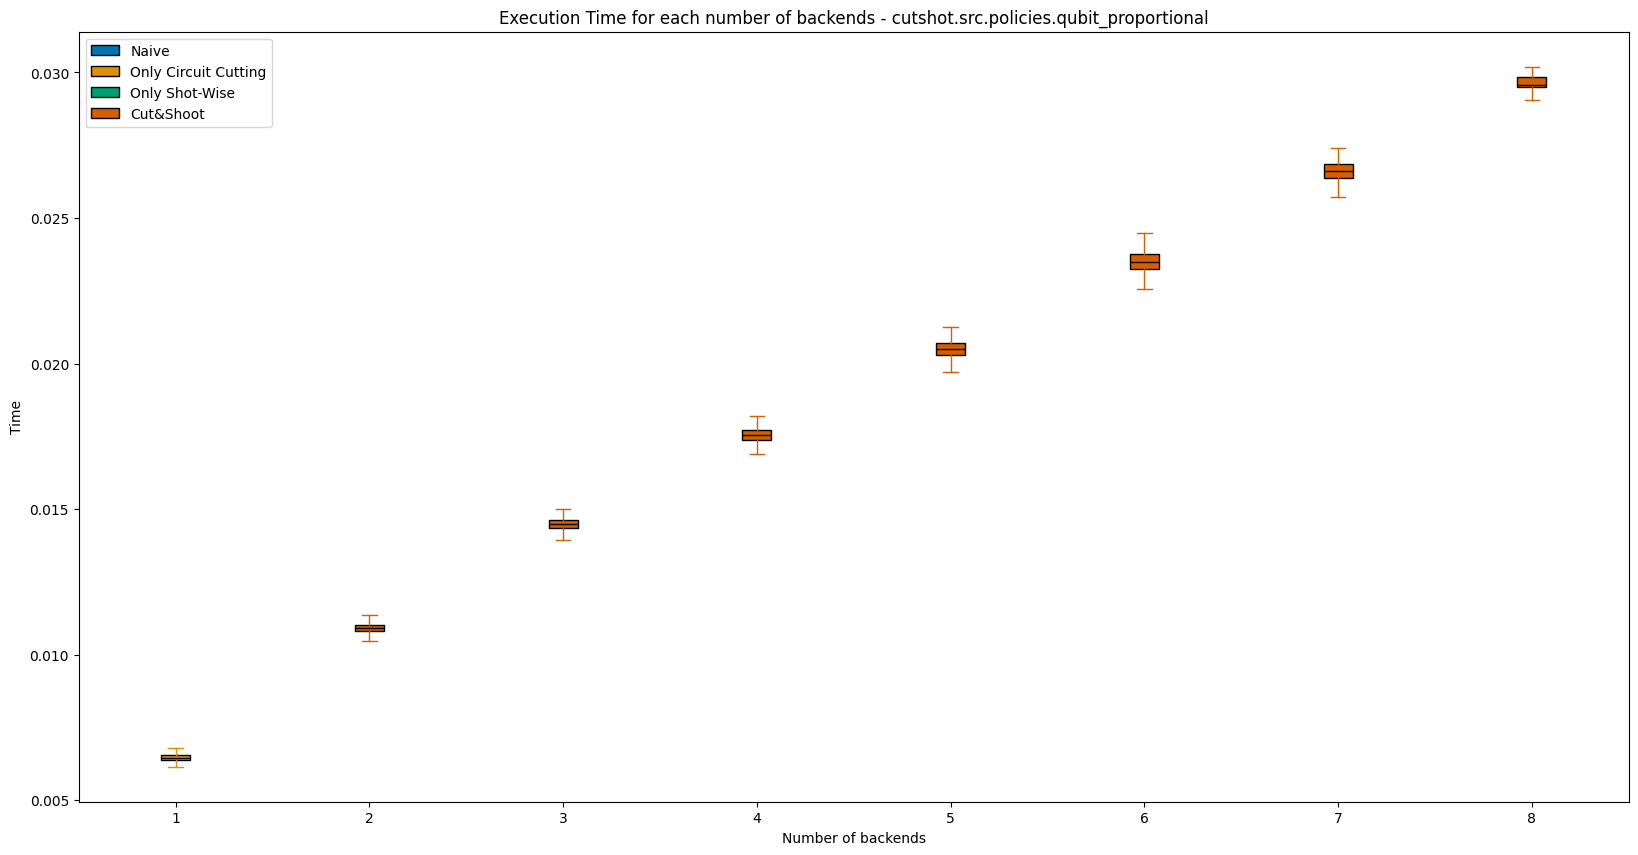

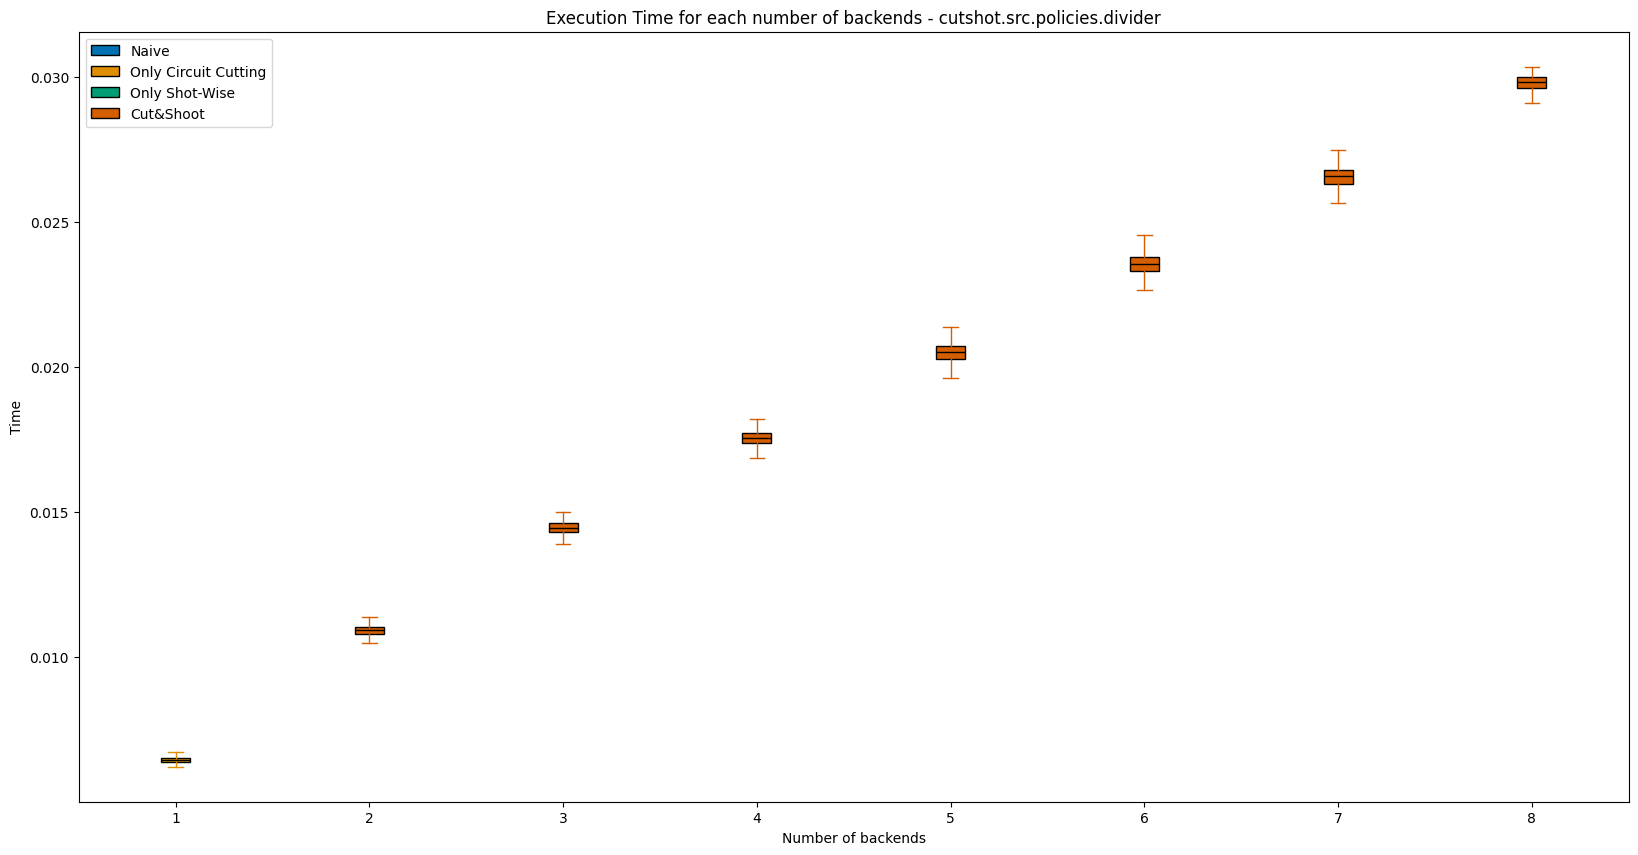

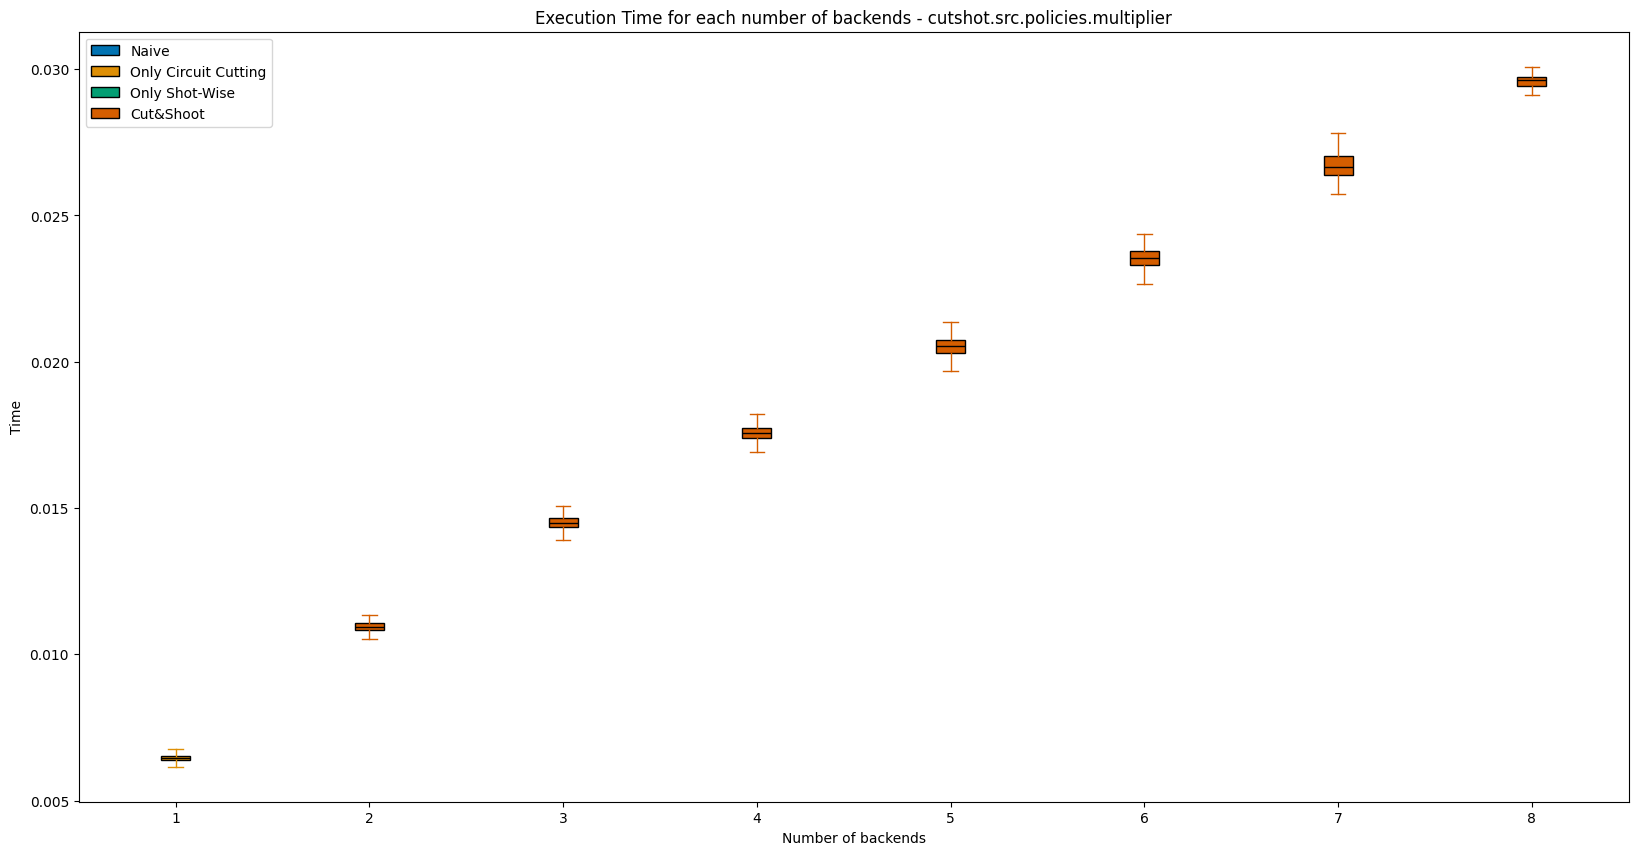

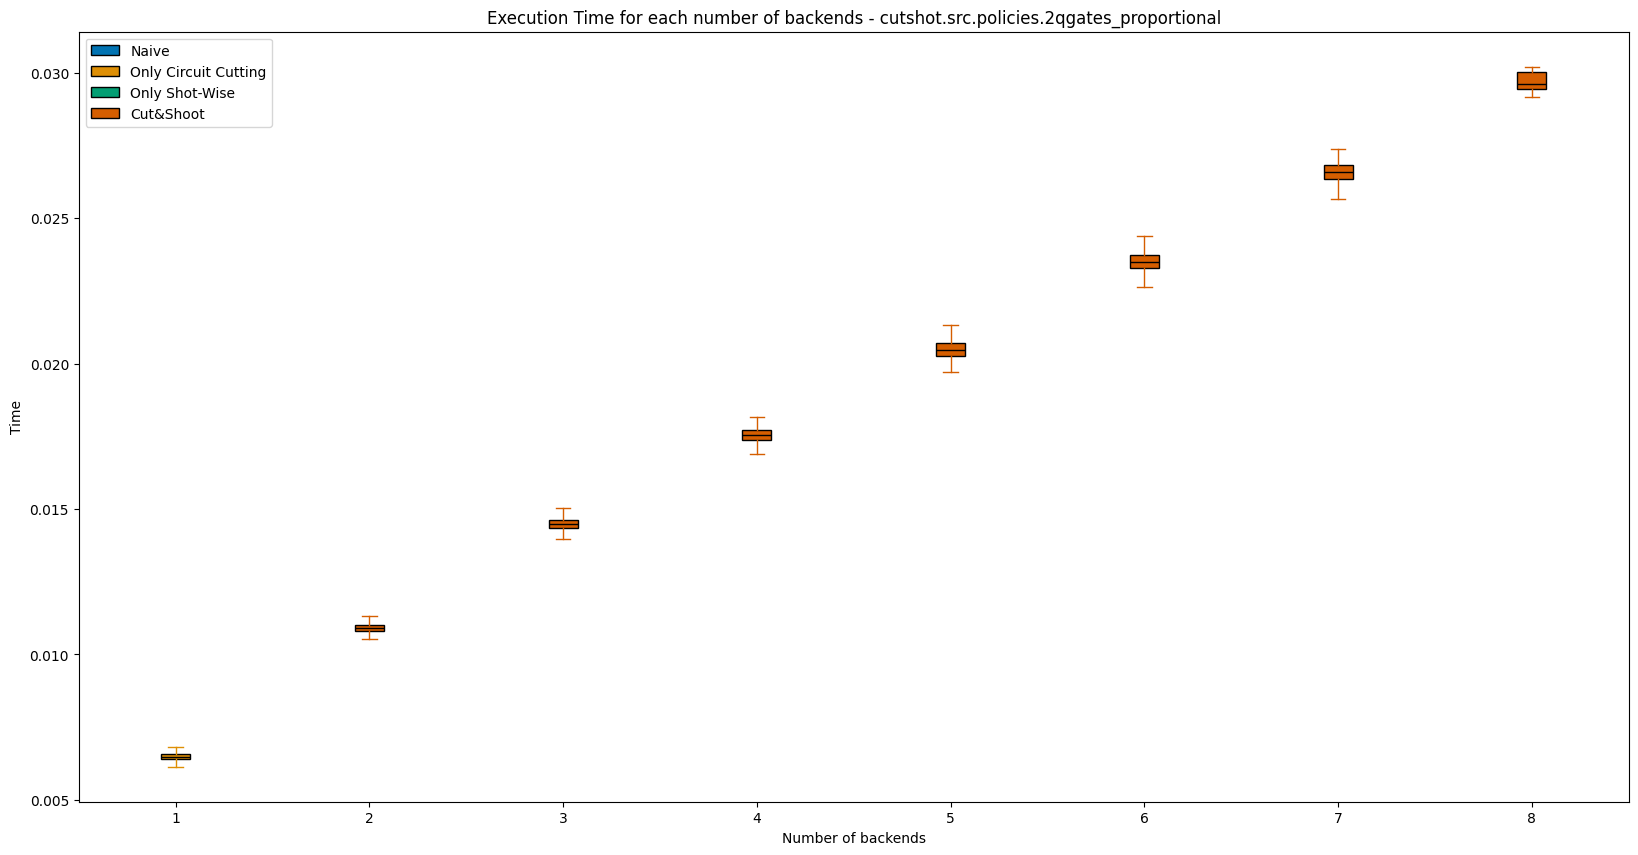

In [ ]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for num_backends in exp_data_df["num_backends"].unique():
        data = exp_data_df[(exp_data_df["num_backends"] == num_backends) & (exp_data_df["shots_allocation"] == sa)]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        cc_sw = data[data["strategy"] == "cc_sw"]
        
        offset = 0
        color = colors["vanilla"]
        ax.boxplot(vanilla["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["execution_time"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
    ax.set_xlabel("Number of backends")
    ax.set_ylabel("Time")
    ax.set_title("Execution Time for each number of backends - " + sa)
    ax.set_xticks(exp_data_df["num_backends"].unique())
    ax.set_xticklabels(exp_data_df["num_backends"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
    plt.savefig(plots_dir + f"execution_time_num_backends_{sa}.png")
    plt.show()
    

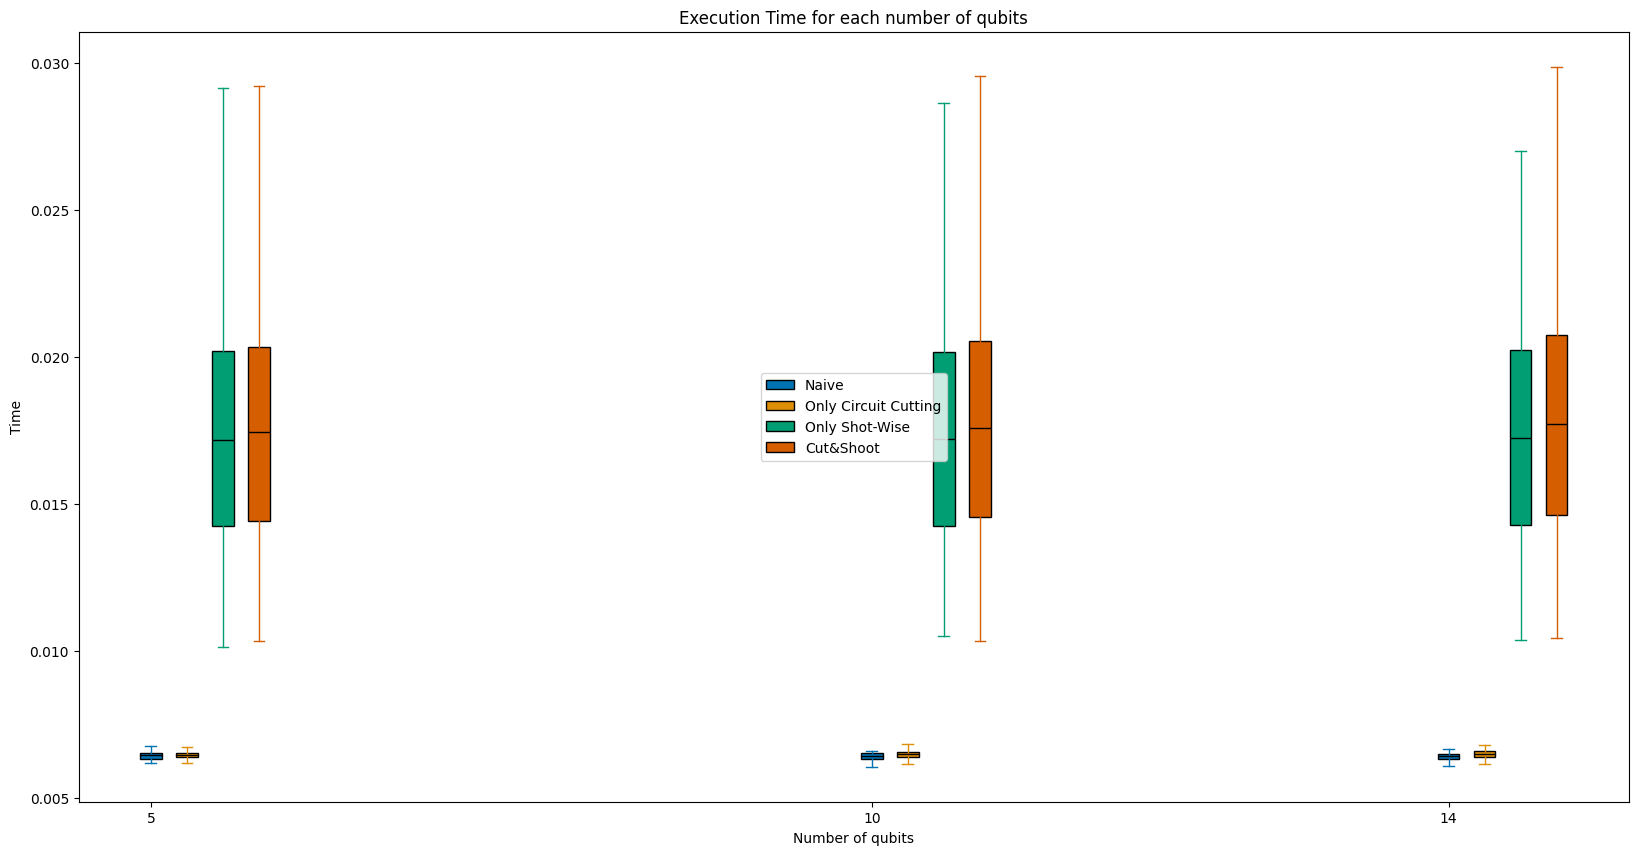

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for qubits in exp_data_df["qubits"].unique():
    data = exp_data_df[exp_data_df["qubits"] == qubits]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    cc_sw = data[data["strategy"] == "cc_sw"]
    
    offset = 0
    color = colors["vanilla"]
    ax.boxplot(vanilla["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    
ax.set_xlabel("Number of qubits")
ax.set_ylabel("Time")
ax.set_title("Execution Time for each number of qubits")
ax.set_xticks(exp_data_df["qubits"].unique())
ax.set_xticklabels(exp_data_df["qubits"].unique())
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])

plt.savefig(plots_dir + f"execution_time_num_qubits.png")
plt.show()
    

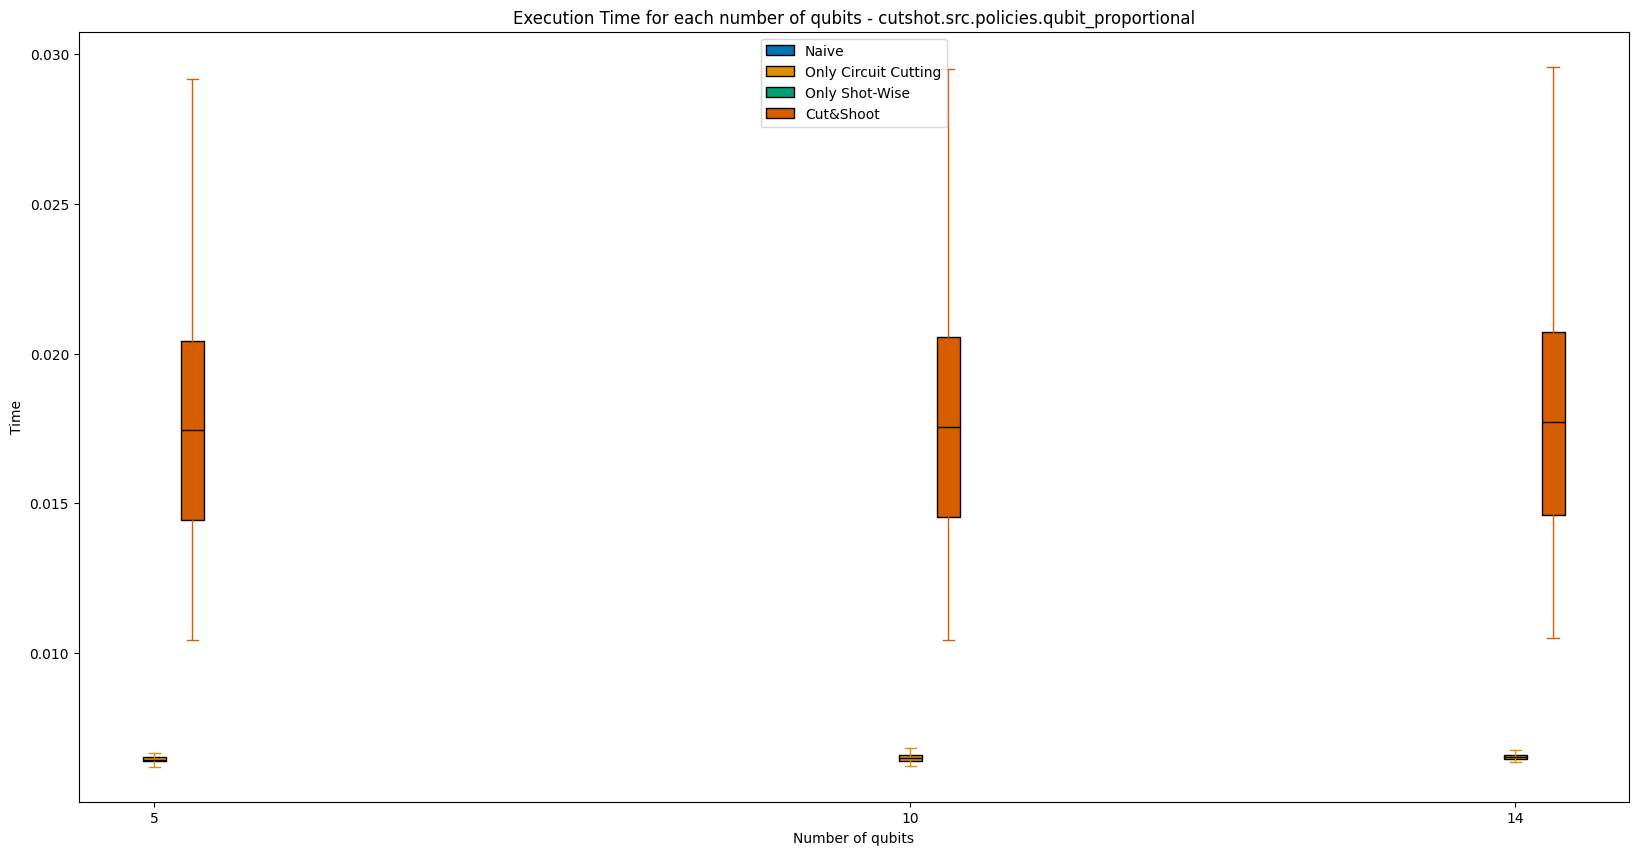

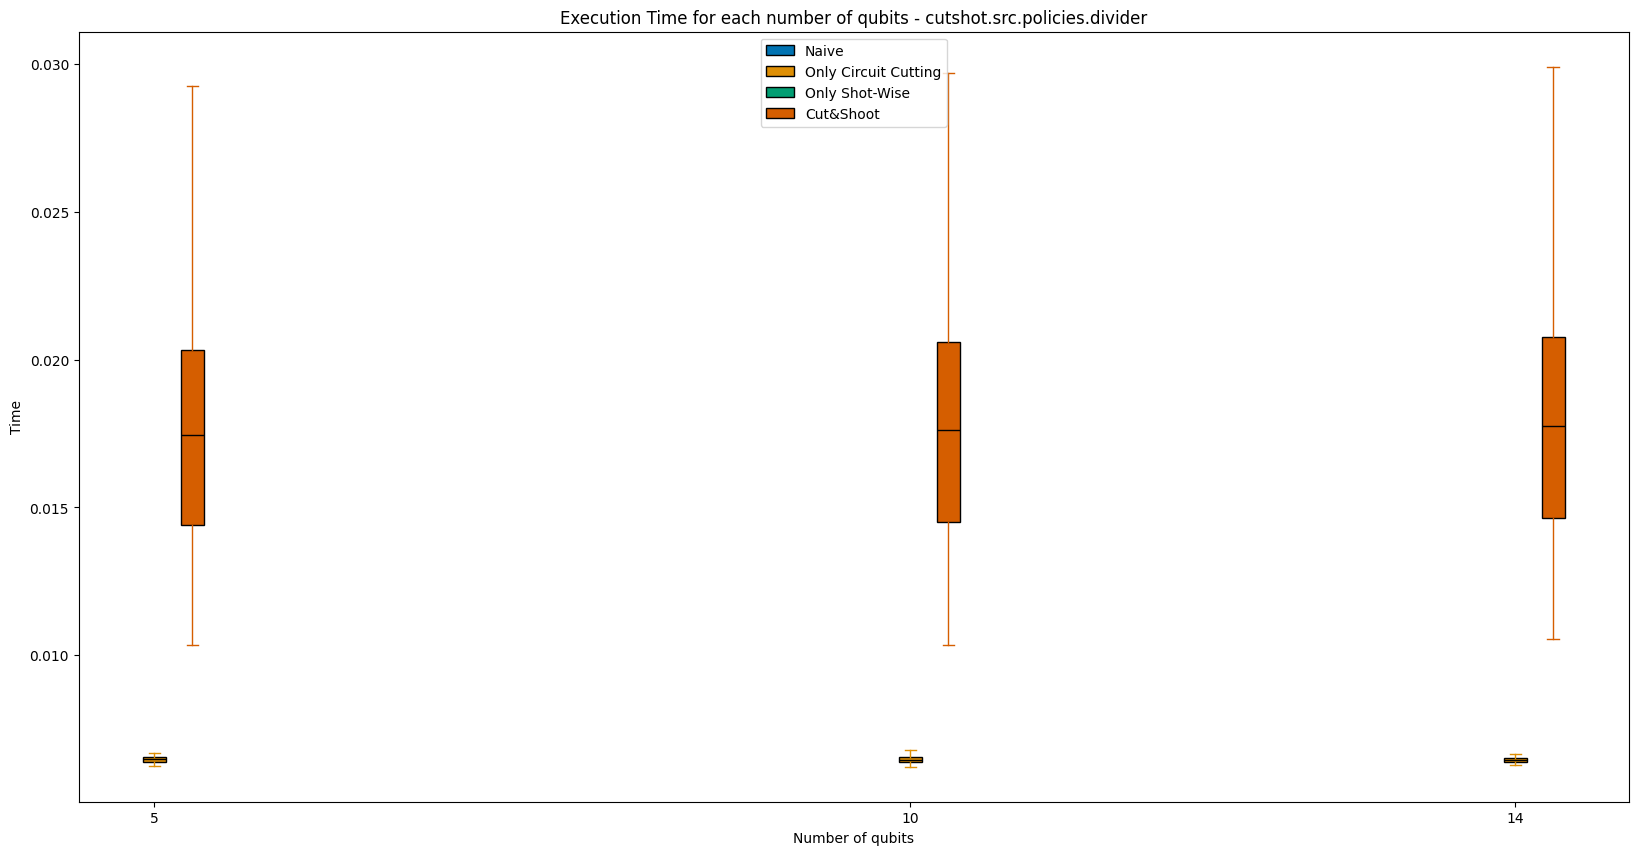

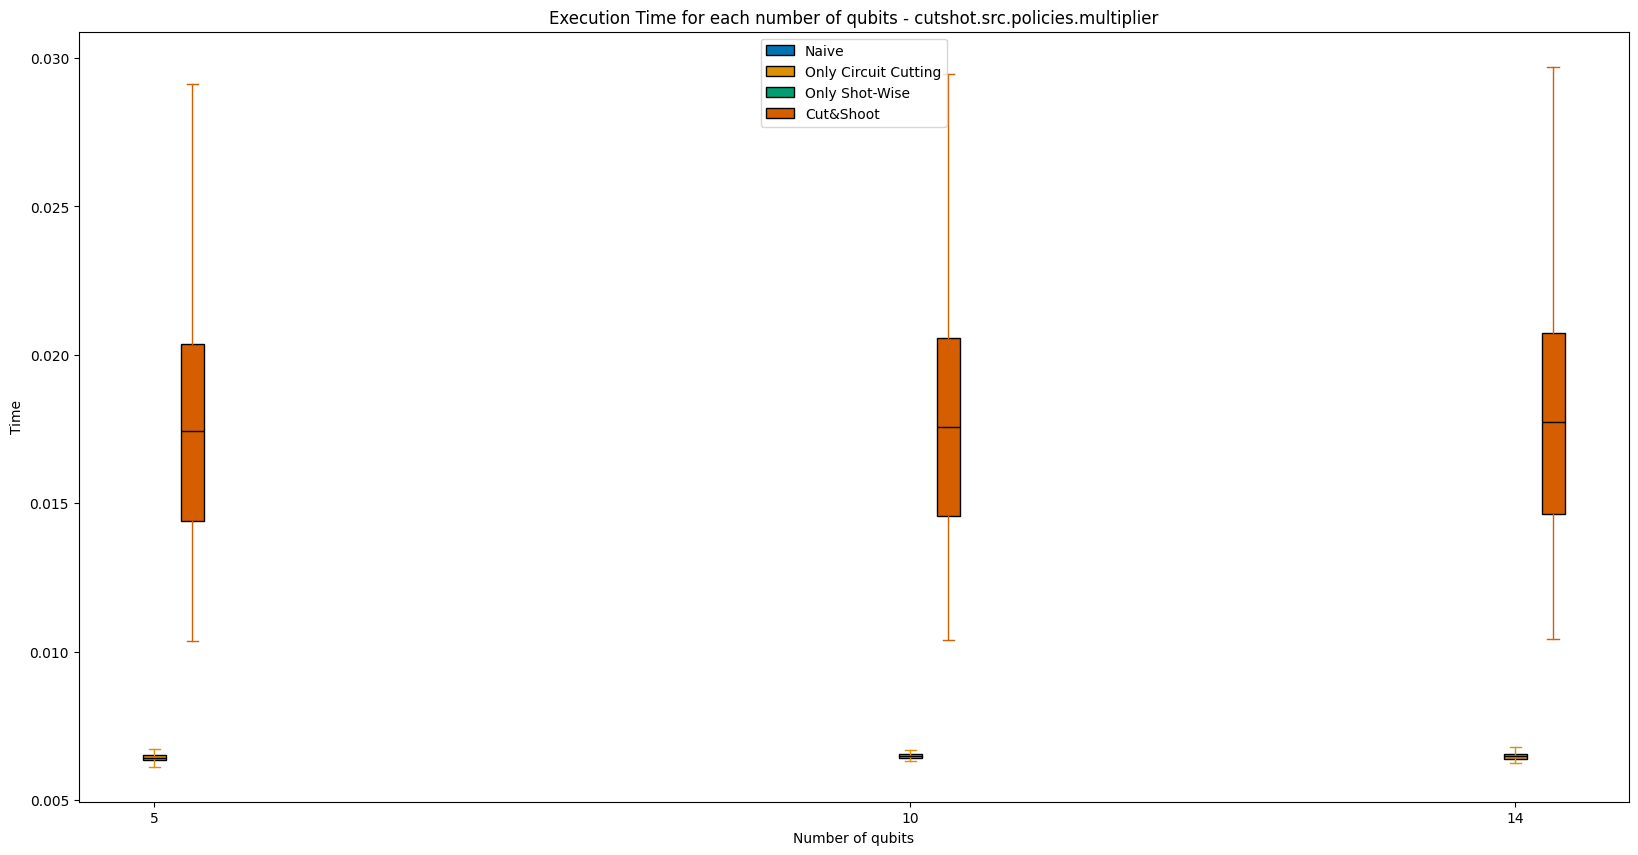

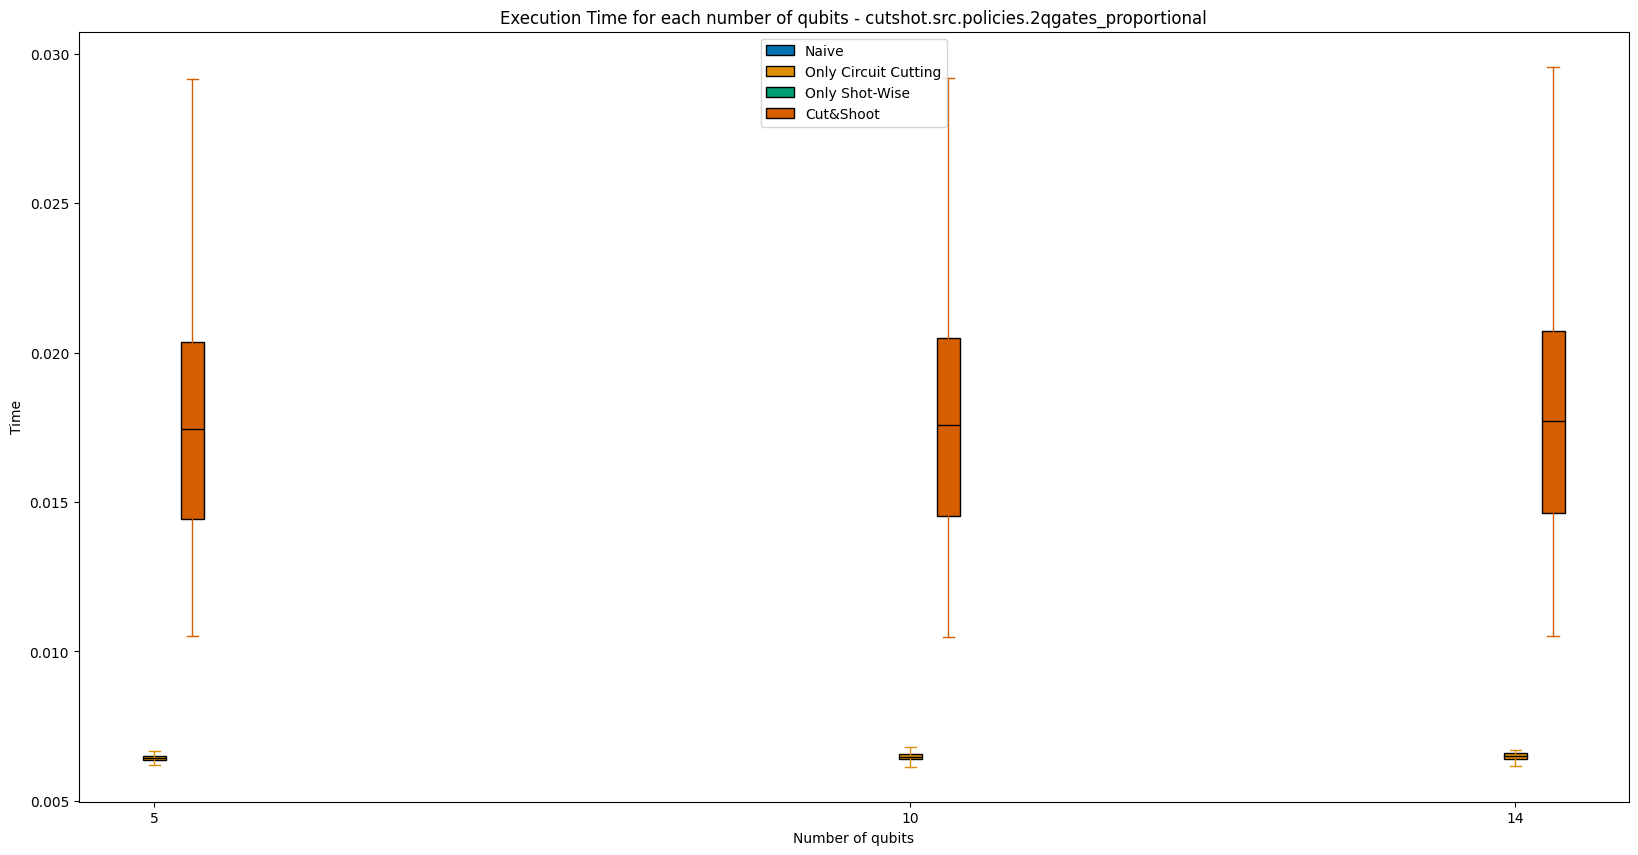

In [ ]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for qubits in exp_data_df["qubits"].unique():
        data = exp_data_df[(exp_data_df["qubits"] == qubits) & (exp_data_df["shots_allocation"] == sa)]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        cc_sw = data[data["strategy"] == "cc_sw"]
        
        offset = 0
        color = colors["vanilla"]
        ax.boxplot(vanilla["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["execution_time"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
    ax.set_xlabel("Number of qubits")
    ax.set_ylabel("Time")
    ax.set_title("Execution Time for each number of qubits - " + sa)
    ax.set_xticks(exp_data_df["qubits"].unique())
    ax.set_xticklabels(exp_data_df["qubits"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
    plt.savefig(plots_dir + f"execution_time_num_qubits_{sa}.png")
    plt.show()
        

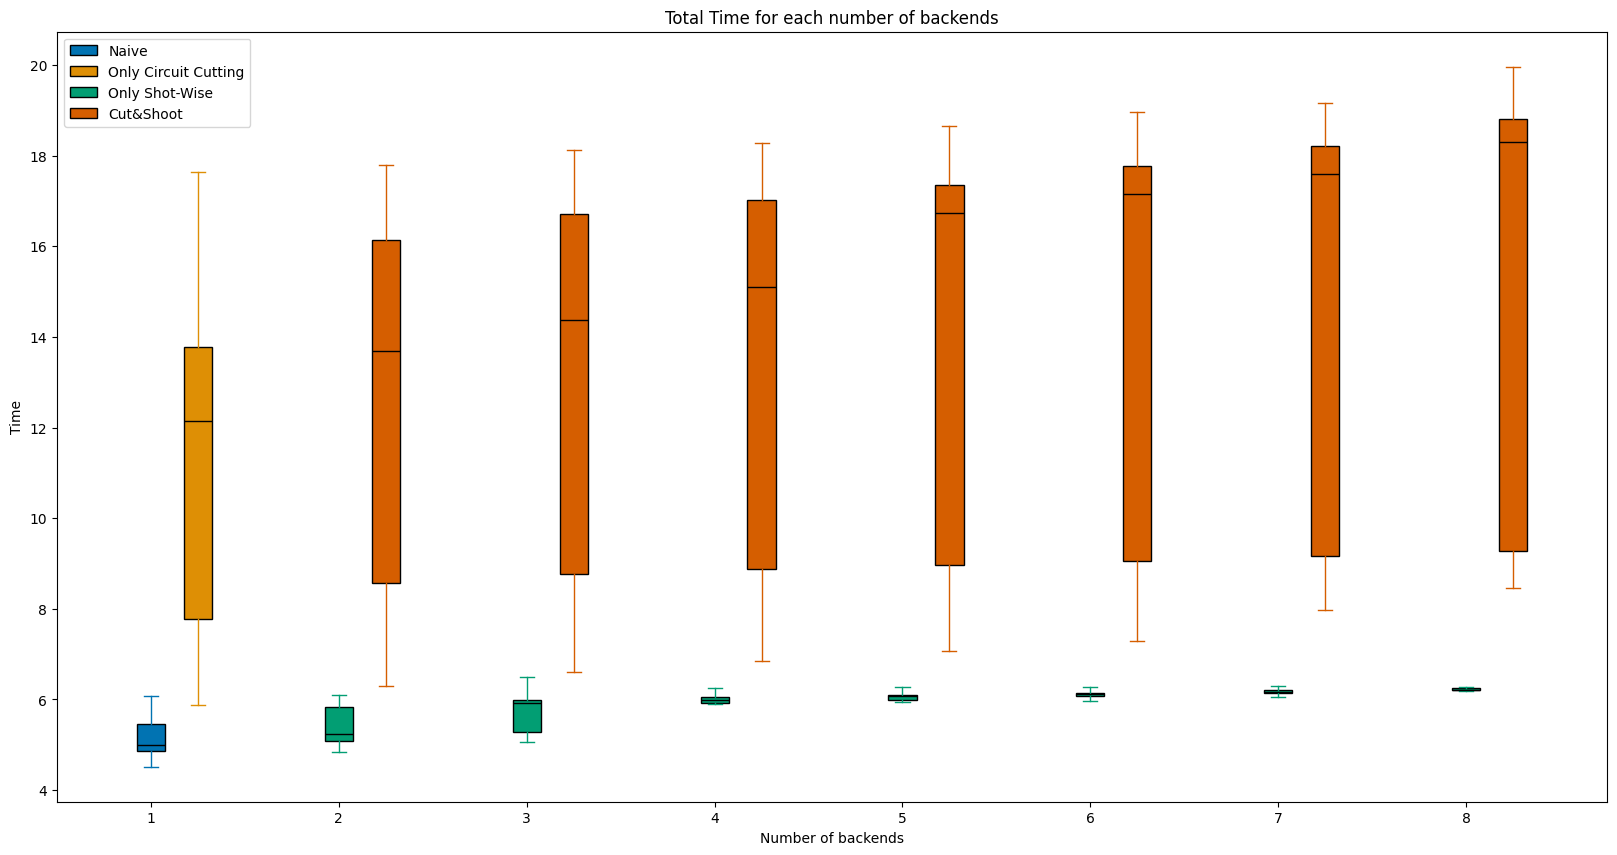

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for num_backends in exp_data_df["num_backends"].unique():
    data = exp_data_df[exp_data_df["num_backends"] == num_backends]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    cc_sw = data[data["strategy"] == "cc_sw"]
    
    offset = 0
    color = colors["vanilla"]
    ax.boxplot(vanilla["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    
ax.set_xlabel("Number of backends")
ax.set_ylabel("Time")
ax.set_title("Total Time for each number of backends")
ax.set_xticks(exp_data_df["num_backends"].unique())
ax.set_xticklabels(exp_data_df["num_backends"].unique())
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])

plt.savefig(plots_dir + f"total_time_num_backends.png")
plt.show()
    

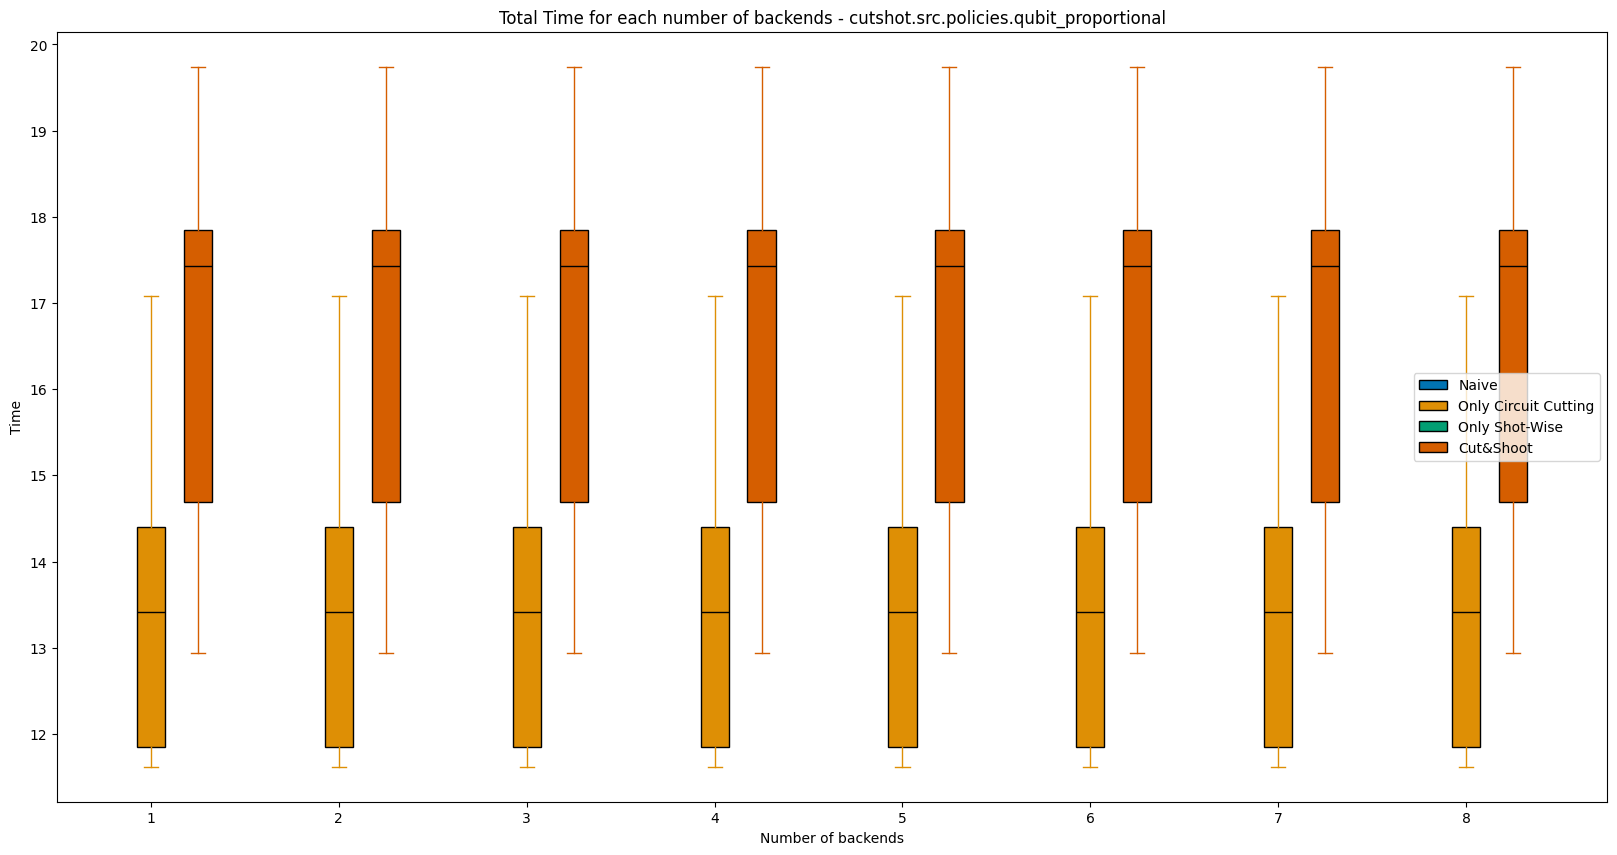

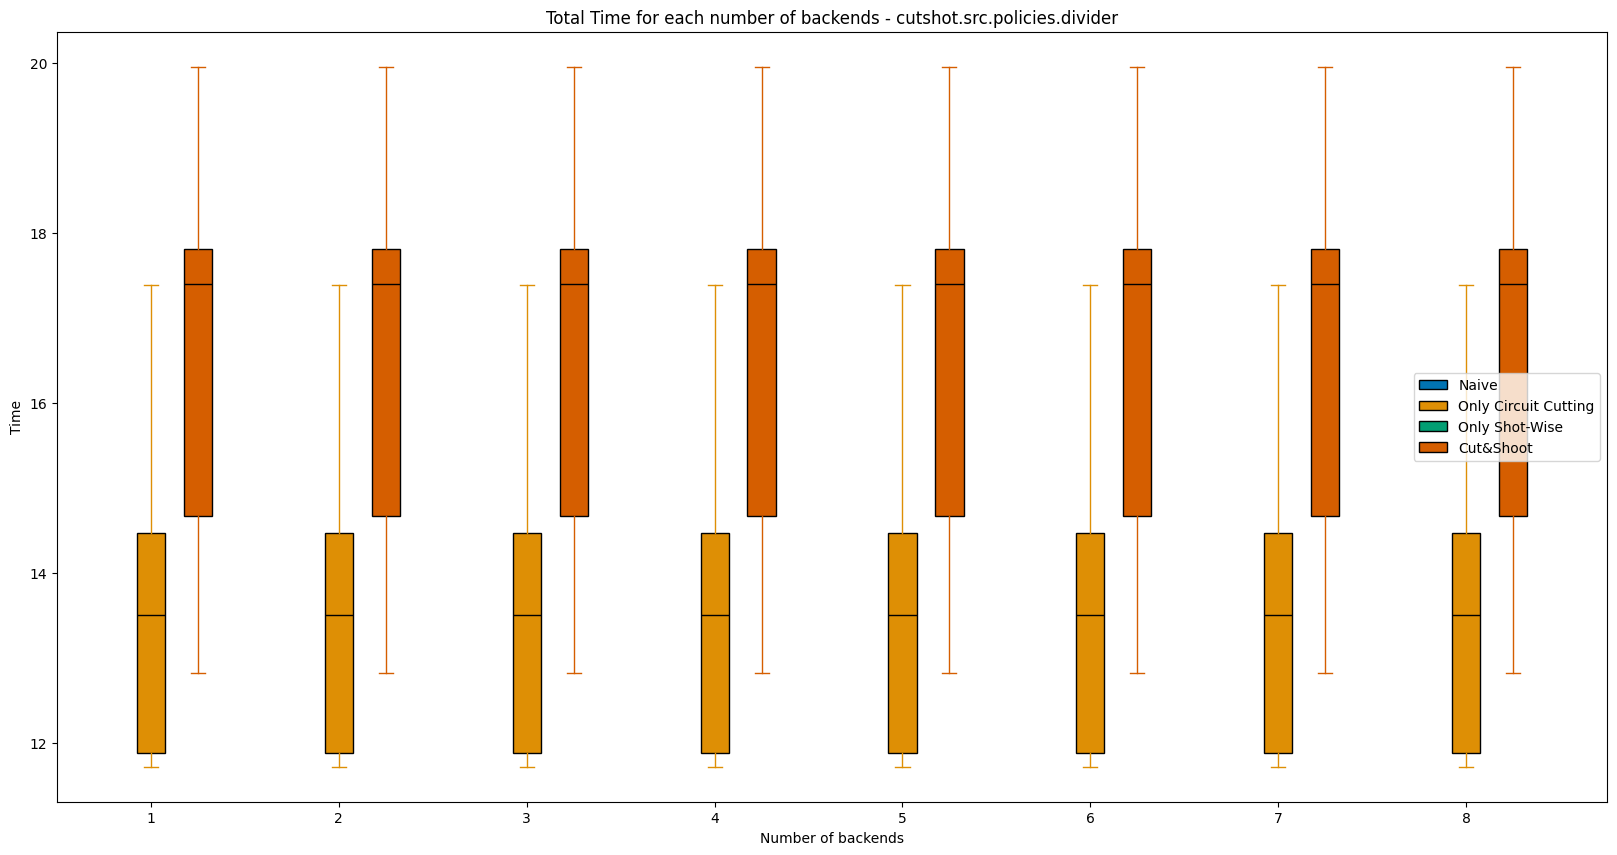

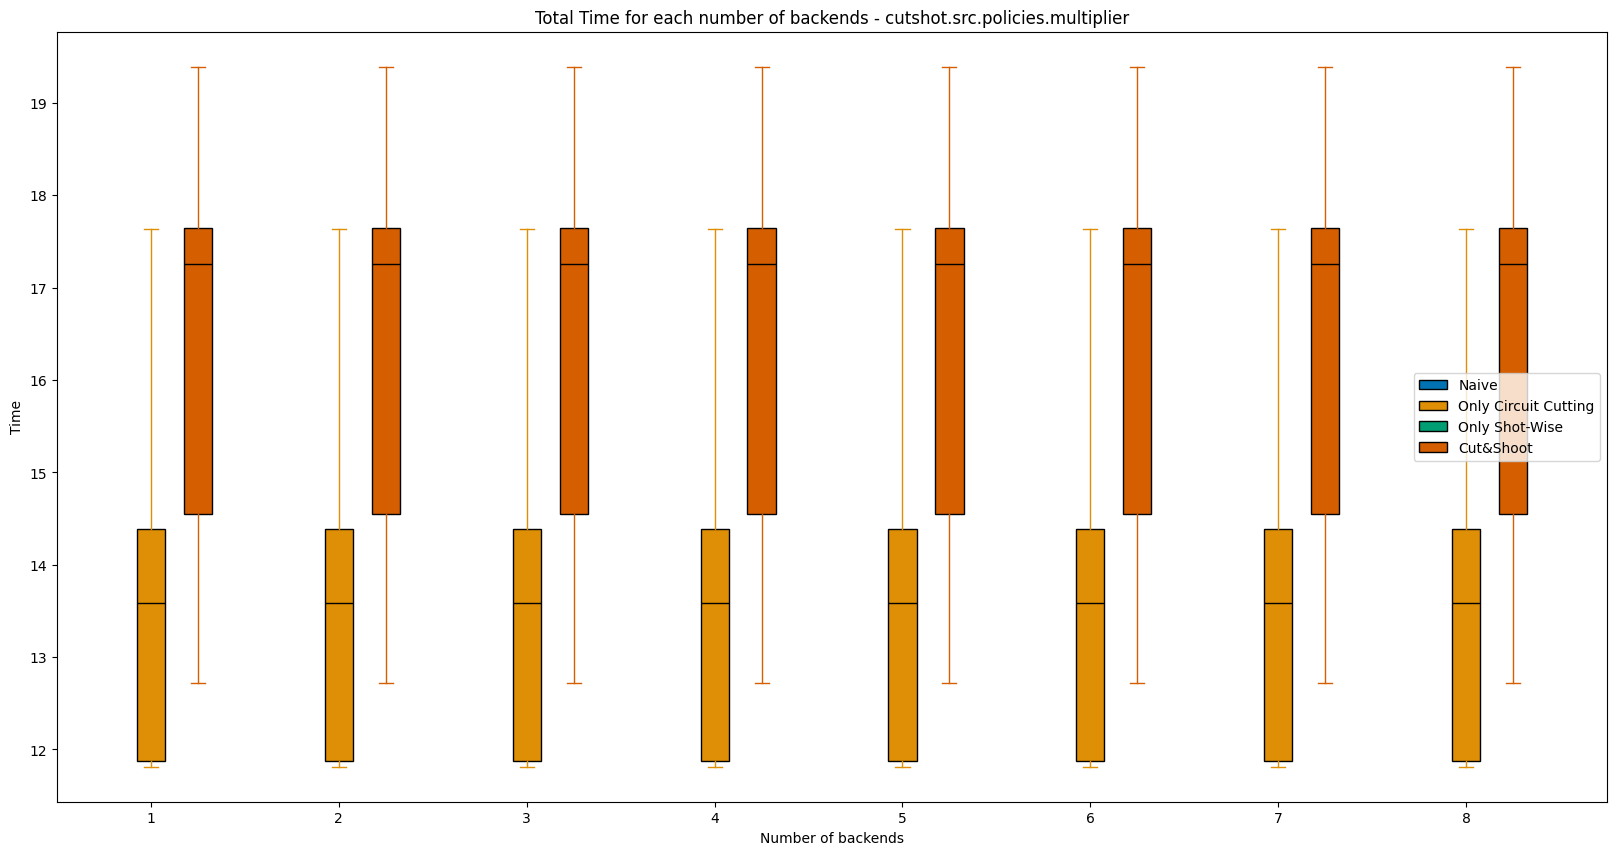

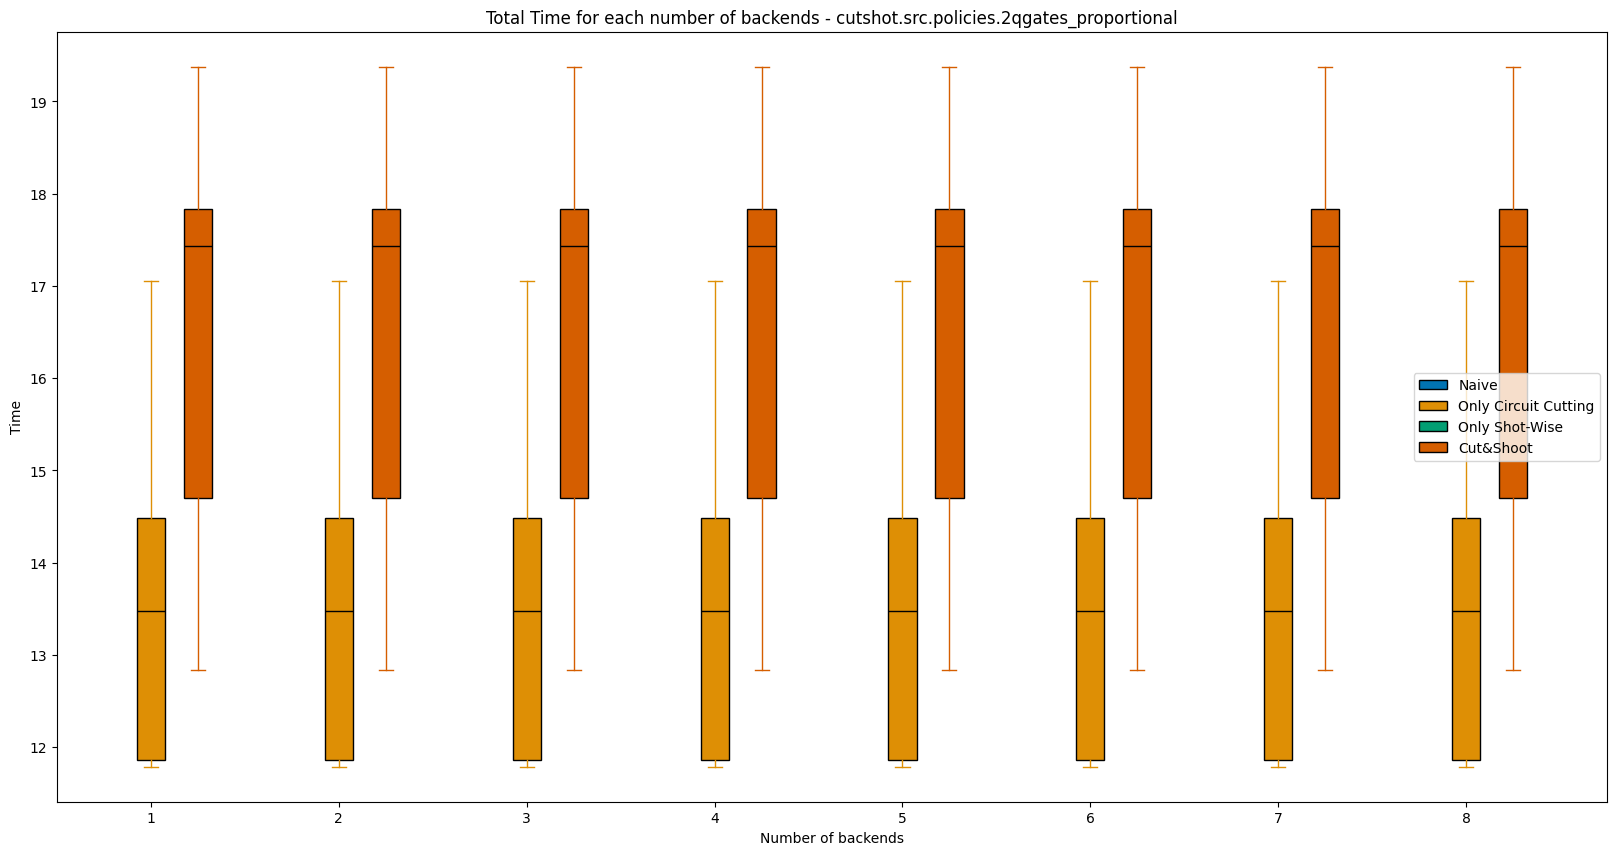

In [ ]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for num_backends in exp_data_df["num_backends"].unique():
        data = exp_data_df[(exp_data_df["qubits"] == qubits) & (exp_data_df["shots_allocation"] == sa)]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        cc_sw = data[data["strategy"] == "cc_sw"]
        
        offset = 0
        color = colors["vanilla"]
        ax.boxplot(vanilla["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["time_total"], positions=[num_backends+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
    ax.set_xlabel("Number of backends")
    ax.set_ylabel("Time")
    ax.set_title("Total Time for each number of backends - "+sa)
    ax.set_xticks(exp_data_df["num_backends"].unique())
    ax.set_xticklabels(exp_data_df["num_backends"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
    plt.savefig(plots_dir + f"total_time_num_backends_{sa}.png")
    plt.show()
    

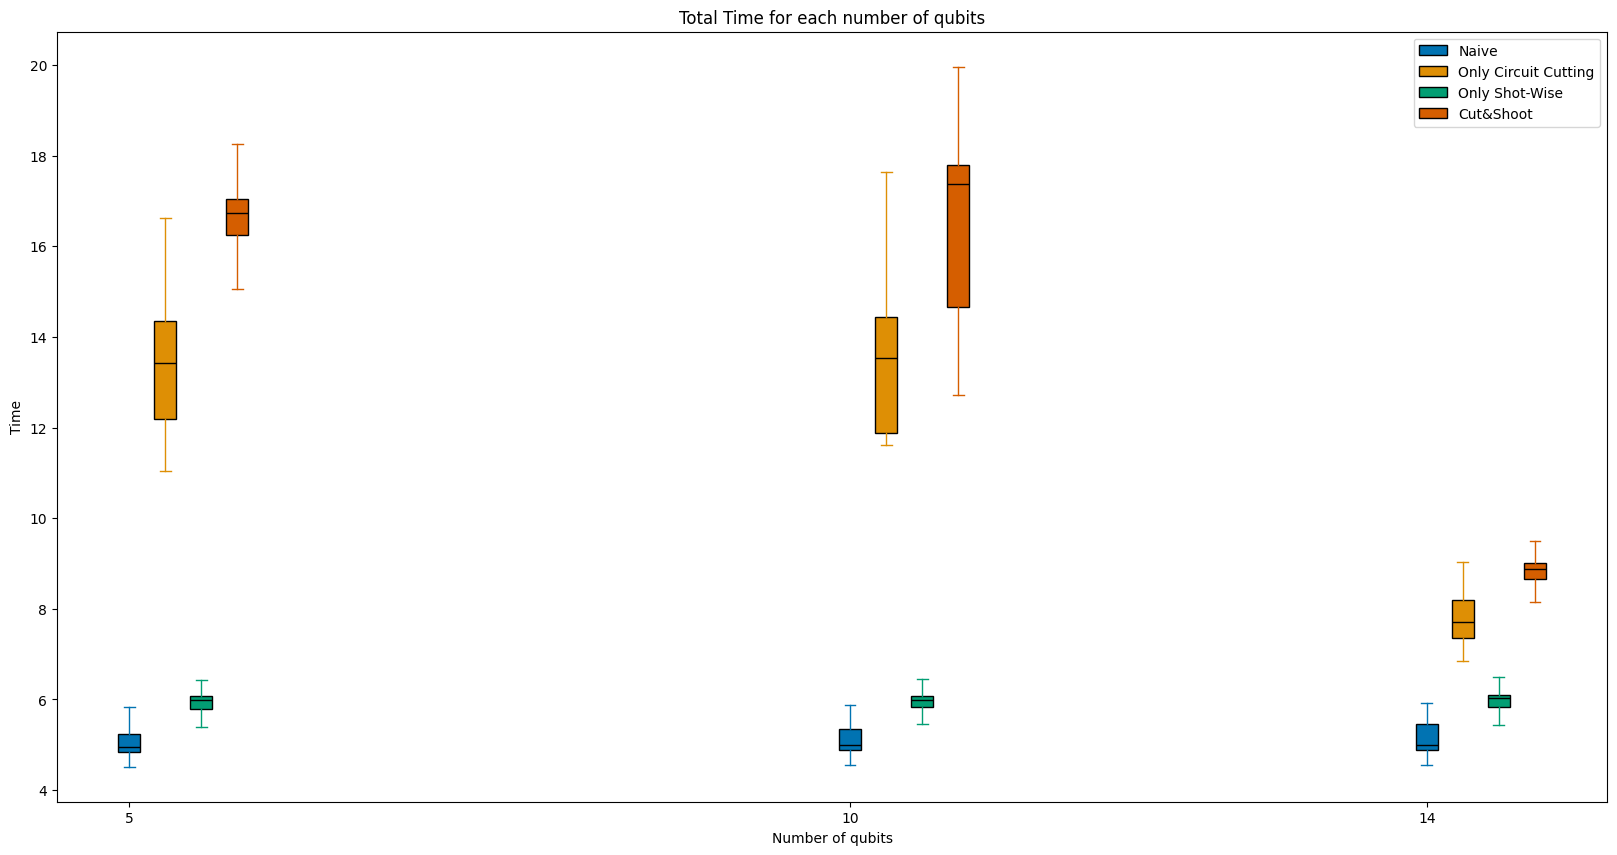

In [ ]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)

for qubits in exp_data_df["qubits"].unique():
    data = exp_data_df[exp_data_df["qubits"] == qubits]
    
    vanilla = data[data["strategy"] == "vanilla"]
    cc = data[data["strategy"] == "cc"]
    shot_wise = data[data["strategy"] == "sw"]
    cc_sw = data[data["strategy"] == "cc_sw"]
    
    offset = 0
    color = colors["vanilla"]
    ax.boxplot(vanilla["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not vanilla.empty:
        offset += 0.25
    
    color = colors["cc"]
    ax.boxplot(cc["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not cc.empty:
        offset += 0.25
    
    color = colors["sw"]
    ax.boxplot(shot_wise["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    if not shot_wise.empty:
        offset += 0.25
        
    color = colors["cc_sw"]
    ax.boxplot(cc_sw["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
    
ax.set_xlabel("Number of qubits")
ax.set_ylabel("Time")
ax.set_title("Total Time for each number of qubits")
ax.set_xticks(exp_data_df["qubits"].unique())
ax.set_xticklabels(exp_data_df["qubits"].unique())
ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])

plt.savefig(plots_dir + f"total_time_num_qubits.png")
plt.show()
    

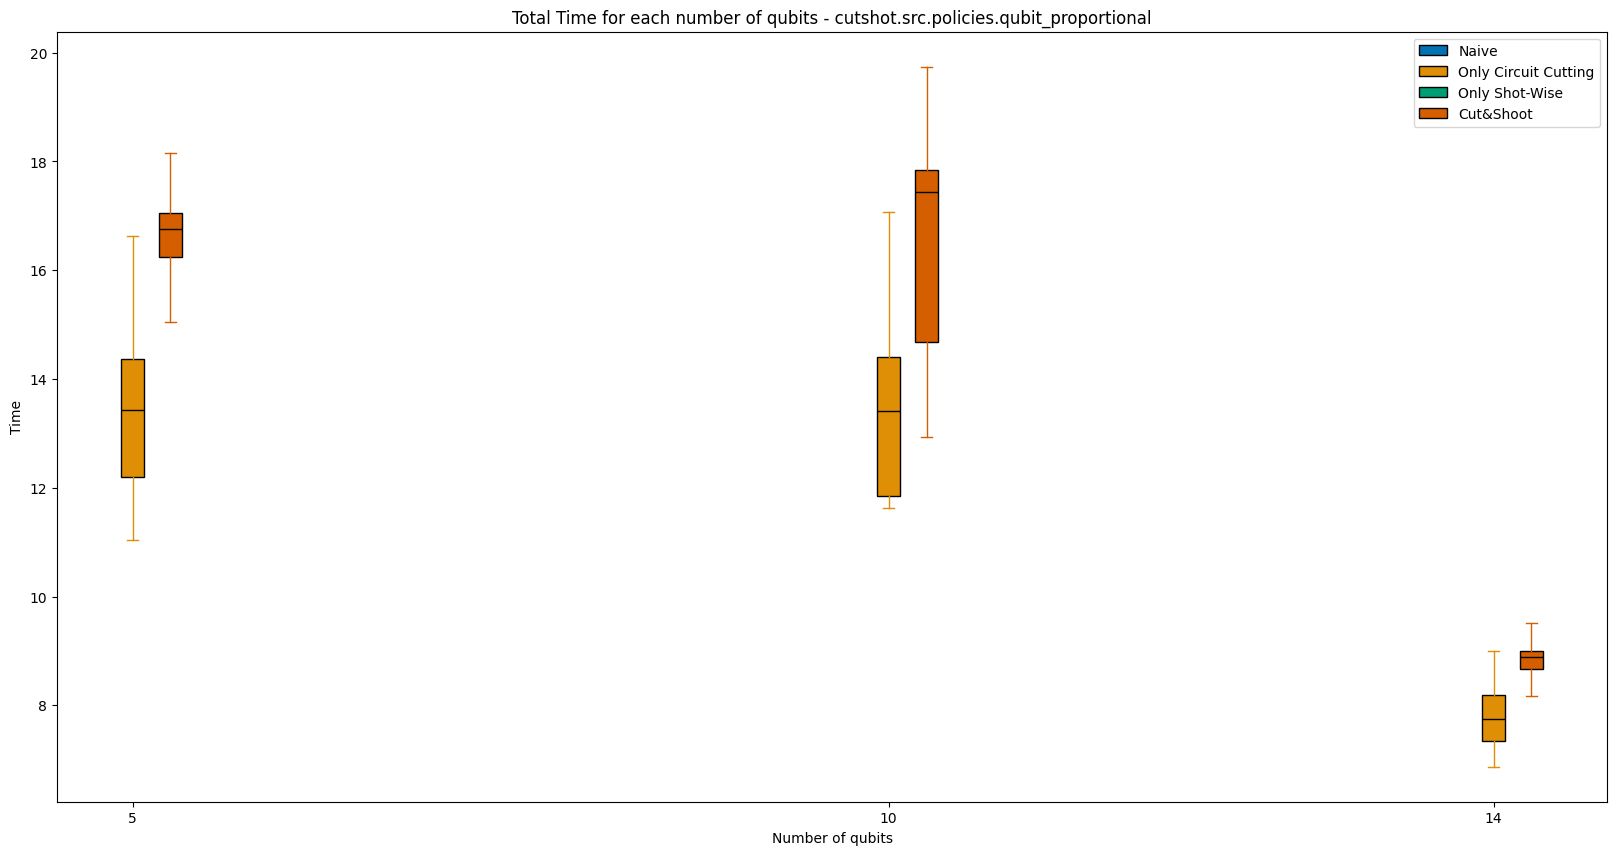

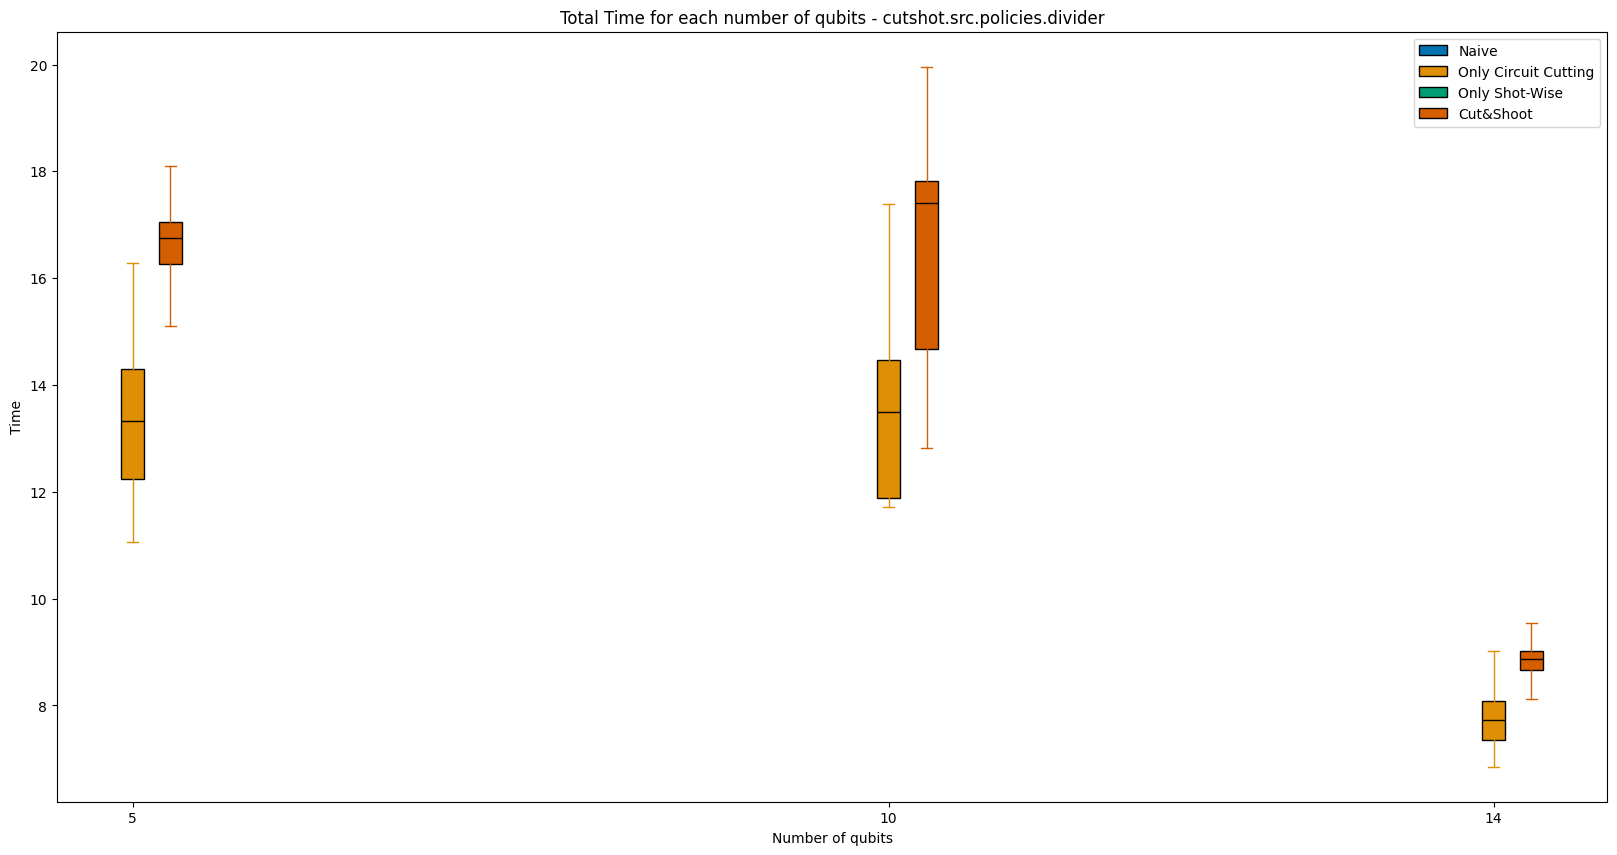

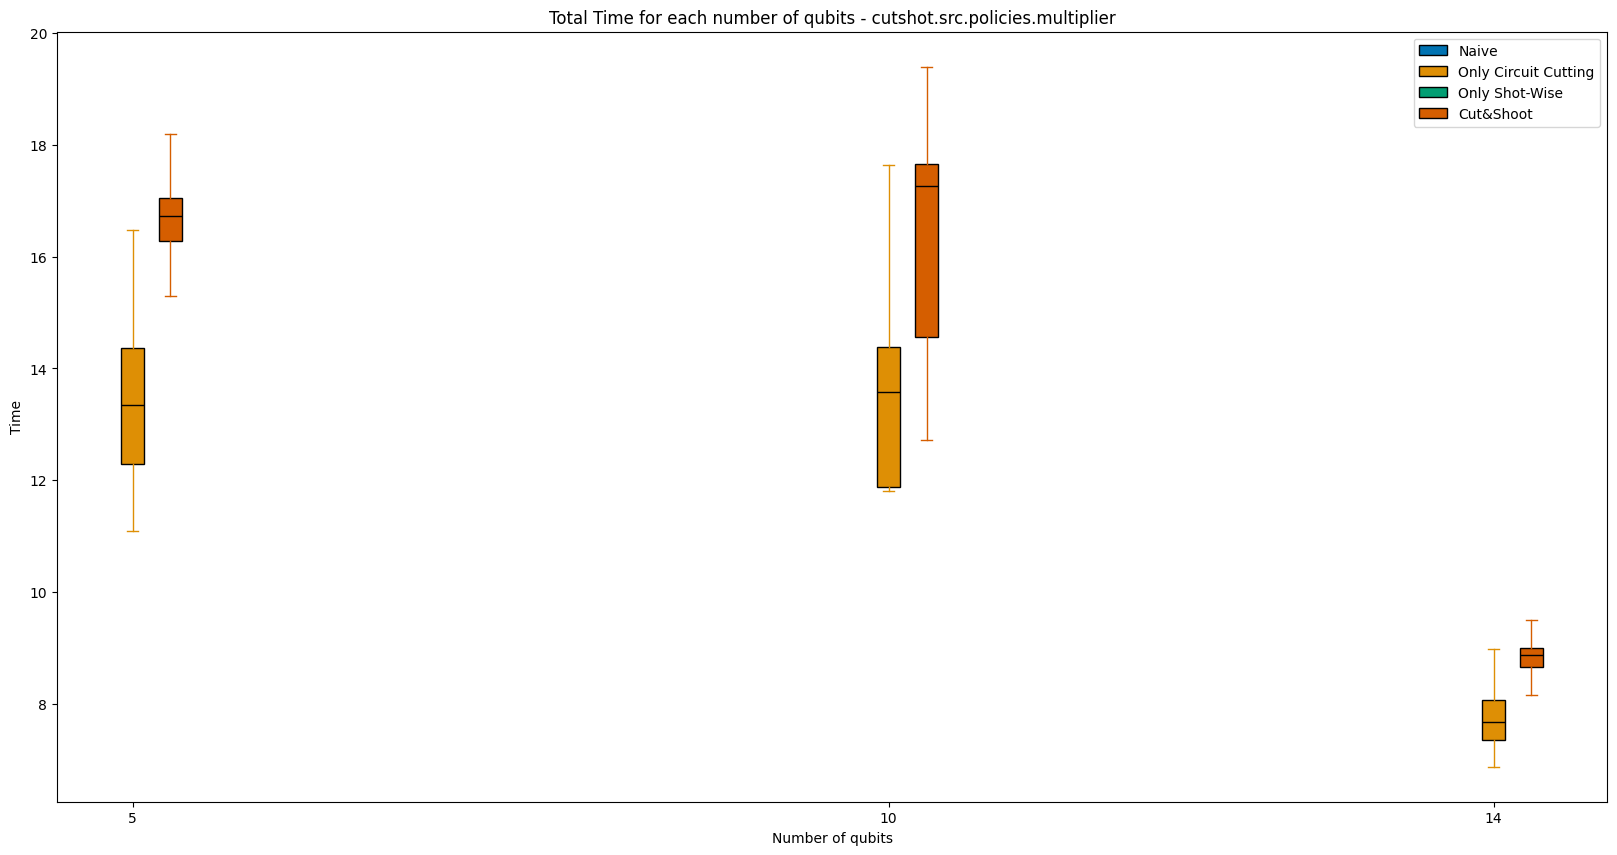

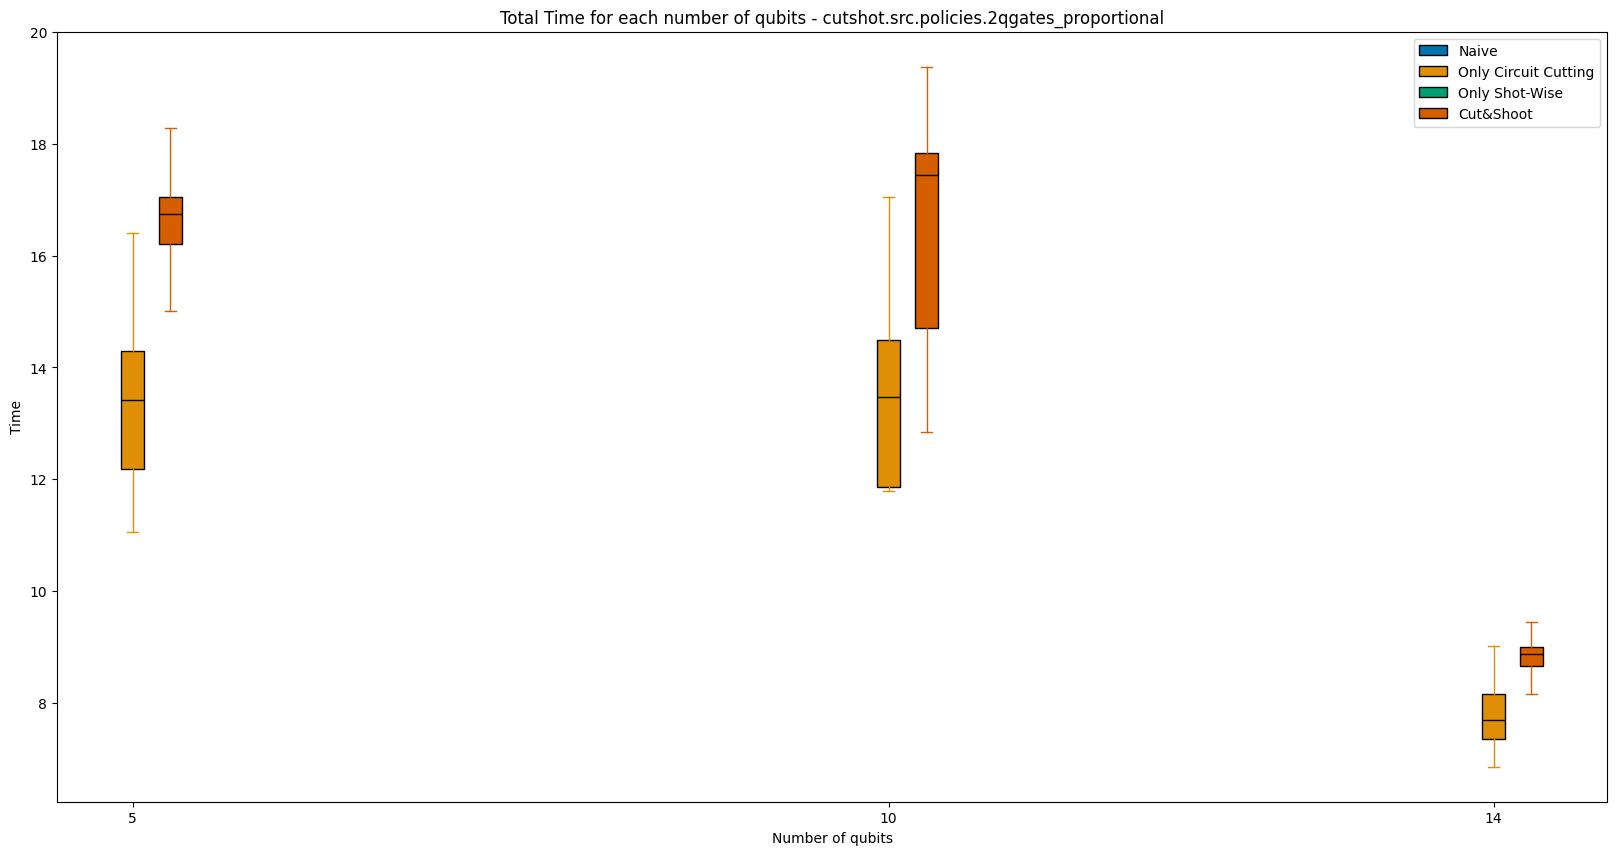

In [ ]:
for sa in exp_data_df["shots_allocation"].unique():
    if sa is None:
        continue
    
    
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    for qubits in exp_data_df["qubits"].unique():
        data = exp_data_df[(exp_data_df["qubits"] == qubits) & (exp_data_df["shots_allocation"] == sa)]
        
        vanilla = data[data["strategy"] == "vanilla"]
        cc = data[data["strategy"] == "cc"]
        shot_wise = data[data["strategy"] == "sw"]
        cc_sw = data[data["strategy"] == "cc_sw"]
        
        offset = 0
        color = colors["vanilla"]
        ax.boxplot(vanilla["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not vanilla.empty:
            offset += 0.25
        
        color = colors["cc"]
        ax.boxplot(cc["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not cc.empty:
            offset += 0.25
        
        color = colors["sw"]
        ax.boxplot(shot_wise["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        if not shot_wise.empty:
            offset += 0.25
            
        color = colors["cc_sw"]
        ax.boxplot(cc_sw["time_total"], positions=[qubits+offset], showfliers=False, patch_artist=True, boxprops=dict(facecolor=color), medianprops=dict(color="black"), whiskerprops=dict(color=color), capprops=dict(color=color), flierprops=dict(markerfacecolor=color))
        
    ax.set_xlabel("Number of qubits")
    ax.set_ylabel("Time")
    ax.set_title("Total Time for each number of qubits - "+sa)
    ax.set_xticks(exp_data_df["qubits"].unique())
    ax.set_xticklabels(exp_data_df["qubits"].unique())
    ax.legend([plt.Rectangle((0,0),1,1,fc=colors[strategy], ec="black") for strategy in exp_data_df["strategy"].unique()], [legend[strategy] for strategy in exp_data_df["strategy"].unique()])
    
    plt.savefig(plots_dir + f"total_time_num_qubits_{sa}.png")
    plt.show()
    

In [ ]:
# TODO: analyse number of qubits and depth stats (also considering cirucit cutting)